# Prediction of visual acuity improvement after macular hole surgery
References
Godbout, M., et al. "Predicting Visual Improvement after Macular Hole Surgery: a Cautionary Tale on Deep Learning with Very Limited Data." arXiv preprint arXiv:2109.09463 (2021).
https://arxiv.org/pdf/2109.09463v2.pdf



In [1]:
#!pip3 install missingno

In [504]:
#Python library

# Classic,data manipulation and linear algebra

import pandas as pd
import numpy as np

#Importation data
import os
import glob
from pandas import set_option

#Graphical tools
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns
%matplotlib inline

#Statistiques
import statsmodels.api as sm
from scipy.stats import chi2_contingency


#Data imputing/preprocessing

# To use the experimental IterativeImputer, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures,PowerTransformer,QuantileTransformer
from sklearn.cluster import KMeans

# Classifiers
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import ElasticNet, PassiveAggressiveRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neural_network import MLPRegressor

# Metrics and ML processing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error,make_scorer,r2_score, mean_absolute_error,mean_pinball_loss
#from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from datetime import datetime
import missingno as msno

#warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', '.*do not.*', )
warnings.warn('Do not show this message')
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# some nice colors from http://colorbrewer2.org/
COLOR1 = '#7fc97f'
COLOR2 = '#beaed4'
COLOR3 = '#fdc086'
COLOR4 = '#ffff99'
COLOR5 = '#386cb0'

sns.set(rc={'figure.figsize':(9, 4)})
sns.set_theme(context="notebook", style="white", palette="Set2")

# Pour la reproductibilité des résultats
#rs=np.random.seed(42)
rs=42
#import pandas_profiling as pp

## Lire les donnees

In [505]:
li=[]
DATADIR="D:/Daiana/Documents/AEC Intelligence artificielle/100Randonnee/Data/oct_data"
CATEGORIES=['others','test','train','val']

for c in CATEGORIES:
    path=os.path.join(DATADIR,c)
    all_files = glob.glob(os.path.join(path, "*.csv"))
    for csv in all_files:
        df=pd.read_csv(csv)
        li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

In [506]:
frame.head()

id  age  sex  pseudophakic  mh_duration  elevated_edge  mh_size  \
0  121   66    2             0           -9             -9       -9   
1  122   77    2             0           -9             -9       -9   
2  123   70    2             0           -9              1      378   
3  124   63    2             0           -9              1      384   
4  125   55    1             0           -9              1      580   

   VA_baseline  VA_2weeks  VA_3months  VA_6months  VA_12months  VA_2months  
0           10        0.0        41.0        41.0          NaN         NaN  
1           10       21.0        42.0         NaN          NaN         NaN  
2           43       63.0        58.0         NaN         67.0         NaN  
3           49       10.0         NaN         NaN         64.0         NaN  
4           50       68.0        69.0         NaN          NaN         NaN

In [507]:
frame.shape

(494, 13)

In [508]:
df=frame.copy()

## Partie I:  AED
L’analyse descriptive a été utilisée pour étudier les caractéristiques de base.

### Questions

### Questions préliminaires de l’AED

1. Quelles sont les descripteurs (colonnes) du data set ?

2. Combien d'enregistrements (lignes) ont été fournis ?

3. Quel est le format des données. Par exemple, dans quel format les dates sont fournies, existe-t-il des valeurs numériques, à quoi ressemblent les différentes valeurs catégorielles ?

4. Y a-t-il des valeurs manquantes ? Y a-t-il des variables avec un nombre élevé de valeurs manquantes ?

5. Est-ce que les classes sont-elles équilibrées ?

6. Est-ce qu'il y a des variables aberrantes ?

7. Laquelle des variables pourrait être utile à mon objectif ? 

8. Que représente une seule ligne de l'ensemble de données ? 

### Exploration plus approfondie des données

1. Numérique variable : Statistique descriptive 

* Quels sont les statistiques descriptives de base d’une variable numérique : count, mean, std, min, 25%, median, 75%, max

* Quelle est la plage d’une variable numérique ? 

* Les variables sont-elles fortement corrélées les unes aux autres ?

* Les variables sont-elles fortement corrélées avec le Target ?

2. Variable catégorielle

* Quelle est la valeur la plus fréquente pour une variable catégorielle ?

* Quelle est la moyenne d’une variable numérique regroupée par une variable catégorielle ?

* Combien de points de données y a-t-il, regroupés par 2 variables catégorielles ?

3. Visualisation des données

* Quelle est la distribution d’une variable numérique ? Y a-t-il des erreurs à gérer ?

* barchart (variable catégorielle univariante)

* heatmap (deux variable catégorielle)

* scatterplot (variable numérique bivarie)

* violon (for outliers : variable target)


## Projet: Prédiction de l’amélioration de l’acuité visuelle après une chirurgie du trou maculaire

### Context 

Les données représentent des chirurgies de trous maculaires réussies de 2014 à 2018 au CHU de Québec.

Nous sommes intéressés à savoir si nous pouvons, à partir d’exemples de chirurgie, prédire dans quelle mesure l’opération aura un impact positif sur l’acuité visuelle du patient.

Predire les valeurs de l’acuité visuelle du patient apres 2 semains de l'operation, 3 mois, 6 mois respectivement 12 mois.

https://www.kaggle.com/mathieugodbout/oct-postsurgery-visual-improvement


### Analyse des forme

* Variables target : VA_2weeks, VA_3months, VA_6months, VA_12months

* Ligne et colonnes: (494,12)

* Type de variables: categorique binaire {pseudophakic, elevated_edge,sexe}
                     categorique: id,  mh_duration,age
                     numerique: mh_size,VA_baseline,VA_2weeks,VA_3months,VA_6months,VA_12months

* id: Identifiant unique du patient.
* age: Âge du patient.
* sexe: Le sexe du patient
* pseudophakic: Caractéristique décrivant si un patient a subi une chirurgie de la cataracte dans le passé. {1 si oui,0 sinon.}
* mh_duration: Durée (en semaines) du trou maculaire du patient.
* elevated_edge: Présence ou non d’un bord élevé chez le patient. 1 si oui, 0 sinon.

* mh_size: Taille (en micromètres) du trou maculaire avant l’opération..
* VA_baseline: Acuité visuelle (mesurée en lettres ETDRS) du patient avant la chirurgie.
* VA_2weeks: Acuité visuelle (mesurée en lettres ETDRS) du patient 2 semaines après la chirurgie.
* VA_3months: Acuité visuelle (mesurée en lettres ETDRS) du patient 3 mois après la chirurgie.
* VA_6months: Acuité visuelle (mesurée en lettres ETDRS) du patient 6 mois après la chirurgie.
* VA_12months: Acuité visuelle (mesurée en lettres ETDRS) du patient 12 mois après la chirurgie.

Trou maculaire : Un trou maculaire correspond à la formation d’une déhiscence (déchirure) qui touche le centre de la rétine, zone appelée la macula. Celle-ci apparaît généralement à partir de 50 ans et est plus fréquente chez les femmes. Elle peut être bilatérale chez jusqu'à 15% des sujets.

La taille du trou maculaire a probablement la meilleure valeur pronostique de fermeture de ce dernier. Les fermetures spontanées de trou maculaire se font presque exclusivement sur des trous de petite taille < 250 µm.

### Dimensions du dataset

In [509]:
print("Number of rows::",df.shape[0])
print("Number of columns::",df.shape[1] )
print("Column Names::",df.columns.values.tolist())
print("Column Data Types::\n",df.dtypes)

Number of rows:: 494
Number of columns:: 13
Column Names:: ['id', 'age', 'sex', 'pseudophakic', 'mh_duration', 'elevated_edge', 'mh_size', 'VA_baseline', 'VA_2weeks', 'VA_3months', 'VA_6months', 'VA_12months', 'VA_2months']
Column Data Types::
 id                 int64
age                int64
sex                int64
pseudophakic       int64
mh_duration        int64
elevated_edge      int64
mh_size            int64
VA_baseline        int64
VA_2weeks        float64
VA_3months       float64
VA_6months       float64
VA_12months      float64
VA_2months       float64
dtype: object


In [510]:
print("Columns with Missing Values::",df.columns[df.isnull().any()].tolist())

Columns with Missing Values:: ['VA_2weeks', 'VA_3months', 'VA_6months', 'VA_12months', 'VA_2months']


In [511]:
print("Les dimensions du jeux des donnees: ", df.shape)
print()

Les dimensions du jeux des donnees:  (494, 13)



In [512]:
# Size of our data set
## le nombre de lignes multiplié par le nombre de colonnes si DataFrame.
print("Nombre d’éléments:", df.size)
print()

Nombre d’éléments: 6422



Le nombre d'individus est égale à 494 et le nombre de descripteurs est égale à 13

### Type des donnees

In [513]:
df.dtypes

id                 int64
age                int64
sex                int64
pseudophakic       int64
mh_duration        int64
elevated_edge      int64
mh_size            int64
VA_baseline        int64
VA_2weeks        float64
VA_3months       float64
VA_6months       float64
VA_12months      float64
VA_2months       float64
dtype: object

In [514]:
df.dtypes.value_counts()

int64      8
float64    5
dtype: int64

Le jeu des donnees a 3 variable binaire(sex,pseudophakic,elevated_edge), 10 de type numerique

In [515]:

#report=pp.ProfileReport(df)
#report
#report.to_file("ReportVisualAcuity.html")

In [516]:
#_ = df.hist(figsize=(20, 14))

### Visualiser les variables 2X2

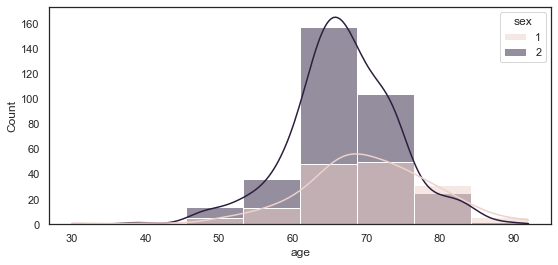

In [517]:
sns.histplot(data=df, x="age", kde=True, bins = 8, hue = 'sex')
plt.show()

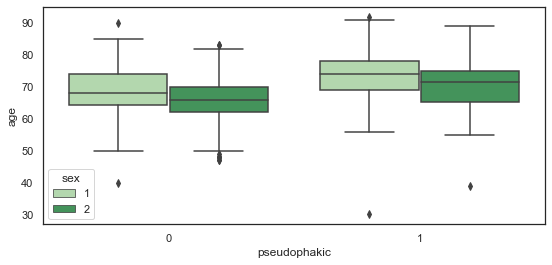

In [518]:
#plotting chart
sns.boxplot(data=df, x="pseudophakic", y='age', hue ='sex', palette="Greens")
plt.show()

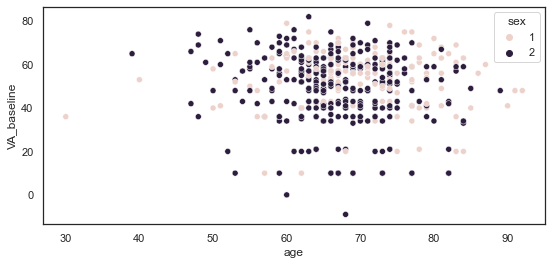

In [519]:
#plotting chart
sns.scatterplot(data=df, x="age", y='VA_baseline', hue ='sex')
plt.show()

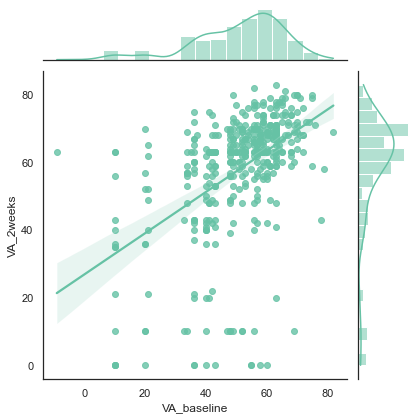

In [520]:
#plotting chart
sns.jointplot(data=df, x="VA_baseline", y='VA_2weeks', palette="Greens", kind = "reg")
plt.show()

Il y a une forte correlation entre les variable VA_baseline et Va_2weeks. Il y a des cas dont on constat une baisse de l'acuite visuelle a 2 semains de l'intervention chirurgicale.

In [521]:
df_cont=df[['mh_duration','mh_size','age','VA_baseline','VA_2weeks','VA_3months','VA_6months','VA_12months','VA_2months']]
df_cat=df[['id', 'sex', 'pseudophakic','elevated_edge']]

#print(df_cat.head())


In [522]:
def hist_var_continu(df_cont):
    # représentations graphiques de la fréquence des valeurs individuelles dans un jeu de données
    
    fig=plt.figure(figsize=(16,8))
    for i,columns in enumerate(df_cont.columns, 1):
        ax = plt.subplot(2,5,i) # creates 9 subplots in two single row
        sns.histplot(x=df_cont[columns]) # creates histogram plots for each feature in df_cont dataset
        ax.set_xlabel(None) # removes the labels on x-axis
        ax.set_title(f'Distribution of {columns}') # adds a title to each subplot
        plt.tight_layout(w_pad=3) # adds padding between the subplots
    plt.show() # displays the plots

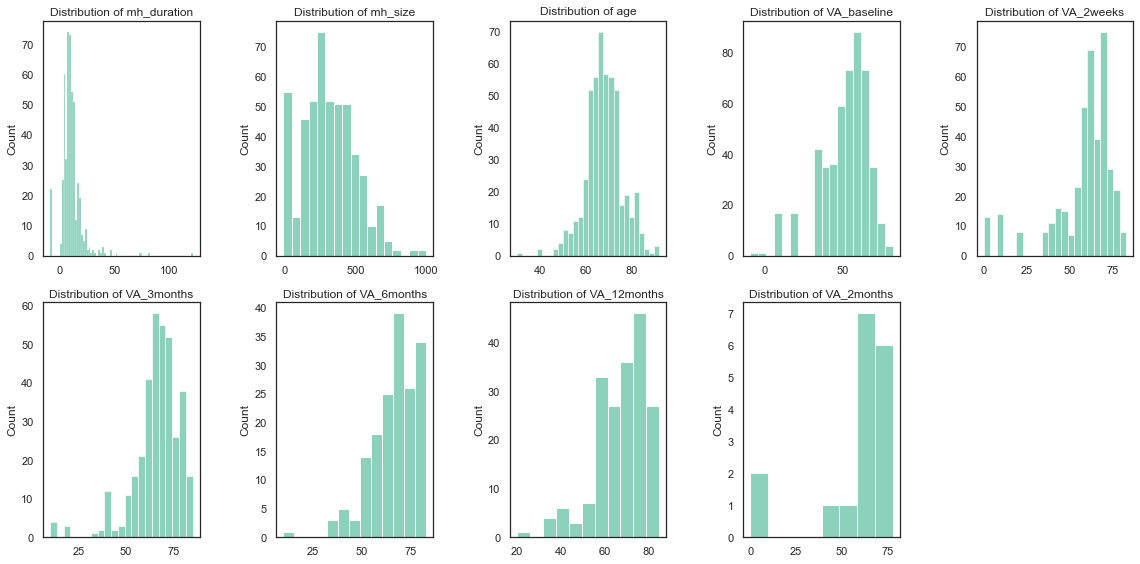

In [523]:
 hist_var_continu(df_cont)

In [524]:
def KDE_var_continu(df_cont):
    fig = plt.figure(figsize=(16, 8)) # sets the size of the plot with width as 14 and height as 8
    for i,columns in enumerate(df_cont.columns, 1): 
        ax = plt.subplot(2,5,i) # creates 4 subplots in one single row
        sns.kdeplot(x=df_cont[columns]) # creates kde plots for each feature in df_cont dataset
        ax.set_xlabel(None) # removes the labels on x-axis
        ax.set_title(f'Distribution of {columns}') # adds a title to each subplot
        plt.tight_layout(w_pad=3) # adds padding between the subplots
plt.show() # displays the plots

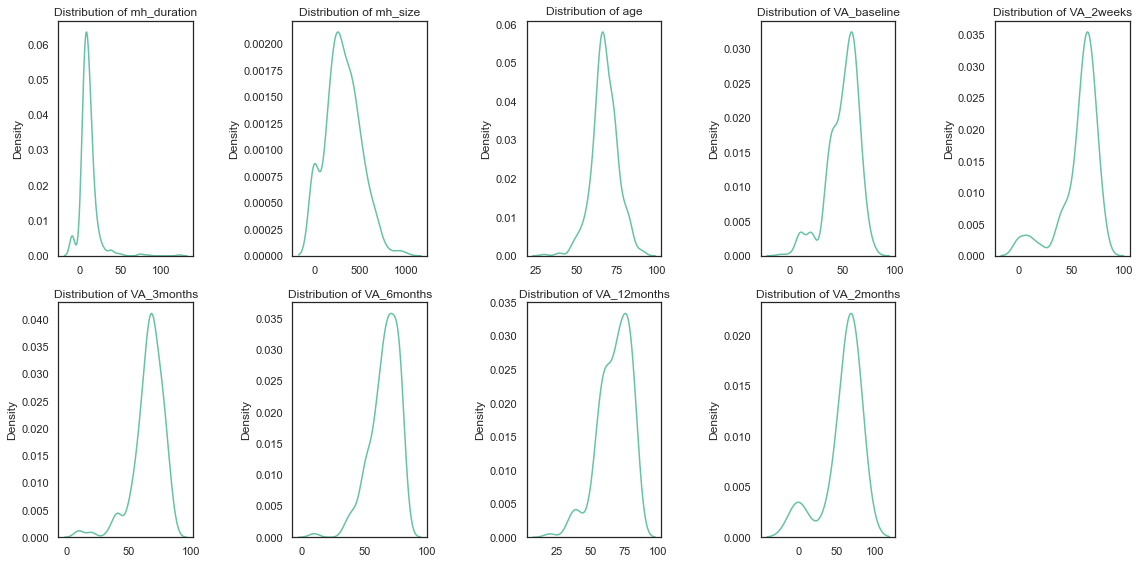

In [525]:
KDE_var_continu(df_cont)

Observations:
   1. 'mh_duration','mh_size','VA_baseline','VA_2weeks','VA_2months','VA_12months' ont une distribution bimodale
   2. mh_duration,mh_size,VA_2months : le premiere peak represent les donnees manquantes(valeurs inferieurs a 0)
   3. la distribution d'age est une distribution qui s'approche plus d'une distribution normale.Il y a des valeurs extreme de cote gauche de la distribution, ce qui signifie que le groupe des patience entre 25 et 50 est moins habituel pour ce type d'intervention.
   4. La distribution VA_Baseline a 2 peaks , possiblement 2 groupes de patience. Un avec une acuite visuelle entre 0 et 50 lettres et la majorite dont l'acuite visuelle entre 50 et 100 lettres. Cette tendance on l'observe dans la distribution de l'acuite visuelle apres 2 semains de l'intervention.


### Analyse Statistiques: Resume

**age**

* L'age des patience est 68±7.43, la valeure maxime est 92 et le minim est 30.. Cette variable est correlation avec sex,pseudophakic, elevated_edge. La valeur moyenne est 65 ans est aproximative egale a la mediane.

**sexe**
* 68.6% des individus ont la valeur du sexe=2 (339 individus),31.4% ont la valeur du sexe=1(155 individus). La variable sexe est en correlation avec les variables age,pseudophakic, elevated_edge 

**pseudophakic**
* 23.3% (115 individus)des patience ont subi une chirurgie de la cataracte dans le passé (pseudophakic=1). 

**mh_duration**
* il y a 4.5% (22 individus) des valeurs manquantes dans la variable durée (en semaines) du trou maculaire du patient(valeur mh_duration= -9).
* Le coeficient Skewness>0 (=3.952184997) la distribution de la variable mh_duration est decalee vers la gauche et la moyenne(=10.83)est superieure a la medianne (9 semains).
* Le coefficient Kurtosis >0 (=32.87232388) la distribution est plus concentree que la normale.
* Cette variable est corelee avec elevated_edge 

**elevated_edge**
* Il y a 4.3% des valeurs manquantes dans la variable binaire elevated_edge, 85% des patience ont une présence d’un bord élevé
* Les classes sont disproportionnée. 

**mh_size**
* 10.9%% des valeurs manquants pour la taille (en micromètres) du trou maculaire avant l’opération(mh_size(54 individus)=-9)
On accorde une importance particuliere aux valeurs de min et max pour les valeurs aberrantes.
La valeure maximale est de 1001, la mediane est de 296 qui est plus petite que la moyenne(310.48), la distribution est decale vars la gauche.
Il y une forte correlation avec les variables VA_3months, VA_12months
 
**VA_baseline** 
* Le taux de remplissage pour l'acuité visuelle (mesurée en lettres ETDRS) du patient avant la chirurgie(VA_baseline) est de 97%. Au moins 50% de la population ont l'acuité visuelle avant la chirurgie de 55 lettres(ETDRS).
L’acuité visuelle moyenne était de 51 lettres ETDRS.Le coefficient de variation correspondant au score ETDRS moyen (51 lettres) était de 14 lettres
Le coefficient de Skewness <0 (= -1.077483051), la distribution est decale vers la droite, avec la medianne(=55 lettres) plus grande que la moyenne(=51 lettres)
Il y a une forte correlation avec les variables : VA_2weeks, VA_3months,VA_6months,VA_12months

**VA_2weeks, VA_3months, VA_6months, VA_12months** 
* 17.6% (87 individus) des valeurs manquantes pour la variable VA_2weeks,96.6% pour la variable VA_2months ,26.9% (133 individus) pour la variable VA_3months,66.0% pour la variable VA_6months,61.5% pour la variable VA_12months.
Les valeurs moyennes sont de 58 lettres pour VA_2weeks, 65.97 lettres pour VA_3months, 67.55 lettres pour VA_6months respectivement 65.94 lettres pour la variable VA_12months.

* Le coefficient de variation VA_2weeks correspondant au score ETDRS moyen (58 lettres) était de 18.36 lettres
* Le coefficient de variation VA_3months correspondant au score ETDRS moyen (65 lettres) était de 12.42 lettres
* Le coefficient de variation VA_6months correspondant au score ETDRS moyen (67 lettres) était de 11.37 lettres
* Le coefficient de variation VA_12months correspondant au score ETDRS moyen (65 lettres) était de 11.45 lettres

Le coefficient Skewness<0 pour les 4 variables, leur distribution est decales vers la droite, et la moyenne est inferieure a la medianne.

### Valeurs manquantes

In [526]:
df_missing=df.copy()
df_missing=df_missing.replace(-9,np.NaN)

In [527]:
def missing_plot(dataset, key) :
    null_feat = pd.DataFrame(len(dataset[key]) - dataset.isnull().sum(), columns = ['Count'])
    percentage_null = pd.DataFrame((len(dataset[key]) - (len(dataset[key]) - dataset.isnull().sum()))/len(dataset[key])*100, columns = ['Count'])
    percentage_null = percentage_null.round(2)
    trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, text = percentage_null['Count'],  textposition = 'auto',marker=dict(color = '#7EC0EE',
            line=dict(color='#000000',width=1.5)))

    layout = dict(title =  "Missing Values")

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)
# Plotting 
missing_plot(df_missing,'VA_2weeks')

#### Visualiser les donnees manquantes

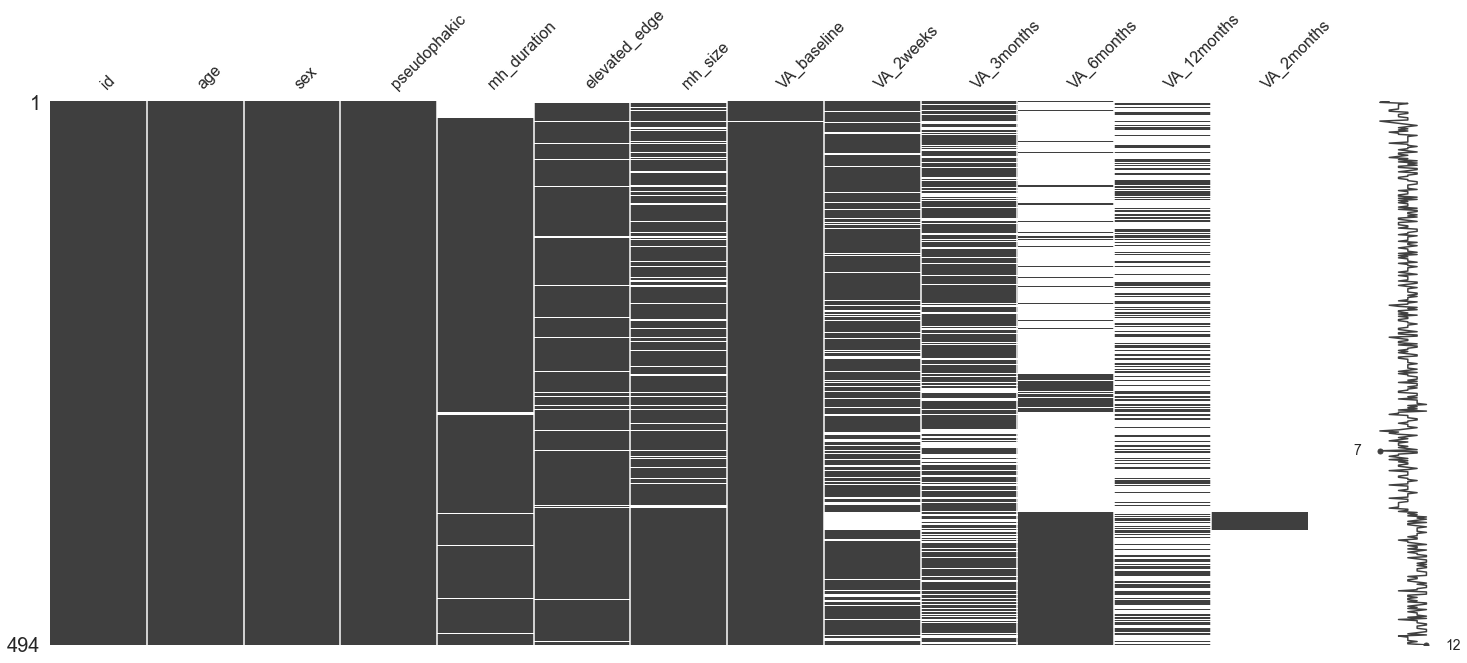

In [528]:
msno.matrix(df_missing);

Valeurs manquantes pre-operatoires:
4.45% mh_duration, 4.25% elevated_edge, 10.93% mh_size, 2% VA_baseline

Valeurs manquantes post-operatoire
 17.6% (87 individus) des valeurs manquantes pour la variable VA_2weeks, 96.6% pour la variable VA_2months ,26.9% (133 individus) pour la variable VA_3months, 66.0% pour la variable VA_6months, 61.5% pour la variable VA_12months
 

#### Affichage du nombre de valeurs manquantes nulles dans le DataFrame.

Affichons les statistiques sur les caractéristiques mesurées.

In [529]:
df_cont.describe()

mh_duration      mh_size         age  VA_baseline   VA_2weeks  \
count   494.000000   494.000000  494.000000   494.000000  407.000000   
mean     10.730769   310.489879   67.836032    51.172065   58.000000   
std      10.856728   192.173463    7.999964    14.767184   18.169969   
min      -9.000000    -9.000000   30.000000    -9.000000    0.000000   
25%       6.000000   185.000000   64.000000    42.000000   55.000000   
50%       9.000000   296.500000   67.000000    54.500000   63.000000   
75%      13.000000   432.000000   73.000000    62.000000   69.000000   
max     122.000000  1001.000000   92.000000    82.000000   83.000000   

       VA_3months  VA_6months  VA_12months  VA_2months  
count  361.000000  168.000000   190.000000   17.000000  
mean    65.880886   66.327381    67.631579   59.294118  
std     12.313033   11.579197    11.978422   23.928970  
min     10.000000   10.000000    20.000000    0.000000  
25%     61.000000   60.000000    60.000000   60.000000  
50%     68.000000   69.000000    70.000000   68.000000  
75%     74.000000   76.000000    78.000000   74.000000  
max     85.000000   83.000000    85.000000   78.000000

Les valeurs minimales -9 de plusieurs caractéristiques révèlent la présence de valeurs manquantes mises à -9. 

*  4.5% (22 individus) des valeurs manquantes dans la variable durée (en semaines) du trou maculaire du patient(valeur = -9). 

*  4.3% des valeurs manquantes dans la variable binaire elevated_edge

*  10.9 %des valeurs manquant pour la taille (en micromètres) du trou maculaire avant l’opération(54 individus=-9).

* une valeure manquante VA_baseline

* 4% des valeurs manquantes pour mh_duration

#### mh_duration

4% des valeurs manquantes- random

les valeurs de la moyenne est proche de la medianne.


In [530]:
filtre_mh_duration_negatif=df['mh_duration']<0
df[filtre_mh_duration_negatif].sort_values(by='age')

id  age  sex  pseudophakic  mh_duration  elevated_edge  mh_size  \
11   132   51    2             0           -9              1      447   
4    125   55    1             0           -9              1      580   
14   135   61    2             0           -9              0       97   
7    128   62    2             0           -9              1      256   
3    124   63    2             0           -9              1      384   
5    126   63    2             0           -9              1       -9   
8    129   64    2             0           -9              1       -9   
0    121   66    2             0           -9             -9       -9   
403   13   66    1             0           -9              1      319   
6    127   67    1             0           -9              1      293   
374  105   68    2             1           -9              0      336   
12   133   68    1             0           -9              1      149   
483   93   68    1             0           -9              1      682   
13   134   69    2             0           -9              1      278   
451   61   69    1             0           -9              1      207   
2    123   70    2             0           -9              1      378   
10   131   71    1             0           -9              1      334   
9    130   77    2             0           -9              0      225   
1    122   77    2             0           -9             -9       -9   
284  405   80    2             1           -9              1      235   
282  403   84    1             1           -9              1      498   
283  404   84    2             1           -9              1      640   

     VA_baseline  VA_2weeks  VA_3months  VA_6months  VA_12months  VA_2months  
11            60       55.0        67.0         NaN         63.0         NaN  
4             50       68.0        69.0         NaN          NaN         NaN  
14            72       63.0        77.0         NaN          NaN         NaN  
7             56       40.0        56.0         NaN          NaN         NaN  
3             49       10.0         NaN         NaN         64.0         NaN  
5             54       68.0        69.0         NaN         57.0         NaN  
8             57       57.0         NaN        56.0          NaN         NaN  
0             10        0.0        41.0        41.0          NaN         NaN  
403           63       68.0        68.0        78.0          NaN         NaN  
6             55        0.0        50.0         NaN          NaN         NaN  
374           41        NaN        70.0        78.0          NaN        68.0  
12            67       72.0         NaN         NaN         64.0         NaN  
483           57       52.0         NaN        52.0         40.0         NaN  
13            68       74.0        78.0         NaN          NaN         NaN  
451           60       69.0         NaN        70.0         58.0         NaN  
2             43       63.0        58.0         NaN         67.0         NaN  
10            59       55.0        65.0         NaN         84.0         NaN  
9             59        NaN        78.0         NaN          NaN         NaN  
1             10       21.0        42.0         NaN          NaN         NaN  
284           34        NaN         NaN         NaN         40.0         NaN  
282           20       10.0        20.0         NaN          NaN         NaN  
283           33       10.0        72.0         NaN          NaN         NaN

Il manque presque en totalite les valeurs pour VA_6months et Va_2months

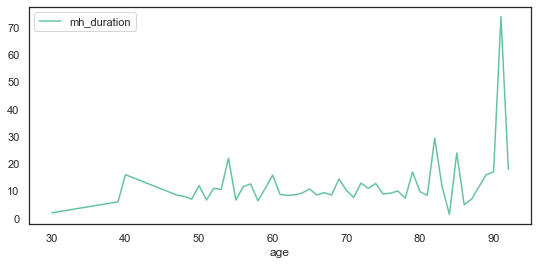

In [531]:
# ventiler mh_duration par age

pd.DataFrame(df.groupby(['age'])['mh_duration'].agg('mean')).plot()
plt.show()

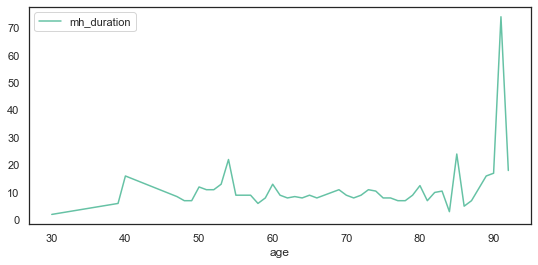

In [532]:
pd.DataFrame(df.groupby(['age'])['mh_duration'].agg('median')).plot()
plt.show()

La moyenne de la durée (en semaines) du trou maculaire du patient, varie entre 10,20 semains pour les patience entre 50 et 80 ans.

#### mh_size

10.9% des valeurs manquants pour la taille (en micromètres) du trou maculaire avant l’opération(mh_size(54 individus)=-9)


In [533]:
filtre_mh_size_negatif=df['mh_size']<0

df[filtre_mh_size_negatif].sort_values(by='age').head()

id  age  sex  pseudophakic  mh_duration  elevated_edge  mh_size  \
198  319   50    1             0           15              0       -9   
109  230   50    2             0            9              1       -9   
51   172   53    2             0            6              1       -9   
160  281   54    2             0           12              0       -9   
119  240   55    2             0            9              1       -9   

     VA_baseline  VA_2weeks  VA_3months  VA_6months  VA_12months  VA_2months  
198           40       40.0        43.0         NaN          NaN         NaN  
109           48       48.0        71.0        67.0         67.0         NaN  
51            10       35.0         NaN         NaN          NaN         NaN  
160           57       74.0        84.0        66.0          NaN         NaN  
119           76       71.0        67.0        80.0          NaN         NaN

#### elevated_edge

In [534]:
filtre_elevated_edge_negatif=df['elevated_edge']<0
df[filtre_elevated_edge_negatif].sort_values(by='age').head()

id  age  sex  pseudophakic  mh_duration  elevated_edge  mh_size  \
214  335   57    2             0           16             -9       -9   
268  389   65    2             0            8             -9       -9   
264  385   65    2             0            4             -9       -9   
0    121   66    2             0           -9             -9       -9   
38   159   66    2             0            5             -9       -9   

     VA_baseline  VA_2weeks  VA_3months  VA_6months  VA_12months  VA_2months  
214           63       69.0        75.0         NaN          NaN         NaN  
268           63       59.0        67.0        68.0         58.0         NaN  
264           63       70.0         NaN        76.0         83.0         NaN  
0             10        0.0        41.0        41.0          NaN         NaN  
38            34       69.0        64.0         NaN          NaN         NaN

4% des occurences ont la valeur présence ou non d’un bord élevé chez le patient manquantes.

Aussi il manque les valeurs pour la variable mh_size.


#### VA_baseline

In [535]:
filtre_VA_baseline_negatif=df['VA_baseline']<0
df[filtre_VA_baseline_negatif].sort_values(by='age')

id  age  sex  pseudophakic  mh_duration  elevated_edge  mh_size  \
18  139   68    2             0            2             -9       -9   

    VA_baseline  VA_2weeks  VA_3months  VA_6months  VA_12months  VA_2months  
18           -9       63.0         NaN         NaN         54.0         NaN

#### VA_2weeks

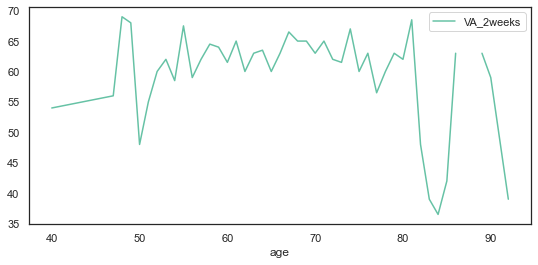

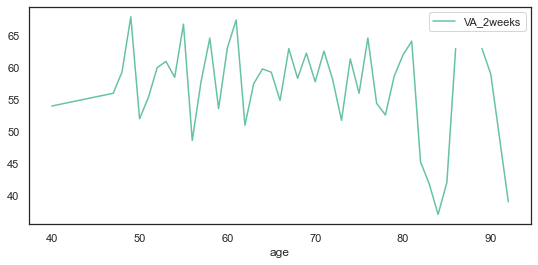

In [536]:
pd.DataFrame(df.groupby(['age'])['VA_2weeks'].agg('median')).plot()
pd.DataFrame(df.groupby(['age'])['VA_2weeks'].agg('mean')).plot()
plt.show()

In [537]:
filtre_VA_2weeks_null=df['VA_2weeks'].isna()
df[filtre_VA_2weeks_null].sort_values(by='age')

id  age  sex  pseudophakic  mh_duration  elevated_edge  mh_size  \
285  406   30    1             1            2              1      200   
448   58   39    2             1            6              1      280   
488   98   47    2             0           13              1      224   
185  306   52    2             0           14              1      555   
387  118   58    2             0            4              0      288   
..   ...  ...  ...           ...          ...            ...      ...   
380  111   83    2             0           10              1      355   
215  336   83    1             0           16              1      216   
317  438   84    2             1            9             -9       -9   
155  276   85    1             0           12              1      584   
308  429   87    1             1            7              1      384   

     VA_baseline  VA_2weeks  VA_3months  VA_6months  VA_12months  VA_2months  
285           36        NaN        74.0         NaN         70.0         NaN  
448           65        NaN         NaN        76.0         83.0         NaN  
488           66        NaN        69.0        76.0          NaN         NaN  
185           20        NaN         NaN         NaN          NaN         NaN  
387           43        NaN        70.0        63.0          NaN        60.0  
..           ...        ...         ...         ...          ...         ...  
380           59        NaN         NaN        63.0         78.0        71.0  
215           69        NaN        68.0         NaN          NaN         NaN  
317           34        NaN        68.0         NaN          NaN         NaN  
155           40        NaN        57.0         NaN          NaN         NaN  
308           60        NaN         NaN         NaN          NaN         NaN  

[87 rows x 13 columns]

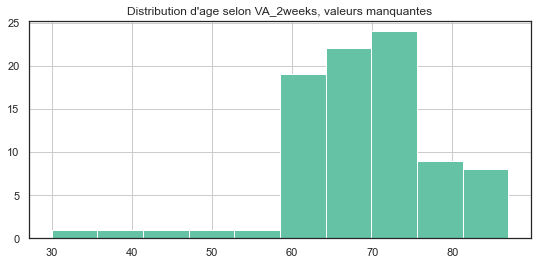

In [538]:
df[filtre_VA_2weeks_null]['age'].hist()
plt.title("Distribution d'age selon VA_2weeks, valeurs manquantes")
plt.show()

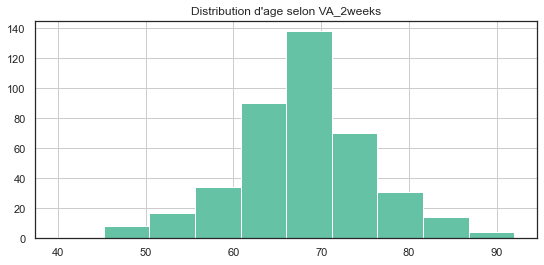

In [539]:
df[~filtre_VA_2weeks_null]['age'].hist()
plt.title("Distribution d'age selon VA_2weeks")
plt.show()

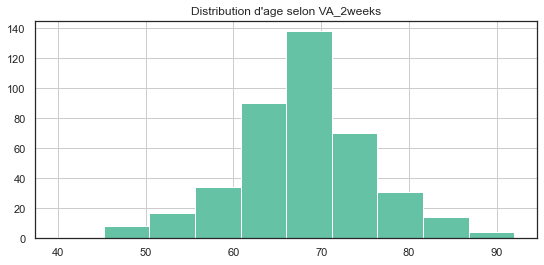

In [540]:
df[~filtre_VA_2weeks_null]['age'].hist()
plt.title("Distribution d'age selon VA_2weeks")
plt.show()

Il manque les mesures de L'acuite visuelle post operatoire a 2 semaine, pour la categorie d'age 30-45.

In [541]:
df.corr()['VA_2weeks']

id              -0.067271
age             -0.064581
sex              0.030617
pseudophakic    -0.113072
mh_duration     -0.177748
elevated_edge    0.071898
mh_size         -0.249975
VA_baseline      0.486653
VA_2weeks        1.000000
VA_3months       0.616693
VA_6months       0.272372
VA_12months      0.227457
VA_2months            NaN
Name: VA_2weeks, dtype: float64

Il y a une correlation lineaire positive entre la variable VA_2weeks et les variables VA_3months,VA_baseline.
Il y a une correlation negative avec les variables mh_size,mh_duration et pseudophakic

### Valeurs aberantes

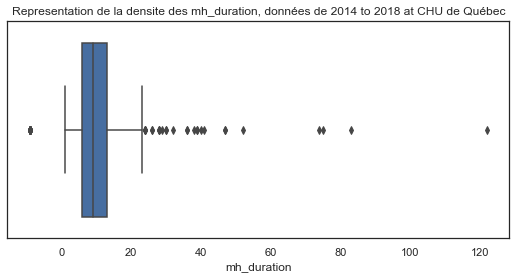

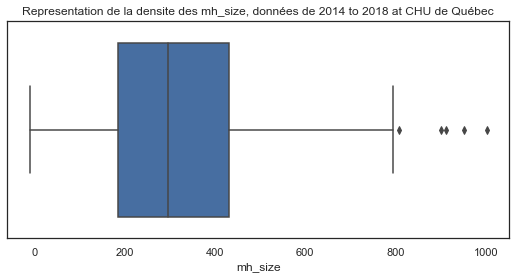

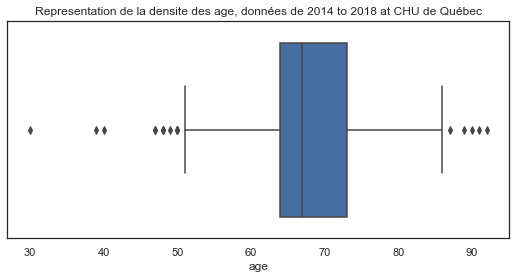

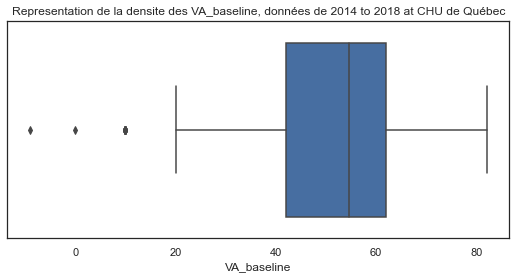

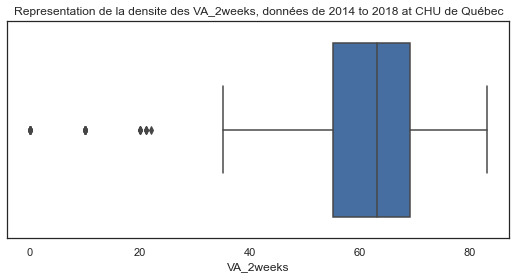

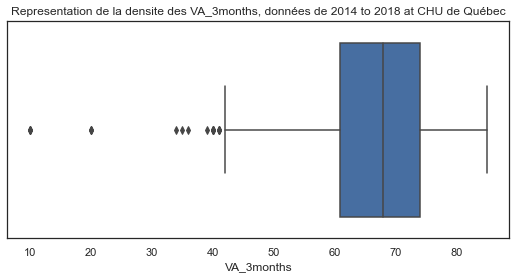

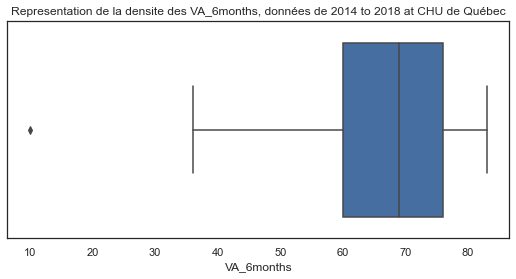

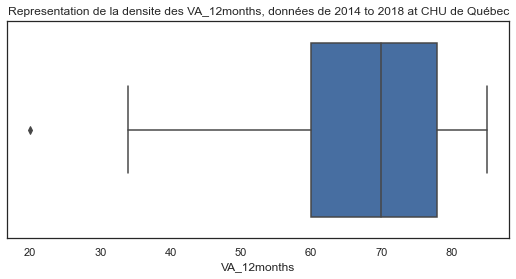

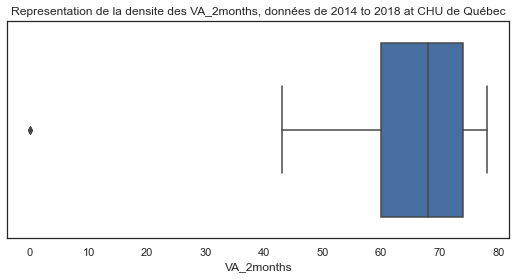

In [542]:
for feature in df_cont:
    
    sns.boxplot(data=df_cont,
                x=feature,
                #shade=True,
                color=COLOR5
               )
    plt.xlabel(feature)
    plt.ylabel("")
    plt.title("Representation de la densite des "+feature+", données de 2014 to 2018 at CHU de Québec")
    plt.show()
    #plt.savefig("mygraph.png")

In [543]:
## variable age
# 
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)
age_df_out = df[((df['age'] < (Q1 - 1.5 * IQR)) |(df['age'] > (Q3 + 1.5 * IQR)))]
age_df_out.shape


9.0


(17, 13)

In [544]:
age_df_out.sort_values(by='age')

id  age  sex  pseudophakic  mh_duration  elevated_edge  mh_size  \
285  406   30    1             1            2              1      200   
448   58   39    2             1            6              1      280   
212  333   40    1             0           16              1      272   
30   151   47    2             0            4              1      188   
488   98   47    2             0           13              1      224   
153  274   48    2             0           11              1       76   
70   191   48    2             0            6              0      120   
409   19   48    2             0            7              1      808   
394    4   49    2             0            7              1      320   
109  230   50    2             0            9              1       -9   
404   14   50    1             0           12              1      240   
198  319   50    1             0           15              0       -9   
308  429   87    1             1            7              1      384   
351  472   89    2             1           16              1      609   
412   22   90    1             0           17              1      451   
371  492   91    1             1           74              1      446   
357  478   92    1             1           18              1      184   

     VA_baseline  VA_2weeks  VA_3months  VA_6months  VA_12months  VA_2months  
285           36        NaN        74.0         NaN         70.0         NaN  
448           65        NaN         NaN        76.0         83.0         NaN  
212           53       54.0        68.0         NaN         71.0         NaN  
30            42       56.0         NaN         NaN          NaN         NaN  
488           66        NaN        69.0        76.0          NaN         NaN  
153           69       69.0        84.0         NaN          NaN         NaN  
70            74       72.0         NaN         NaN          NaN         NaN  
409           36       37.0         NaN        78.0          NaN         NaN  
394           61       68.0        70.0        83.0          NaN         NaN  
109           48       48.0        71.0        67.0         67.0         NaN  
404           58       68.0        74.0        80.0          NaN         NaN  
198           40       40.0        43.0         NaN          NaN         NaN  
308           60        NaN         NaN         NaN          NaN         NaN  
351           48       63.0        68.0         NaN          NaN         NaN  
412           41       59.0        62.0        78.0         76.0         NaN  
371           48       49.0        52.0         NaN          NaN         NaN  
357           48       39.0        41.0         NaN          NaN         NaN

Il y a 17 patience qui sont identifie outliers: 9 dont l'age est inferieur a 50 et 5 dont l'age est superieur a 87 et 3 egal a 50

In [545]:
# variable mh-size
Q1 = df['mh_size'].quantile(0.25)
Q3 = df['mh_size'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)
mh_size_df_out = df[((df['mh_size'] < (Q1 - 1.5 * IQR)) |(df['mh_size'] > (Q3 + 1.5 * IQR)))]
mh_size_df_out.shape


247.0


(5, 13)

In [546]:
mh_size_df_out

id  age  sex  pseudophakic  mh_duration  elevated_edge  mh_size  \
310  431   62    1             1            8              1      900   
311  432   72    2             1            8              1     1001   
340  461   65    1             1           13              1      912   
344  465   62    2             1           14              0      950   
409   19   48    2             0            7              1      808   

     VA_baseline  VA_2weeks  VA_3months  VA_6months  VA_12months  VA_2months  
310           10        0.0         NaN         NaN          NaN         NaN  
311           42       68.0         NaN         NaN          NaN         NaN  
340           43       59.0         NaN         NaN          NaN         NaN  
344           20       10.0        10.0         NaN         20.0         NaN  
409           36       37.0         NaN        78.0          NaN         NaN

Il y a 4 patience dont la taille (en micromètres) du trou maculaire avant l’opération  est entre 900 et 1000, qui sont identifie comme outliers.

In [547]:
# variable mh-duration
Q1 = df['mh_duration'].quantile(0.25)
Q3 = df['mh_duration'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)
mh_duration_df_out = df[((df['mh_duration'] < (Q1 - 1.5 * IQR)) |(df['mh_duration'] > (Q3 + 1.5 * IQR)))]
mh_duration_df_out.shape


7.0


(49, 13)

In [548]:
mh_duration_df_out.groupby(['mh_duration'])['mh_duration'].count()

mh_duration
-9      22
 24      4
 26      2
 28      3
 29      1
 30      2
 32      1
 36      2
 38      1
 39      2
 40      1
 41      1
 47      2
 52      1
 74      1
 75      1
 83      1
 122     1
Name: mh_duration, dtype: int64

In [549]:
mh_duration_df_out[mh_duration_df_out['mh_duration']>0].groupby(['mh_duration'])['mh_duration'].count()

mh_duration
24     4
26     2
28     3
29     1
30     2
32     1
36     2
38     1
39     2
40     1
41     1
47     2
52     1
74     1
75     1
83     1
122    1
Name: mh_duration, dtype: int64

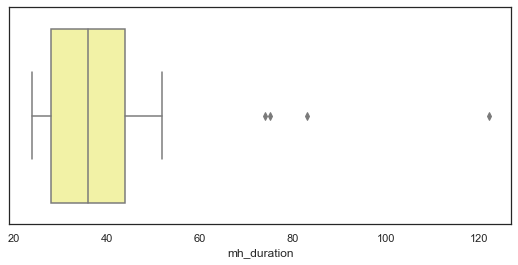

In [550]:
sns.boxplot(data=mh_duration_df_out[mh_duration_df_out['mh_duration']>0],
                x='mh_duration',
                #shade=True,
                color=COLOR4
               )
plt.show()
    #plt.savefig("mygraph.png")

La plupart des valeurs sont manquantes(-9). 
En excluant les valeurs manquantes, il reste 4 point outliers.

In [551]:
#df['VA_2weeks'].value_counts().sort_index()

In [552]:
#df.VA_baseline.value_counts().sort_index()

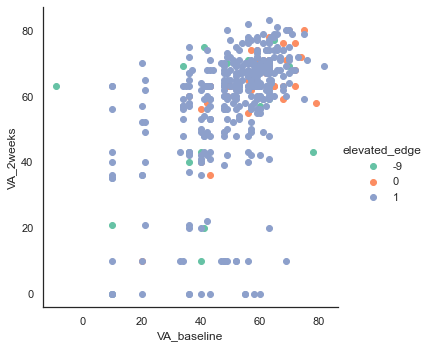

In [553]:
# Scatterplot of Va_baseline vs VA_2weeks, selon elevated_egge
sns.lmplot(x='VA_baseline',
           y='VA_2weeks',
           hue='elevated_edge',
           data=df,
           fit_reg=False,
           scatter_kws={'alpha':1.00})
plt.show()

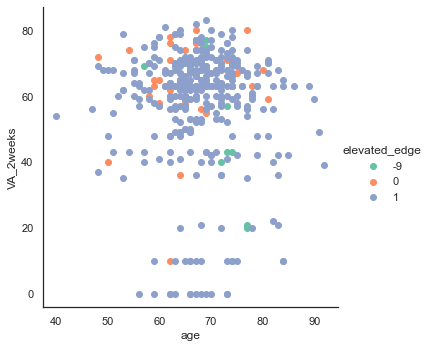

In [554]:
# Scatterplot of Va_baseline vs VA_2weeks, selon elevated_egge
sns.lmplot(x='age',
           y='VA_2weeks',
           hue='elevated_edge',
           data=df,
           fit_reg=False,
           scatter_kws={'alpha':1.00})
plt.show()

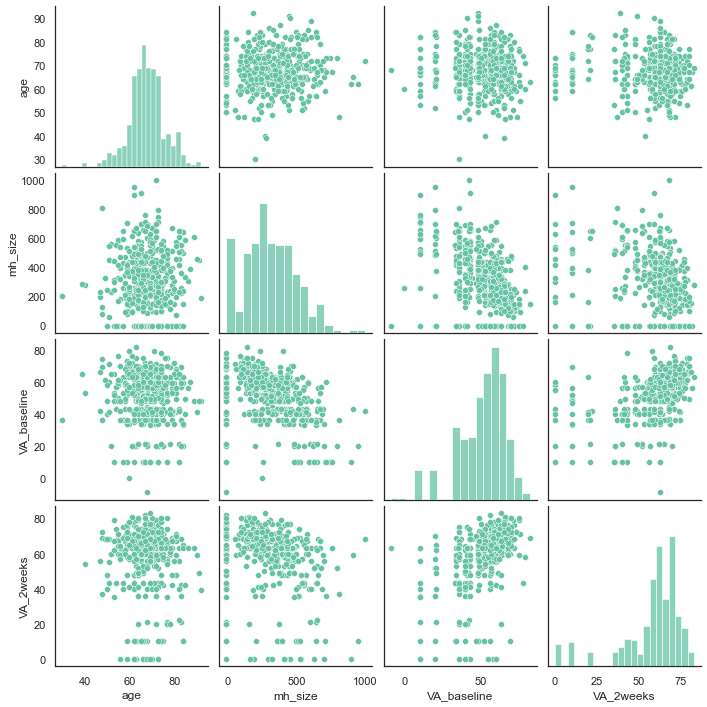

In [555]:
sns.pairplot(df[['age','mh_size','VA_baseline','VA_2weeks']])
plt.show()

Pour les variables VA_baseline et VA_2weeks on observe un groupe d’individus moins compacts ayant les mesures d'acuité visuelle 0 et 40 (lettre)avec l’âge entre 55 et 85 ans

###  Analyse univarie

#### Calculer l'impact selon la difference de moyenne

Analyser les distributions de patience qui ont subi une chirurgie de la cataracte vs ceux qui n'ont pas suivi de chirurgie selon l’acuité visuelle(VA_2weeks) (mesurée en lettres ETDRS) du patient 2 semaines après la chirurgie.

https://www.youtube.com/watch?v=He9MCbs1wgE&t=6606s

On veut explorer les statistiques qui quantifient l’ampleur de l’effet, qu’elle soit l'impact sur l’acuité visuelle (VA_2weeks), si le patient a subi ou non une chirurgie de la cataracte dans le passe.

Nous examinerons la différence moyenne de l'acuité visuelle(VA_2weeks), selon ces deux catégories de patients.

Méthode 1 : comparer les moyennes de 2 distributions et calculer la différence en pourcentage.

Méthode 2 : combien ils se chevauchent


In [556]:
df.shape

#pseudophakic: Caractéristique décrivant si un patient a subi une chirurgie de la cataracte dans le passé. {1 si oui,0 sinon.}

(494, 13)

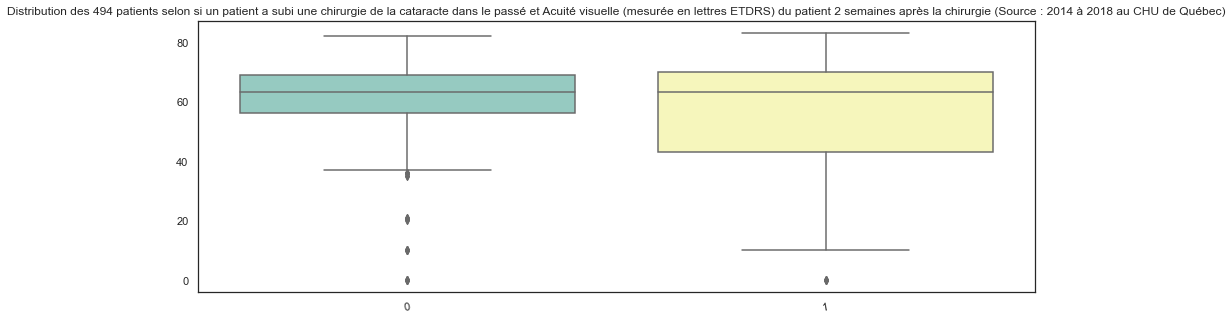

In [557]:

plt.figure(figsize=(15,5))
ax=sns.boxplot(data=df,
            x='pseudophakic', 
            y='VA_2weeks'
            ,palette="Set3"
           )
ax.set( xlabel='', 
        ylabel=''
            )
ax.set_title("Distribution des 494 patients selon si un patient a subi une chirurgie de la cataracte dans le passé et Acuité visuelle (mesurée en lettres ETDRS) du patient 2 semaines après la chirurgie (Source : 2014 à 2018 au CHU de Québec)")
plt.setp(ax.get_xticklabels(), rotation=10)
plt.show()

In [558]:
df_avecChirurgie=df[df['pseudophakic']==1]
df_sansChirurgie=df[df['pseudophakic']==0]

In [559]:
mean1=df_avecChirurgie.VA_2weeks.mean()
mean2=df_sansChirurgie.VA_2weeks.mean()
print("La moyenne de l’acuité visuelle (mesurée en lettres ETDRS) du patient 2 semaines après la chirurgie intervention chirurgie vs sans chirurgie  ",mean1, mean2)
print("La différence moyenne de l’acuité visuelle (mesurée en lettres ETDRS) du patient 2 semaines après la chirurgie entre chirurgie vs sans chirurgie ",mean1-mean2)

La moyenne de l’acuité visuelle (mesurée en lettres ETDRS) du patient 2 semaines après la chirurgie intervention chirurgie vs sans chirurgie   53.976190476190474 59.04643962848297
La différence moyenne de l’acuité visuelle (mesurée en lettres ETDRS) du patient 2 semaines après la chirurgie entre chirurgie vs sans chirurgie  -5.070249152292497


En moyenne l'acuité visuelle 2 semaines après la chirurgie intervention pour les patients qui ont subi une chirurgie de la cataracte dans le passé ont 4.720 lettre de moins versus les patients qui n'ont pas d’intervention.
 * Sans connaitre plus de la distribution, par exemple l'écart type, il est difficile de conclure si 4 lettre et beaucoup ou pas
 
 * Pour quantifier la différence entre les moyenne, on va exprimer cette différence en a pourcentage de la moyenne


In [560]:
diff_relative_AvecChirurgie=(mean1-mean2)/mean1
diff_relative_SansChirurgie=(mean1-mean2)/mean2

print("La différence relative des moyennes entre les patients avec intervention chirurgie et sans intervention   ", diff_relative_AvecChirurgie*100, diff_relative_SansChirurgie*100)

La différence relative des moyennes entre les patients avec intervention chirurgie et sans intervention    -9.393492033360603 -8.586883788750402


4 lettre représentés 8.68% de moins en moyenne, pour l’acuité visuelle 2 semaines après la chirurgie intervention pour les patients qui ont subi une chirurgie de la cataracte dans le passé.

In [561]:
#Normal or Gaussian distribution
#param: moyenne et ecart - type de la population avec/sans chirurgie
import scipy.stats

VA_2weeks_AvecChirurgie = scipy.stats.norm(mean1, df_avecChirurgie.VA_2weeks.std())
VA_2weeks_SansChirurgie = scipy.stats.norm(mean2, df_sansChirurgie.VA_2weeks.std())
VA_2weeks_AvecChirurgie.args

(53.976190476190474, 24.219864490023248)

La fonction suivante évalue la fonction de densité de probabilité normale (gaussienne) (PDF) dans les 4 écarts-types de la moyenne. Il prend et l’objet rv et retourne une paire de tableaux NumPy.

In [562]:
#evaluer the PDF = the probability density function pour visualiser les plots de la distribution Gaussian rv=random variable
def eval_pdf(rv, num=4):
    mean, std = rv.mean(), rv.std()
    xs = np.linspace(mean - num*std, mean + num*std, 100)
    ys = rv.pdf(xs)
    return xs, ys

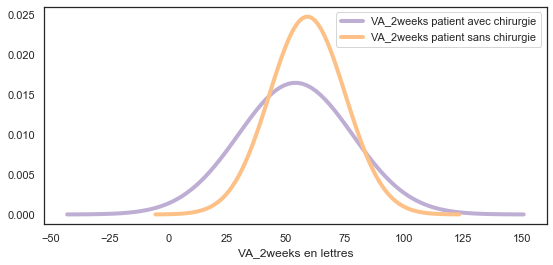

In [563]:
xs, ys = eval_pdf(VA_2weeks_AvecChirurgie)
plt.plot(xs, ys, label='VA_2weeks patient avec chirurgie', linewidth=4, color=COLOR2)

xs, ys = eval_pdf(VA_2weeks_SansChirurgie)
plt.plot(xs, ys, label='VA_2weeks patient sans chirurgie', linewidth=4, color=COLOR3)
plt.xlabel('VA_2weeks en lettres')

plt.legend()
None

Methode 2 : combien ils se chevauchent , c'est une methode qui aide la classification des groupes
Dans notre cas le chevouchement est eleves , par consequence une taux de mauvaise classifcation eleves.

Pour définir le chevauchement, nous choisissons un seuil entre les deux moyens. 

Le seuil simple est le point médian entre les moyennes:

In [564]:
#exemple1
#fixer un point de chevauchement
simple_thresh=(mean1+mean2)/2
simple_thresh

56.51131505233673

In [565]:
#exemple2
std_avecChirurgie=df_avecChirurgie.VA_2weeks.std()
std_sansChirurgie=df_sansChirurgie.VA_2weeks.std()
print(mean1,std_avecChirurgie,mean2,std_sansChirurgie)
point=(std_avecChirurgie*mean2 + std_sansChirurgie*mean1)/(std_avecChirurgie+std_sansChirurgie)
point

53.976190476190474 24.219864490023248 59.04643962848297 16.1166461730795


57.020597277384354

In [566]:
# combien de patients avec chirurgie sont en dessous du seuil 

patient_AvecChirurgie_below_seuil=sum(df_avecChirurgie.VA_2weeks<point)
patient_AvecChirurgie_below_seuil

26

In [567]:
# combien de patients sans chirurgie sont en dessous du seuil 
patient_SansChirurgie_below_seuil=sum(df_sansChirurgie.VA_2weeks<point)
patient_SansChirurgie_below_seuil

101

Le « chevauchement » est l’aire sous les courbes qui se retrouve du mauvais côté du seuil

In [568]:
patient_AvecChirurgie_overlap = patient_AvecChirurgie_below_seuil / len(df_avecChirurgie)
patient_SansChirurgie_overlap = patient_SansChirurgie_below_seuil / len(df_sansChirurgie)
patient_AvecChirurgie_overlap, patient_SansChirurgie_overlap

(0.22608695652173913, 0.26649076517150394)

In [569]:
missclassification_rate=(patient_AvecChirurgie_overlap+patient_SansChirurgie_overlap) /2
missclassification_rate

0.24628886084662155

Il y a 23 patients avec chirurgie respectivement 78 patients sans chirurgie en dessous du seuil. 

Ca veut dire qu'il y a 101 patients, 26%, qui seront classifie en mode errone si on prend comme variable de prediction la variable pseudophakic: Caractéristique décrivant si un patient a subi une chirurgie de la cataracte dans le passé. {1 si oui,0 sinon.

### Enrichissement des données

#### Calcul Groupe d'age

* Groupe d’âge: 	[0,50) [50,60) [60,70) [70,80) [80,110) 

In [570]:
df['ageGroup']= pd.cut(df.age,[0,50,60,70,80,110],
                            labels=['0-50','50-60','60-70','70-80','80-plus']
                           )

In [571]:
df['ageGroup'].unique()

['60-70', '70-80', '50-60', '80-plus', '0-50']
Categories (5, object): ['0-50' < '50-60' < '60-70' < '70-80' < '80-plus']

In [572]:
df.head()

id  age  sex  pseudophakic  mh_duration  elevated_edge  mh_size  \
0  121   66    2             0           -9             -9       -9   
1  122   77    2             0           -9             -9       -9   
2  123   70    2             0           -9              1      378   
3  124   63    2             0           -9              1      384   
4  125   55    1             0           -9              1      580   

   VA_baseline  VA_2weeks  VA_3months  VA_6months  VA_12months  VA_2months  \
0           10        0.0        41.0        41.0          NaN         NaN   
1           10       21.0        42.0         NaN          NaN         NaN   
2           43       63.0        58.0         NaN         67.0         NaN   
3           49       10.0         NaN         NaN         64.0         NaN   
4           50       68.0        69.0         NaN          NaN         NaN   

  ageGroup  
0    60-70  
1    70-80  
2    60-70  
3    60-70  
4    50-60

## Partie II: Prétraitement des données.

In [573]:
def encode_df(df):
    df_encode=df.copy()
    df_encode= pd.get_dummies(df_encode, columns=['sex','ageGroup'],drop_first=True)
    return df_encode

In [574]:
df_encode=encode_df(df)

#### Séparation des variables X et de la réponse y de la base de données.

In [575]:
df_encode.columns

Index(['id', 'age', 'pseudophakic', 'mh_duration', 'elevated_edge', 'mh_size',
       'VA_baseline', 'VA_2weeks', 'VA_3months', 'VA_6months', 'VA_12months',
       'VA_2months', 'sex_2', 'ageGroup_50-60', 'ageGroup_60-70',
       'ageGroup_70-80', 'ageGroup_80-plus'],
      dtype='object')

In [576]:
def get_data(df, var_nulle=''):
    
    df_=pd.DataFrame()
    df_=df[~df[var_nulle].isnull()].copy()
    # Cractéristiques mesurées
    X=df_.drop(['id','age','VA_2weeks','VA_3months','VA_6months','VA_12months','VA_2months'],axis=1)
    #Reponses numeriques
    Y=df_[var_nulle]
    # Liste des variables utilisées
    feature_list = list(X.columns)
    return X,Y,feature_list

In [577]:
X,Y,feature_liste=get_data(df_encode,'VA_2weeks')
X.shape, Y.shape,feature_liste

((407, 10),
 (407,),
 ['pseudophakic',
  'mh_duration',
  'elevated_edge',
  'mh_size',
  'VA_baseline',
  'sex_2',
  'ageGroup_50-60',
  'ageGroup_60-70',
  'ageGroup_70-80',
  'ageGroup_80-plus'])

Le jeu des donnees a 407 occurences dont Acuité visuelle (mesurée en lettres ETDRS) du patient 2 semaines après la chirurgie est saisie..

### Traitement valeurs manquantes

#### Imputation des données pour remplacer les valeurs manquantes indiquées par -9.

On utilise les méthodes suivantes pour imputer les valeurs manquantes:

1. imputation par la valeur constante 0

2. imputation par la valeur moyenne de chaque caractéristique combinée à une variable auxiliaire d’indicateur de manque

3. k imputation du plus proche voisin

4. imputation itérative


Pour predire les valeurs de la variable VA_2weeks on utilise le model TheilSenRegressor.
La metrique utilise dans l'ealuation du resultat est mean squared error (MSE) 


**Documentation** 

https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py

In [578]:
N_SPLITS = 5
#regressor = RandomForestRegressor (n_estimators=100,max_depth=5,random_state=0)
#regressor=HuberRegressor(max_iter=10000)
regressor=TheilSenRegressor(max_iter=10000,random_state=rs)
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Analyse methode Imputing

En plus d’imputer les valeurs manquantes, les imputers ont un paramètre add_indicator qui marque les valeurs manquantes, ce qui peut contenir des informations.

Le mean squared error (MSE) est une mesure de la qualité d’un estimateur.Est une méthode de calcul de la différence entre les valeurs prédites et réelles d’un modèle.En tant que tel, MSE est une fonction de risque qui nous permet de calculer la différence quadratique moyenne entre la valeur prédite et la valeur réelle d’une caractéristique ou d’une variable.

In [579]:
def get_scores_for_imputer(imputer, X_missing, y_missing=None):
    estimator = make_pipeline(imputer, regressor)
    impute_scores = cross_val_score(estimator, 
                                    X_missing, 
                                    y_missing, 
                                    scoring="neg_mean_squared_error", 
                                    cv=N_SPLITS)
    return impute_scores

x_labels = []
mses_visual = np.zeros(6)
stds_visual = np.zeros(6)

### Estimer le score

Tout d’abord, nous voulons estimer le score sur les données d’origine:

In [580]:
#returns the mean and std for the Array of scores of the estimator for each run of the cross validation.
def get_full_score(X_full, y_full):
    full_scores = cross_val_score( regressor, X_full, y_full, scoring="neg_mean_squared_error", cv=N_SPLITS                     
    )
    print(full_scores)       
    return full_scores.mean(), full_scores.std()

mses_visual[0], stds_visual[0] = get_full_score(X, Y)
x_labels.append("Full data")
print(f"La moyenne MSE du RandomForestRegressor sur les donnees d'origine:\n"
      f"{-mses_visual[0]:.3f} +/- {stds_visual[0]:.3f}")

[-583.27972862 -158.34671198 -324.40867054 -290.42497647 -290.41545186]
La moyenne MSE du RandomForestRegressor sur les donnees d'origine:
329.375 +/- 139.124


### Remplacer les valeurs manquantes par 0

Nous allons maintenant estimer le score sur les données où les valeurs manquantes sont remplacées par 0:

In [581]:
def get_impute_zero_score(X_missing, y_missing):

    imputer = SimpleImputer(missing_values=-9, add_indicator=True, strategy="constant", fill_value=0)
    zero_impute_scores = get_scores_for_imputer(imputer, X, Y)
    return zero_impute_scores.mean(), zero_impute_scores.std()

mses_visual[1], stds_visual[1] = get_impute_zero_score(X, Y)
x_labels.append("Zero imputation")
print(f"La moyenne MSE du RandomForestRegressor sur les impute par constante 0:\n"
      f"{-mses_visual[1]:.3f} +/- {stds_visual[1]:.3f}")

La moyenne MSE du RandomForestRegressor sur les impute par constante 0:
249.707 +/- 66.216


### kNN-imputation of the missing values

KNNImputer impute les valeurs manquantes en utilisant la moyenne pondérée ou non pondérée du nombre souhaité de voisins les plus proches.

In [582]:
def get_impute_knn_score(X_missing, y_missing):
    imputer = KNNImputer(missing_values=-9, add_indicator=True)
    knn_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return knn_impute_scores.mean(), knn_impute_scores.std()

mses_visual[2], stds_visual[2] = get_impute_knn_score(X, Y)
x_labels.append("kNN imputation")
print(f"La moyenne MSE du RandomForestRegressor sur les donnees imputee par kNN:\n"
      f"{-mses_visual[2]:.3f} +/- {stds_visual[2]:.3f}")

La moyenne MSE du RandomForestRegressor sur les donnees imputee par kNN:
243.888 +/- 56.894


### Imputer les valeurs manquantes avec la moyenne/mediane

In [583]:
def get_impute_mean(X_missing, y_missing):
    imputer = SimpleImputer(missing_values=-9, strategy="mean", add_indicator=True)
    mean_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return mean_impute_scores.mean(), mean_impute_scores.std()

mses_visual[3], stds_visual[3] = get_impute_mean(X, Y)
x_labels.append("mean imputation")
print(f"La moyenne MSE du RandomForestRegressor sur les donnees imputee par la moyenne:\n"
      f"{-mses_visual[3]:.3f} +/- {stds_visual[3]:.3f}")

La moyenne MSE du RandomForestRegressor sur les donnees imputee par la moyenne:
244.570 +/- 59.144


In [584]:
def get_impute_median(X_missing, y_missing):
    imputer = SimpleImputer(missing_values=-9, strategy="median", add_indicator=True)
    mean_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return mean_impute_scores.mean(), mean_impute_scores.std()


mses_visual[4], stds_visual[4] = get_impute_median(X, Y)
x_labels.append("median imputation")
print(f"La moyenne MSE du RandomForestRegressor sur les donnees imputee par la medianne:\n"
      f"{-mses_visual[4]:.3f} +/- {stds_visual[4]:.3f}")

La moyenne MSE du RandomForestRegressor sur les donnees imputee par la medianne:
245.123 +/- 59.745


### Iterative imputation of the missing values

[Iterative Imputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html) de la librairie Scikit-learn. On applique l'imputation à toutes les variables contenant des valeurs nulles.

Cela utilise la régression linéaire circulaire, modélisant chaque entité avec des valeurs manquantes en fonction d’autres entités, à son tour. La version implémentée suppose des variables gaussiennes (de sortie). Si vos fonctionnalités sont manifestement non normales, envisagez de les transformer pour qu’elles aient l’air plus normales afin d’améliorer potentiellement les performances.


In [585]:

def get_impute_iterative(X_missing, y_missing):
    imputer = IterativeImputer(estimator=TheilSenRegressor(max_iter=100,random_state=rs),#estimator=HuberRegressor(max_iter=500),#estimator=RidgeCV(alphas=[0.001, 0.1, 1, 10, 1000]) ,
        missing_values=-9,
        add_indicator=True,
        random_state=0,
        n_nearest_features=5,
        sample_posterior=False
    )
    iterative_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return iterative_impute_scores.mean(), iterative_impute_scores.std()

mses_visual[5], stds_visual[5] = get_impute_iterative(X, Y)
x_labels.append("Iterative Imputation")
print(f"La moyenne MSE du RandomForestRegressor sur les donnees imputee par Iterative Imputation:\n"
      f"{-mses_visual[5]:.3f} +/- {stds_visual[5]:.3f}")

La moyenne MSE du RandomForestRegressor sur les donnees imputee par Iterative Imputation:
244.849 +/- 59.019


In [586]:
mses_visual=mses_visual*-1

mses_visual

array([329.37510789, 249.7070599 , 243.887956  , 244.56963866,
       245.12277355, 244.84943759])

In [587]:
x_labels

['Full data',
 'Zero imputation',
 'kNN imputation',
 'mean imputation',
 'median imputation',
 'Iterative Imputation']

### Plot the results

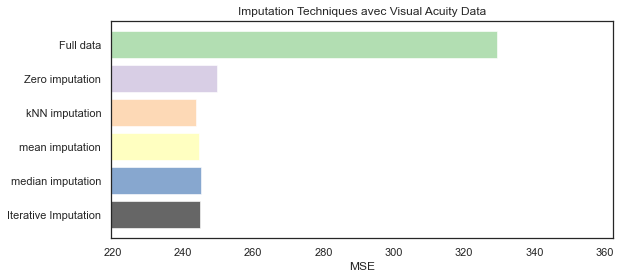

<Figure size 864x432 with 0 Axes>

In [588]:
import matplotlib.pyplot as plt

n_bars = len(mses_visual)
xval = np.arange(n_bars)

colors = [COLOR1, COLOR2, COLOR3, COLOR4,COLOR5, "black"]


# plot visual results

fig,ax1 = plt.subplots()
plt.figure(figsize=(12, 6))
for j in xval:
    ax1.barh(
        j,
        mses_visual[j],
        #xerr=stds_visual[j],
        color=colors[j],
        alpha=0.6,
        align="center"
    )

ax1.set_title("Imputation Techniques avec Visual Acuity Data")
ax1.set_xlim(left=np.min(mses_visual) * 0.9, right=np.max(mses_visual) * 1.1)
ax1.set_yticks(xval)
ax1.set_xlabel("MSE")
ax1.invert_yaxis()
ax1.set_yticklabels(x_labels)
plt.show()

Dans le cas ou nous avons eu 17% de valeurs manquantes dans le targer VA_2weeks, la methode pour faire l'imputing est kNN

### Imputer les valeurs manquantes

Il est important de diviser les données en train et en jeu de test AVANT, et non après, en appliquant des étapes d’ingénierie ou de sélection de fonctionnalités afin d’éviter les fuites de données

#### Séparation des données en ensembles d'entrainement (80%) et de test (20 %).

Maintenant que les données ont été nettoyées, on peut les séparer en un ensemble d'entrainement (qui va servir à entrainer le classifieur) et un ensemble de test (qui va permettre d'en mesurer les performances sur des données jamais rencontrées).

In [589]:
df.shape

(494, 14)

In [590]:
df_=df[~df['VA_2weeks'].isna()].copy()
df_null=df[df['VA_2weeks'].isna()].copy()
df_.shape,df_null.shape

((407, 14), (87, 14))

In [591]:
X=pd.DataFrame()
y=pd.DataFrame()

# Caractéristiques mesurées
X=df_.drop(['VA_2weeks','VA_3months','VA_6months','VA_12months','VA_2months'],axis=1)
#X.set_index('id',inplace=True)
X=encode_df(X)
#Reponses numeriques
y=df_[['VA_2weeks']]

# Liste des variables utilisées
feature_list = list(X.columns)

In [592]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape,y_train.shape ,y_test.shape

((325, 12), (82, 12), (325, 1), (82, 1))

In [593]:
X_train.set_index('id',inplace=True)
X_test.set_index('id',inplace=True)

In [594]:
X_train

age  pseudophakic  mh_duration  elevated_edge  mh_size  VA_baseline  \
id                                                                         
17    66             0            7              1      208           52   
124   63             0           -9              1      384           49   
141   71             0            2              1      657           48   
268   83             0           11              1      552           57   
253   74             0           10              1       -9           57   
..   ...           ...          ...            ...      ...          ...   
199   59             0            7              1      178           56   
241   82             0           10              1      608           10   
436   62             1            8              1      347           62   
34    64             0           10              1      112           68   
237   65             0            9              1      484           57   

     sex_2  ageGroup_50-60  ageGroup_60-70  ageGroup_70-80  ageGroup_80-plus  
id                                                                            
17       1               0               1               0                 0  
124      1               0               1               0                 0  
141      1               0               0               1                 0  
268      1               0               0               0                 1  
253      0               0               0               1                 0  
..     ...             ...             ...             ...               ...  
199      0               1               0               0                 0  
241      1               0               0               0                 1  
436      1               0               1               0                 0  
34       1               0               1               0                 0  
237      1               0               1               0                 0  

[325 rows x 11 columns]

In [595]:
X_train.columns

Index(['age', 'pseudophakic', 'mh_duration', 'elevated_edge', 'mh_size',
       'VA_baseline', 'sex_2', 'ageGroup_50-60', 'ageGroup_60-70',
       'ageGroup_70-80', 'ageGroup_80-plus'],
      dtype='object')

#### KNN-Imputer

In [596]:
list_colmn_null=[]
ind_liste_column_null=[]
list_colmn_null=['mh_duration', 'elevated_edge','mh_size', 'VA_baseline']
#filtre_missing=np.where((X_train['mh_duration']==-9)|(X_train['elevated_edge']==-9)|(X_train['mh_size']==-9)|(X_train['VA_baseline']==-9))
#print(filtre_missing)
#missing_samples=X_train.loc[filtre_missing]

In [597]:
imputer = KNNImputer()

In [598]:
# initialize imputer 
imputer = KNNImputer(missing_values=-9)

# fit the imputer on X_train. pass only numeric columns.
imputer.fit(X_train[list_colmn_null])

# transform the data using the fitted imputer
X_train_imp = imputer.transform(X_train[list_colmn_null])
X_test_imp = imputer.transform(X_test[list_colmn_null])

# put the output into DataFrame. remember to pass columns used in fit/transform
X_train_imp = pd.DataFrame(X_train_imp, columns=list_colmn_null).set_index(X_train.index)
X_test_imp = pd.DataFrame(X_test_imp,columns=list_colmn_null).set_index(X_test.index)

In [599]:
X_train_imp.shape,X_test_imp.shape

((325, 4), (82, 4))

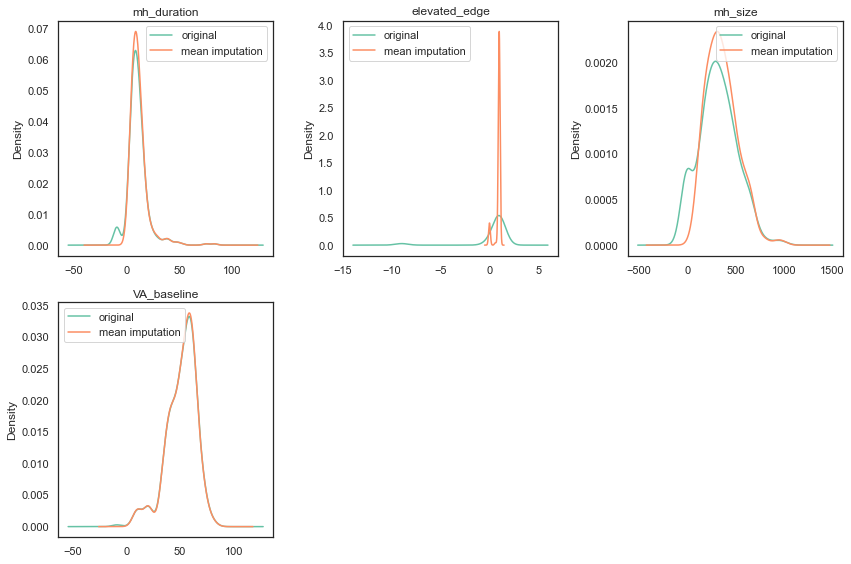

In [600]:
fig, axes = plt.subplots(figsize=(12, 8))
for i in range(len(list_colmn_null)):
    ax = plt.subplot(2, 3, i+1)
    col = list_colmn_null[i]
    
    X_train[col].plot.kde()
    X_train_imp[col].plot.kde()
    
    ax.set_title(col)
    ax.legend(['original', 'mean imputation'])
    
plt.tight_layout()

In [601]:
X_train_imp.describe()

mh_duration  elevated_edge      mh_size  VA_baseline
count   325.000000     325.000000   325.000000   325.000000
mean     11.671385       0.902769   359.624000    51.387692
std       9.199950       0.291270   165.337879    13.711214
min       1.000000       0.000000    50.000000    10.000000
25%       7.000000       1.000000   234.000000    43.000000
50%      10.000000       1.000000   336.000000    54.000000
75%      14.000000       1.000000   456.000000    61.000000
max      83.000000       1.000000  1001.000000    82.000000

In [602]:
X_test_imp.describe()

mh_duration  elevated_edge     mh_size  VA_baseline
count    82.000000      82.000000   82.000000    82.000000
mean     12.478049       0.907317  342.521951    50.963415
std      15.263828       0.283183  168.618599    16.072709
min       1.000000       0.000000   76.000000    10.000000
25%       6.000000       1.000000  215.000000    41.250000
50%       9.500000       1.000000  318.000000    55.500000
75%      13.000000       1.000000  444.500000    63.000000
max     122.000000       1.000000  900.000000    75.000000

In [603]:
X_train_imp['elevated_edge']=pd.Series(X_train_imp['elevated_edge']).round()
X_train_imp['elevated_edge'].value_counts()

1.0    295
0.0     30
Name: elevated_edge, dtype: int64

In [604]:
X_test_imp['elevated_edge']=pd.Series(X_test_imp['elevated_edge']).round()
X_test_imp['elevated_edge'].value_counts()

1.0    75
0.0     7
Name: elevated_edge, dtype: int64

In [605]:
X_train_ = X_train.drop(['mh_duration','elevated_edge','mh_size','VA_baseline'],axis=1)
X_test_  = X_test.drop(['mh_duration','elevated_edge','mh_size','VA_baseline'],axis=1)

In [606]:
index_list = X_train_.index
print(index_list)

Int64Index([ 17, 124, 141, 268, 253,  90, 191, 453, 362,  77,
            ...
            365, 256, 103, 143, 334, 199, 241, 436,  34, 237],
           dtype='int64', name='id', length=325)


In [607]:
#index_list = X_train_imp.set_index('id')
#print(index_list)

In [608]:
X_imp=pd.merge(X_train_,X_train_imp,how='inner',left_index=True,right_index=True)

X_imp_test=pd.merge(X_test_,X_test_imp,how='inner',left_index=True,right_index=True)

In [609]:
X_imp.describe()

age  pseudophakic       sex_2  ageGroup_50-60  ageGroup_60-70  \
count  325.000000    325.000000  325.000000      325.000000      325.000000   
mean    67.440000      0.215385    0.686154        0.132308        0.532308   
std      7.837091      0.411723    0.464770        0.339347        0.499725   
min     40.000000      0.000000    0.000000        0.000000        0.000000   
25%     63.000000      0.000000    0.000000        0.000000        0.000000   
50%     67.000000      0.000000    1.000000        0.000000        1.000000   
75%     72.000000      0.000000    1.000000        0.000000        1.000000   
max     92.000000      1.000000    1.000000        1.000000        1.000000   

       ageGroup_70-80  ageGroup_80-plus  mh_duration  elevated_edge  \
count      325.000000        325.000000   325.000000     325.000000   
mean         0.249231          0.061538    11.671385       0.907692   
std          0.433235          0.240686     9.199950       0.289906   
min          0.000000          0.000000     1.000000       0.000000   
25%          0.000000          0.000000     7.000000       1.000000   
50%          0.000000          0.000000    10.000000       1.000000   
75%          0.000000          0.000000    14.000000       1.000000   
max          1.000000          1.000000    83.000000       1.000000   

           mh_size  VA_baseline  
count   325.000000   325.000000  
mean    359.624000    51.387692  
std     165.337879    13.711214  
min      50.000000    10.000000  
25%     234.000000    43.000000  
50%     336.000000    54.000000  
75%     456.000000    61.000000  
max    1001.000000    82.000000

In [610]:
X_imp_test.describe()

age  pseudophakic      sex_2  ageGroup_50-60  ageGroup_60-70  \
count  82.000000     82.000000  82.000000       82.000000       82.000000   
mean   68.390244      0.170732   0.682927        0.097561        0.512195   
std     7.040897      0.378590   0.468200        0.298546        0.502927   
min    48.000000      0.000000   0.000000        0.000000        0.000000   
25%    65.000000      0.000000   0.000000        0.000000        0.000000   
50%    67.500000      0.000000   1.000000        0.000000        1.000000   
75%    72.750000      0.000000   1.000000        0.000000        1.000000   
max    91.000000      1.000000   1.000000        1.000000        1.000000   

       ageGroup_70-80  ageGroup_80-plus  mh_duration  elevated_edge  \
count       82.000000         82.000000    82.000000      82.000000   
mean         0.329268          0.048780    12.478049       0.914634   
std          0.472840          0.216734    15.263828       0.281145   
min          0.000000          0.000000     1.000000       0.000000   
25%          0.000000          0.000000     6.000000       1.000000   
50%          0.000000          0.000000     9.500000       1.000000   
75%          1.000000          0.000000    13.000000       1.000000   
max          1.000000          1.000000   122.000000       1.000000   

          mh_size  VA_baseline  
count   82.000000    82.000000  
mean   342.521951    50.963415  
std    168.618599    16.072709  
min     76.000000    10.000000  
25%    215.000000    41.250000  
50%    318.000000    55.500000  
75%    444.500000    63.000000  
max    900.000000    75.000000

In [611]:
X_imp_test.columns,X_imp.columns

(Index(['age', 'pseudophakic', 'sex_2', 'ageGroup_50-60', 'ageGroup_60-70',
        'ageGroup_70-80', 'ageGroup_80-plus', 'mh_duration', 'elevated_edge',
        'mh_size', 'VA_baseline'],
       dtype='object'),
 Index(['age', 'pseudophakic', 'sex_2', 'ageGroup_50-60', 'ageGroup_60-70',
        'ageGroup_70-80', 'ageGroup_80-plus', 'mh_duration', 'elevated_edge',
        'mh_size', 'VA_baseline'],
       dtype='object'))

### Regroupement de patients similaires en clusters à l’aide de KMeans.

C:\Users\daian\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



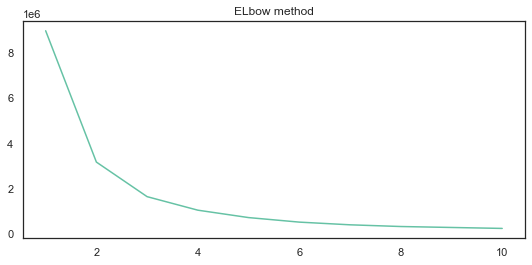

In [612]:
features=['age', 'pseudophakic', 'mh_duration', 'elevated_edge', 'mh_size', 'VA_baseline']
param=[]
for i in range(1,11):
    kmeans = KMeans(n_clusters= i, init = 'k-means++', random_state = 0)
    kmeans.fit(X_imp[features])
    param.append(kmeans.inertia_)
plt.plot(range(1,11), param)
plt.title("ELbow method")
plt.show()



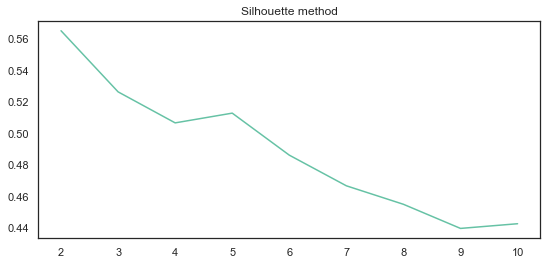

In [613]:
from sklearn.metrics import silhouette_score
tab_ind=[]
for i in range(2,11):
    kmeans = KMeans(n_clusters= i, init = 'k-means++', random_state = 0)
    label=kmeans.fit_predict(X_imp[features])
    tab_ind.append(silhouette_score(X_imp[features],label))
plt.plot(range(2,11), tab_ind)
plt.title("Silhouette method")
plt.show()

<ul style="font-family: times, serif; font-size:15pt; color:blue;">
l’indice de silhouette​ nous indique de prendre 2 clusters
</ul>

In [614]:
features=['age', 'pseudophakic', 'mh_duration', 'elevated_edge', 'mh_size', 'VA_baseline']
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_imp[features])
X_imp['patient_type'] = kmeans.predict(X_imp[features])


In [615]:
X_imp.head()

age  pseudophakic  sex_2  ageGroup_50-60  ageGroup_60-70  ageGroup_70-80  \
id                                                                              
17    66             0      1               0               1               0   
124   63             0      1               0               1               0   
141   71             0      1               0               0               1   
268   83             0      1               0               0               0   
253   74             0      0               0               0               1   

     ageGroup_80-plus  mh_duration  elevated_edge  mh_size  VA_baseline  \
id                                                                        
17                  0          7.0            1.0    208.0         52.0   
124                 0          8.4            1.0    384.0         49.0   
141                 0          2.0            1.0    657.0         48.0   
268                 1         11.0            1.0    552.0         57.0   
253                 0         10.0            1.0    451.0         57.0   

     patient_type  
id                 
17              1  
124             1  
141             0  
268             0  
253             0

In [616]:
features=['age', 'pseudophakic', 'mh_duration', 'elevated_edge', 'mh_size', 'VA_baseline']
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_imp_test[features])
X_imp_test['patient_type'] = kmeans.predict(X_imp_test[features])

In [617]:
X_imp_test

age  pseudophakic  sex_2  ageGroup_50-60  ageGroup_60-70  ageGroup_70-80  \
id                                                                              
198   81             0      0               0               0               0   
370   82             0      1               0               0               0   
418   64             1      1               0               1               0   
158   59             0      1               1               0               0   
167   65             0      0               0               1               0   
..   ...           ...    ...             ...             ...             ...   
221   52             0      1               1               0               0   
72    64             0      1               0               1               0   
27    66             0      1               0               1               0   
69    67             0      1               0               1               0   
43    67             0      1               0               1               0   

     ageGroup_80-plus  mh_duration  elevated_edge  mh_size  VA_baseline  \
id                                                                        
198                 1          7.0            1.0    321.6         49.0   
370                 1        122.0            1.0    455.0         21.0   
418                 0          5.0            1.0    432.0         56.0   
158                 0          5.0            1.0    705.0         10.0   
167                 0          5.0            1.0    276.2         53.0   
..                ...          ...            ...      ...          ...   
221                 0          8.0            1.0    229.0         65.0   
72                  0          2.0            1.0    240.0         40.0   
27                  0         10.0            1.0    262.0         57.0   
69                  0         10.0            1.0    712.0         10.0   
43                  0         18.0            0.0    202.0         36.0   

     patient_type  
id                 
198             1  
370             0  
418             0  
158             0  
167             1  
..            ...  
221             1  
72              1  
27              1  
69              0  
43              1  

[82 rows x 12 columns]

In [618]:
X_imp.to_csv("X_train.csv")
X_imp_test.to_csv("X_test.csv")
y_test.to_csv('y_test.csv')
y_train.to_csv('y_train.csv')

### Detecter les valeurs aberrantes forêt d'isolation

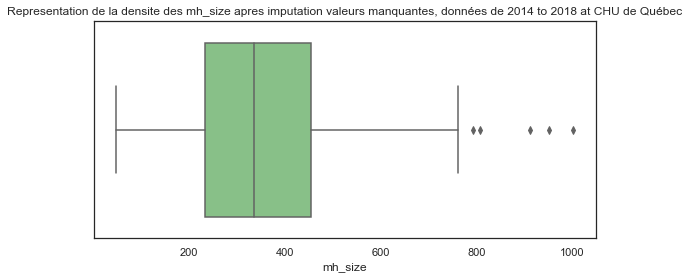

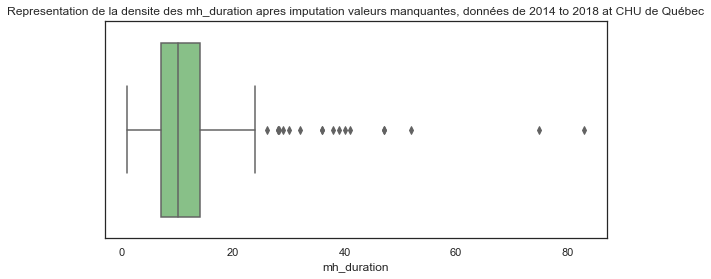

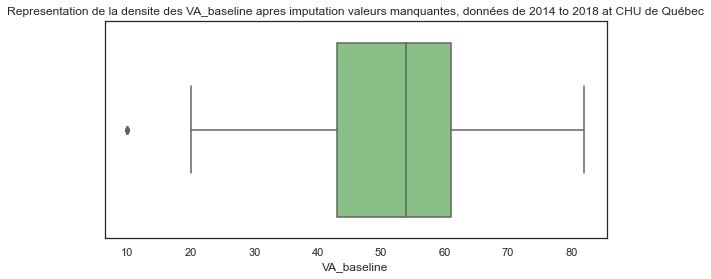

In [619]:
for feature in X_imp[['mh_size','mh_duration','VA_baseline']]:
    sns.boxplot(data=X_imp,
                x=feature,
                #shade=True,
                color=COLOR1
               )
    plt.xlabel(feature)
    plt.ylabel("")
    plt.title("Representation de la densite des "+feature+" apres imputation valeurs manquantes, données de 2014 to 2018 at CHU de Québec")
    plt.show()
    #plt.savefig("mygraph.png")

On voit dans les boxplots precedents qu'il y a des valeurs aberantes.

Dans ce qui suit, on va supposer, pour l'exemple, que la base de données contient 0,12% de valeurs aberrantes de toutes sortes. Ce n'est pas exagéré. Cela représente $0,15*373 \approx 5$ valeurs.

On utilise la méthode de la [forêt d'isolation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) pour détecter et éliminer un maximum de 0,12% des valeurs possiblement aberrantes. 

In [620]:
from sklearn.ensemble import IsolationForest

In [621]:
X_aut=X_imp[['mh_size','mh_duration','VA_baseline']].copy()


In [622]:
# Trouvons les valeurs aberrantes; la variable 'outlier' vaut -1 
# pour les valeurs aberrantes et +1 pour les autres.
outliers_fraction = 0.05
i_forest = IsolationForest(#n_estimators=100, 
                           max_samples=100,
                           contamination= outliers_fraction, 
                           bootstrap=True,
                           random_state=42)

X_aut['outliers'] = i_forest.fit(X_imp).predict(X_imp)
prediction=i_forest.fit(X_imp).predict(X_imp)
# Affichons les 15 premières données de la base de données
X_aut.head(5)

C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names

C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



mh_size  mh_duration  VA_baseline  outliers
id                                              
17     208.0          7.0         52.0         1
124    384.0          8.4         49.0         1
141    657.0          2.0         48.0         1
268    552.0         11.0         57.0         1
253    451.0         10.0         57.0         1

In [623]:
X_aut[((X_aut.outliers<0)|(X_aut.mh_duration<0))]

mh_size  mh_duration  VA_baseline  outliers
id                                              
472    609.0         16.0         48.0        -1
408    234.0          3.0         59.0        -1
75     627.0         75.0         10.0        -1
340    646.0         18.0         36.0        -1
32     232.0         18.0         79.0        -1
67     592.0         24.0         10.0        -1
437    512.0          9.0         20.0        -1
404    640.0         16.2         33.0        -1
22     451.0         17.0         41.0        -1
478    184.0         18.0         48.0        -1
459    145.0         12.0         72.0        -1
440    536.0          9.0         36.0        -1
412     64.0          4.0         68.0        -1
491    327.0         36.0         49.0        -1
465    950.0         14.0         20.0        -1
483    651.0         22.0         42.0        -1
241    608.0         10.0         10.0        -1

In [624]:
X_aut['outliers']=X_aut['outliers'].apply(str)

In [625]:
#sns.pairplot(data=X_aut,hue='outliers')
#plt.show()

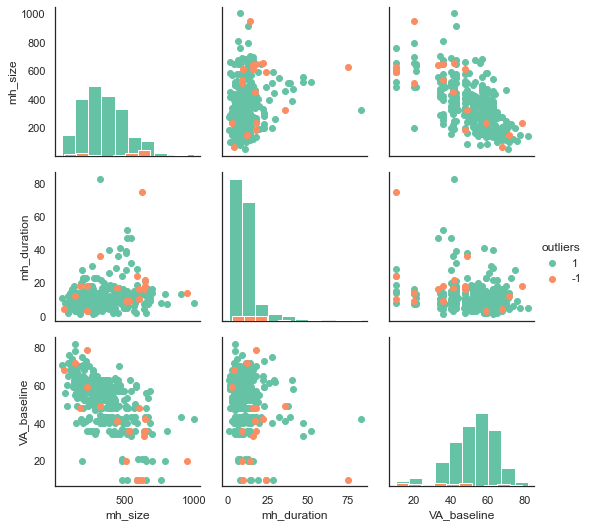

In [626]:
graph = sns.PairGrid(X_aut, hue ='outliers')
# type of graph for diagonal
graph = graph.map_diag(plt.hist)
# type of graph for non-diagonal
graph = graph.map_offdiag(plt.scatter)
# to add legends
graph = graph.add_legend()
# to show
plt.show()
# This code is contributed by Deepanshu Rusatgi.

## Préparer les données pour ML

Il y a quatre étapes.

1. Diviser les données en variables et entités cibles

2. Encode pour les variables qualitatives

3. Normalisation pour les variables continues

4. Mélange et fractionnement des données


#### Diviser les données en variables et entités cibles

In [627]:
X_imp_num=X_imp[['mh_duration','mh_size','VA_baseline']]
X_imp_test_num=X_imp_test[['mh_duration','mh_size','VA_baseline']]

#### Normalisation des données.

La dernière étape consiste à normaliser les données; on utilise la méthode [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). L'étape de 
normalisation a un très grand effet sur les performances des classifieurs. Certains classifieurs y sont insensibles, comme celui que nous allons utiliser, mais c'est une bonne habitude de l'utiliser par défaut.

On entraine la méthode de transformation avec les données d'entrainement et on l'applique ensuite aux données d'entrainement et de test.

In [628]:
scaler = RobustScaler()#MinMaxScaler()
scaler.fit(X_imp_num)
X_train_num_s = scaler.transform(X_imp_num)
X_test_num_s  = scaler.transform(X_imp_test_num)

df_train_num = pd.DataFrame(X_train_num_s, columns=X_imp_num.columns).set_index(X_train.index)
df_test_num = pd.DataFrame(X_test_num_s, columns=X_imp_test_num.columns).set_index(X_test.index)

df_train_num.describe()

mh_duration     mh_size  VA_baseline
count   325.000000  325.000000   325.000000
mean      0.238769    0.106414    -0.145128
std       1.314279    0.744765     0.761734
min      -1.285714   -1.288288    -2.444444
25%      -0.428571   -0.459459    -0.611111
50%       0.000000    0.000000     0.000000
75%       0.571429    0.540541     0.388889
max      10.428571    2.995495     1.555556

In [629]:
df_test_num.columns

Index(['mh_duration', 'mh_size', 'VA_baseline'], dtype='object')

In [630]:
X_imp.columns

Index(['age', 'pseudophakic', 'sex_2', 'ageGroup_50-60', 'ageGroup_60-70',
       'ageGroup_70-80', 'ageGroup_80-plus', 'mh_duration', 'elevated_edge',
       'mh_size', 'VA_baseline', 'patient_type'],
      dtype='object')

In [631]:
X_std_train = pd.DataFrame()
X_std_test  = pd.DataFrame()  
X_std_train = df_train_num.copy()
X_std_test  = df_test_num.copy() 

lst=['pseudophakic','patient_type', 'sex_2', 'ageGroup_50-60', 'ageGroup_60-70','ageGroup_70-80', 'ageGroup_80-plus']
for i in lst:
    X_std_train[i]=pd.array(X_imp[i])
    X_std_test[i]=pd.array(X_imp_test[i])

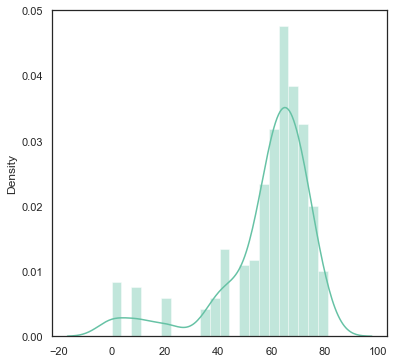

In [632]:
#y_train=pd.DataFrame(y_train,columns=['VA_2weeks'],index=X_train.index)
plt.figure(figsize=(6,6))
sns.distplot(y_train)
plt.show()

In [633]:
y_train.VA_2weeks.skew()

-1.79700665666866

In [634]:
y_train.shape

(325, 1)

In [635]:
y_train[y_train.VA_2weeks==80.0]

VA_2weeks
446       80.0
425       80.0

In [636]:
target_scaler =RobustScaler() #MinMaxScaler()
y_train_=y_train.values
y_test_=y_test.values

target_scaler.fit(y_train_)
# transform target variables
y_std_train = target_scaler.transform(y_train_)
y_std_test = target_scaler.transform(y_test_)

y_std_train = pd.DataFrame(y_std_train, columns=['VA_2weeks']).set_index(y_train.index)
y_std_test = pd.DataFrame(y_std_test, columns=['VA_2weeks']).set_index(y_test.index)


In [637]:
y_std_train.shape

(325, 1)

In [638]:
y_std_train.isna().sum()

VA_2weeks    0
dtype: int64

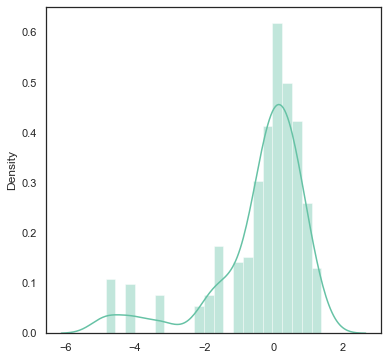

In [639]:
y_std_train=pd.DataFrame(y_std_train,columns=['VA_2weeks'])
plt.figure(figsize=(6,6))
sns.distplot(y_std_train)
plt.show()

In [640]:
X_std_train.columns,X_std_test.columns

(Index(['mh_duration', 'mh_size', 'VA_baseline', 'pseudophakic', 'patient_type',
        'sex_2', 'ageGroup_50-60', 'ageGroup_60-70', 'ageGroup_70-80',
        'ageGroup_80-plus'],
       dtype='object'),
 Index(['mh_duration', 'mh_size', 'VA_baseline', 'pseudophakic', 'patient_type',
        'sex_2', 'ageGroup_50-60', 'ageGroup_60-70', 'ageGroup_70-80',
        'ageGroup_80-plus'],
       dtype='object'))

In [641]:
X_std_train.shape, X_std_test.shape, y_std_test.shape, y_std_train.shape

((325, 10), (82, 10), (82, 1), (325, 1))

In [642]:
X_train_final,y_train_final=X_std_train,y_std_train
X_test_final,y_test_final=X_std_test,y_std_test

In [643]:
X_train_final.shape

(325, 10)

In [644]:
X_train_final.columns,X_test_final.columns

(Index(['mh_duration', 'mh_size', 'VA_baseline', 'pseudophakic', 'patient_type',
        'sex_2', 'ageGroup_50-60', 'ageGroup_60-70', 'ageGroup_70-80',
        'ageGroup_80-plus'],
       dtype='object'),
 Index(['mh_duration', 'mh_size', 'VA_baseline', 'pseudophakic', 'patient_type',
        'sex_2', 'ageGroup_50-60', 'ageGroup_60-70', 'ageGroup_70-80',
        'ageGroup_80-plus'],
       dtype='object'))

In [645]:
y_train_final.isna().sum()

VA_2weeks    0
dtype: int64

## Partie III: Entrainement d'un classifieur.


#### Sélection et entrainement du classifieur.


https://www.datatechnotes.com/2019/09/how-to-use-gridsearchcv-in-python.html

https://coderzcolumn.com/tutorials/machine-learning/model-evaluation-scoring-metrics-scikit-learn-sklearn

https://coderzcolumn.com/tutorials/machine-learning/model-evaluation-scoring-metrics-scikit-learn-sklearn


### GradientBoostingRegressor

https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae

https://www.datasciencelearner.com/gradient-boosting-hyperparameters-tuning/

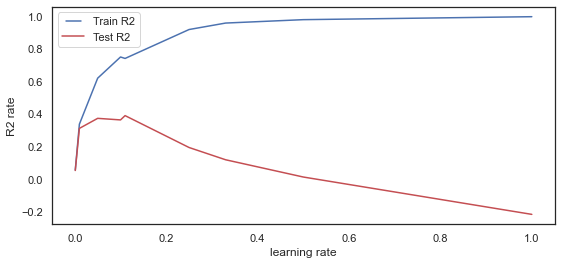

In [646]:
X_train_final,y_train_final=X_std_train,y_std_train.values.ravel()
X_test_final,y_test_final=X_std_test,y_std_test.values.ravel()
learning_rates = [0.001,0.01,0.05,0.1,0.11 ,0.25,0.33, 0.5 ,1]

train_results = []
test_results = []
for eta in learning_rates:
    model = GradientBoostingRegressor(learning_rate=eta,random_state=42)
    model.fit(X_train_final, y_train_final)
    train_pred = model.predict(X_train_final)
    train_results.append(model.score(X_train_final,y_train_final))
    ypred = model.predict(X_test_final)
    test_results.append(r2_score(y_test_final, ypred))

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_results, 'b', label="Train R2")
line2, = plt.plot(learning_rates, test_results, 'r', label="Test R2")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("R2 rate")
plt.xlabel("learning rate")
plt.show()    

Nous constatons que l’utilisation d’un taux d’apprentissage élevé entraîne un surapprentissage. Pour ces données, un taux d’apprentissage de 0,01 est optimal.

##### N_estimators

**n_estimators** représente le nombre d’arbres dans la forêt. Habituellement, plus le nombre d’arbres est élevé, mieux il est possible d’apprendre les données. Cependant, l’ajout de beaucoup d’arbres peut ralentir considérablement le processus d’entraînement, nous effectuons donc une recherche de paramètres pour trouver le point idéal.

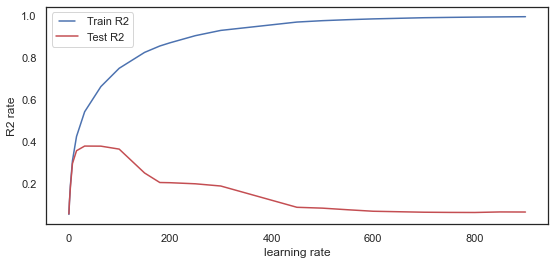

In [647]:
X_train_final,y_train_final=X_std_train,y_std_train.values.ravel()
X_test_final,y_test_final=X_std_test,y_std_test.values.ravel()
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 150,180,200,250,300,450,500,550,600,700,750,800,850,900]

train_results = []
test_results = []
for estimator in n_estimators:
    model = GradientBoostingRegressor(random_state=42,n_estimators=estimator)
    model.fit(X_train_final, y_train_final)
    train_pred = model.predict(X_train_final)
    
    train_results.append(model.score(X_train_final,y_train_final))
    ypred = model.predict(X_test_final)
    test_results.append(r2_score(y_test_final, ypred))

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train R2")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test R2")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("R2 rate")
plt.xlabel("learning rate")
plt.show()    

L’augmentation du nombre d’estimateurs peut également entraîner un surapprentissage. Dans notre cas, l’utilisation de 450 arbres est optimale.

##### max_depth

**max_depth**. Cela indique la profondeur de l’arbre construit. Plus l’arbre est profond, plus il a de divisions et il capture plus d’informations sur la façon dont les données. Nous ajustons un arbre de décision avec des profondeurs allant de 1 à 32 et traçons les erreurs d’entraînement et de test.

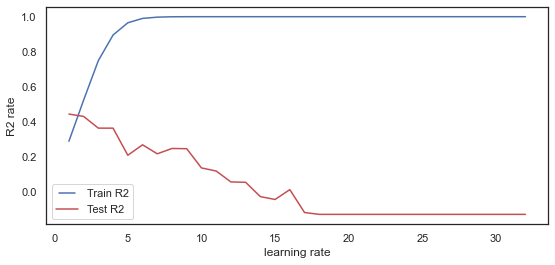

In [384]:
X_train_final,y_train_final=X_std_train,y_std_train.values.ravel()
X_test_final,y_test_final=X_std_test,y_std_test.values.ravel()

max_depths = np.linspace(1, 32, 32, endpoint=True)

train_results = []
test_results  = []

for max_depth in max_depths:
    model = GradientBoostingRegressor(random_state=42,max_depth=max_depth)
    model.fit(X_train_final, y_train_final)
    train_pred = model.predict(X_train_final)
    train_results.append(model.score(X_train_final,y_train_final))
    ypred = model.predict(X_test_final)
    test_results.append(r2_score(y_test_final, ypred))

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train R2")
line2, = plt.plot(max_depths, test_results, 'r', label="Test R2")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("R2 rate")
plt.xlabel("learning rate")
plt.show() 

Nous constatons que notre modèle s’adapte trop aux grandes valeurs de profondeur. L’arbre prédit parfaitement toutes les données du train, cependant, il ne parvient pas à généraliser les résultats pour les nouvelles données

##### min_samples_split

**min_samples_split** représente le nombre minimal d’échantillons requis pour fractionner un nœud interne. Cela peut varier entre la prise en compte d’au moins un échantillon à chaque nœud et la prise en compte de tous les échantillons à chaque nœud. Lorsque nous augmentons ce paramètre, l’arborescence devient plus contrainte car elle doit prendre en compte plus d’échantillons à chaque nœud. Ici, nous allons faire varier le paramètre de 10% à 100% des échantillons

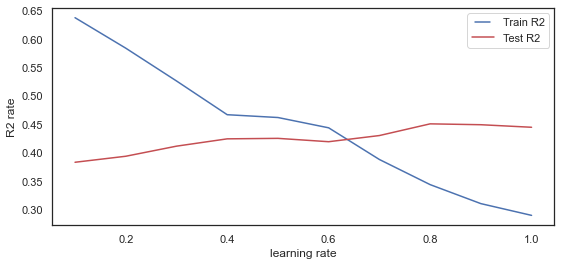

In [385]:
X_train_final,y_train_final=X_std_train,y_std_train.values.ravel()
X_test_final,y_test_final=X_std_test,y_std_test.values.ravel()

min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)

train_results = []
test_results  = []

for min_sample_split in min_samples_splits:
    model = GradientBoostingRegressor(random_state=42,min_samples_split=min_sample_split)
    model.fit(X_train_final, y_train_final)
    train_pred = model.predict(X_train_final)
    train_results.append(model.score(X_train_final,y_train_final))
    ypred = model.predict(X_test_final)
    test_results.append(r2_score(y_test_final, ypred))

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train R2")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test R2")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("R2 rate")
plt.xlabel("learning rate")
plt.show() 

Nous pouvons clairement voir que lorsque nous avons besoin de tous les échantillons à chaque nœud, le modèle ne peut pas en apprendre assez sur les données. Il s’agit d’un cas de sous-apprentissage.

##### min_samples_leaf

**min_samples_leaf** est Le nombre minimum d’échantillons requis pour se trouver à un nœud feuille. Ceci est similaire à min_samples_splits, cependant, cela décrit le nombre minimum d’échantillons d’échantillons au niveau des feuilles.

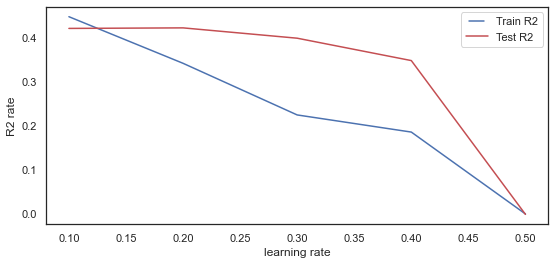

In [386]:
X_train_final,y_train_final=X_std_train,y_std_train.values.ravel()
X_test_final,y_test_final=X_std_test,y_std_test.values.ravel()

min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)

train_results = []
test_results  = []

for min_sample_split in min_samples_leafs:
    model = GradientBoostingRegressor(random_state=42,
                                      min_samples_leaf=min_sample_split)
    model.fit(X_train_final, y_train_final)
    train_pred = model.predict(X_train_final)
    train_results.append(model.score(X_train_final,y_train_final))
    ypred = model.predict(X_test_final)
    test_results.append(r2_score(y_test_final, ypred))

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train R2")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test R2")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("R2 rate")
plt.xlabel("learning rate")
plt.show() 

Même conclusion que pour le paramètre précédent. L’augmentation de cette valeur peut entraîner un sous-apprentissage.

##### max_features

max_features représente le nombre de variables à prendre en compte lors de la recherche de la meilleure division

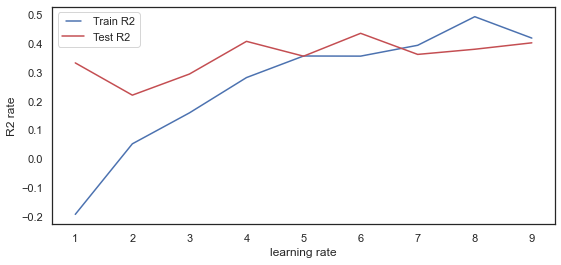

In [387]:
X_train_final,y_train_final=X_std_train,y_std_train.values.ravel()
X_test_final,y_test_final=X_std_test,y_std_test.values.ravel()

max_features = list(range(1,X_train_final.shape[1]))

train_results = []
test_results  = []

for max_feature in max_features:
    model = GradientBoostingRegressor( max_features=max_feature,random_state=rs)
    model.fit(X_train_final, y_train_final)
    train_pred = model.predict(X_train_final)
    
    train_results.append(r2_score(train_pred,y_train_final))
    ypred = model.predict(X_test_final)
    test_results.append(r2_score(y_test_final, ypred))

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label="Train R2")
line2, = plt.plot(max_features, test_results, 'r', label="Test R2")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("R2 rate")
plt.xlabel("learning rate")
plt.show() 

In [388]:
np.linspace(0.1, 1.0, 10, endpoint=True)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

R2: training: 0.561
R2: test: 0.409
MSE sur donnees de training: 135.12
MSE: sur donnees de test 244.74


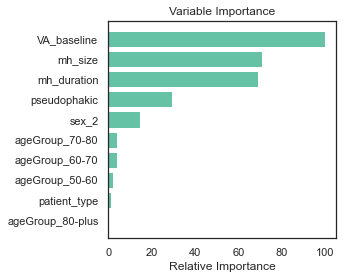

In [389]:
X_train_final,y_train_final=X_std_train,y_std_train.values.ravel()
X_test_final,y_test_final=X_std_test,y_std_test.values.ravel()

model = GradientBoostingRegressor(learning_rate=0.02, 
                                  max_depth=3,
                                  min_samples_split=0.04, 
                                  n_estimators=200,
                                  random_state=42)
model.fit(X_train_final, y_train_final)
train_pred = model.predict(X_train_final)
ypred = model.predict(X_test_final)

train_pred=np.round(target_scaler.inverse_transform(train_pred.reshape(-1, 1)),0)
y_train_final=target_scaler.inverse_transform(y_train_final.reshape(-1, 1))

ypred=target_scaler.inverse_transform(ypred.reshape(-1, 1))
y_test_final=target_scaler.inverse_transform(y_test_final.reshape(-1, 1))


print("R2: training:",np.round(r2_score(y_train_final,train_pred),3))
print("R2: test:",np.round(r2_score(y_test_final, ypred),3))

mse = mean_squared_error(train_pred,y_train_final)
print("MSE sur donnees de training: %.2f" % mse)

mse = mean_squared_error(ypred, y_test_final)
print("MSE: sur donnees de test %.2f" % mse)

# #############################################################################
# Plot feature importance
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_final.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

R2: training: 0.582
R2: test: 0.414
MSE sur donnees de training: 128.66
MSE: sur donnees de test 242.58


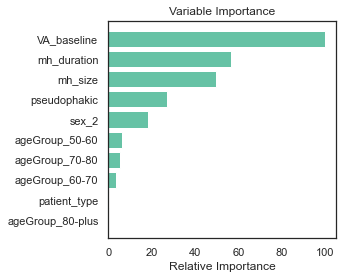

In [158]:
X_train_final,y_train_final=X_std_train,y_std_train.values.ravel()
X_test_final,y_test_final=X_std_test,y_std_test.values.ravel()

model = GradientBoostingRegressor(learning_rate=0.01, 
                                  max_depth=4,
                                  min_samples_split=0.01, 
                                  n_estimators=200,
                                  random_state=42)
model.fit(X_train_final, y_train_final)
train_pred = model.predict(X_train_final)
ypred = model.predict(X_test_final)

train_pred=np.round(target_scaler.inverse_transform(train_pred.reshape(-1, 1)),0)
y_train_final=target_scaler.inverse_transform(y_train_final.reshape(-1, 1))

ypred=target_scaler.inverse_transform(ypred.reshape(-1, 1))
y_test_final=target_scaler.inverse_transform(y_test_final.reshape(-1, 1))


print("R2: training:",np.round(r2_score(y_train_final,train_pred),3))
print("R2: test:",np.round(r2_score(y_test_final, ypred),3))

mse = mean_squared_error(train_pred,y_train_final)
print("MSE sur donnees de training: %.2f" % mse)

mse = mean_squared_error(ypred, y_test_final)
print("MSE: sur donnees de test %.2f" % mse)

# #############################################################################
# Plot feature importance
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_final.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [390]:
data = pd.DataFrame(data={"Predicted AV_2weeks": ypred.flatten(),"Initial AV_2weeks":y_test_final.flatten()})
print(data.head(98))

    Predicted AV_2weeks  Initial AV_2weeks
0             59.093008               70.0
1             38.549972               40.0
2             61.263086               67.0
3             59.400532               10.0
4             60.331704               62.0
..                  ...                ...
77            70.325562               60.0
78            55.944799               41.0
79            64.162549               50.0
80            53.056094               36.0
81            50.694768               60.0

[82 rows x 2 columns]


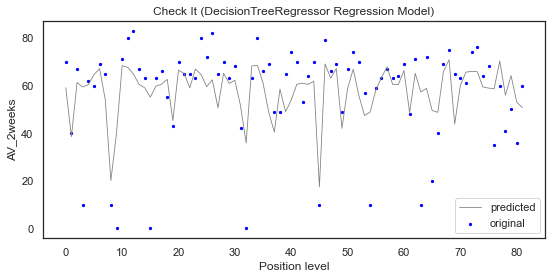

In [391]:
x=np.arange(0,len(X_test_final),1)
plt.scatter(x, y_test_final,  s=5,color = 'blue',label="original")
#5 Visualising the Decision Tree Regression results
#plt.scatter(X_std_train, y_train, color = 'red')
plt.plot(x, ypred,lw=0.8, color = 'gray',label="predicted")
plt.title('Check It (DecisionTreeRegressor Regression Model)')
plt.xlabel('Position level')
plt.ylabel('AV_2weeks')
plt.legend()
plt.show()

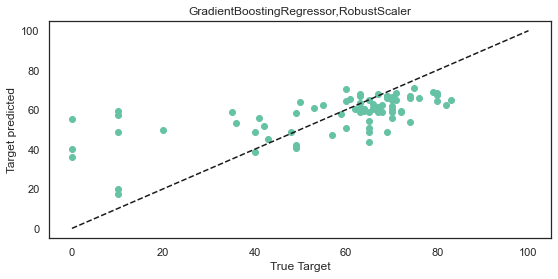

In [392]:
f, (ax0) = plt.subplots(1, 1, sharey=True)
ax0.scatter(y_test_final, ypred)
ax0.plot([0, 100], [0, 100], "--k")
ax0.set_ylabel("Target predicted")
ax0.set_xlabel("True Target")
plt.title('GradientBoostingRegressor,RobustScaler')
plt.show()

In [407]:
from lime.lime_tabular import LimeTabularExplainer

explainer=LimeTabularExplainer(X_train_final.to_numpy(),
                              feature_names=X_train_final.columns,
                              class_names=['VA_2weeks'],
                              mode='regression')

In [413]:
i = 4

exp = explainer.explain_instance(X_test_final.to_numpy()[i],model.predict, num_features=5)
exp.show_in_notebook(show_table=True)

C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but AdaBoostRegressor was fitted with feature names



Il nous indique que la prédiction de la 4 valeur de test est de -0.16, la valeur « sex = 2 » fournissant l’évaluation la plus positive et les autres caractéristiques fournissant une évaluation positives dans la prédiction.

### AdaBoostRegressor

{'learning_rate': 0.001, 'loss': 'square', 'n_estimators': 32}
AdaBoostRegressor(base_estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                           max_depth=4,
                                                           min_samples_split=0.01,
                                                           n_estimators=200,
                                                           random_state=42),
                  learning_rate=0.001, loss='square', n_estimators=32,
                  random_state=42)
MSE sur donnees de training: 130.11
R2: sur donnees de training: 0.60
MSE: sur donnees de test 241.32
R2 sur donnees de test: 0.42


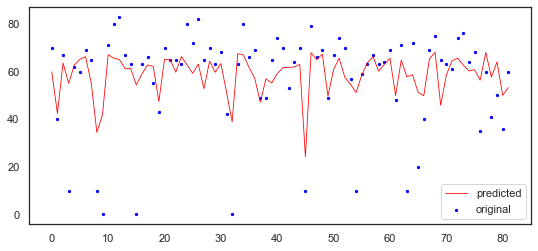

In [155]:
X_train_final,y_train_final=X_std_train,y_std_train.values.ravel()
X_test_final,y_test_final=X_std_test,y_std_test.values.ravel()

abreg = AdaBoostRegressor(base_estimator=GradientBoostingRegressor(learning_rate=0.01, 
                                  max_depth=4,
                                  min_samples_split=0.01, 
                                  n_estimators=200,
                                  random_state=42)
                          ,random_state=42)
params = {
 'n_estimators': [16, 32, 64, 100],#, 150,180,200,250,300,450],
 'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01,0.001],
 'loss' : ['linear', 'square', 'exponential']
 }

score = make_scorer(mean_squared_error)

gridsearch = GridSearchCV(abreg, params, cv=5, return_train_score=True)
gridsearch.fit(X_train_final, y_train_final)
print(gridsearch.best_params_)

best_estim=gridsearch.best_estimator_
print(best_estim)

best_estim.fit(X_train_final,y_train_final)

ytr_pred=best_estim.predict(X_train_final)

# invert transform on predictions
ytr_pred=target_scaler.inverse_transform(ytr_pred.reshape(-1, 1))
y_train_final=target_scaler.inverse_transform(y_train_final.reshape(-1, 1))

mse = mean_squared_error(ytr_pred,y_train_final)
r2 = r2_score(ytr_pred,y_train_final)
print("MSE sur donnees de training: %.2f" % mse)
print("R2: sur donnees de training: %.2f" % -r2)

ypred=best_estim.predict(X_test_final)

ypred=target_scaler.inverse_transform(ypred.reshape(-1, 1))
y_test_final=target_scaler.inverse_transform(y_test_final.reshape(-1, 1))

mse = mean_squared_error(y_test_final, ypred)
r2 = r2_score(y_test_final, ypred)
print("MSE: sur donnees de test %.2f" % mse)
print("R2 sur donnees de test: %.2f" % r2)

x_ax = range(len(y_test_final))
plt.scatter(x_ax, y_test_final, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()
 

In [757]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [1071]:
#display(gridsearch)

In [411]:
X_train_final,y_train_final=X_std_train,y_std_train.values.ravel()
X_test_final,y_test_final=X_std_test,y_std_test.values.ravel()


model=AdaBoostRegressor(base_estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                           max_depth=5,
                                                           min_samples_leaf=0.1,
                                                           min_samples_split=0.1,
                                                           n_estimators=800,
                                                           random_state=42),
                  learning_rate=0.001, n_estimators=32, random_state=42)
model.fit(X_train_final,y_train_final)
prediction_train=model.predict(X_train_final)
prediction_test=model.predict(X_test_final)

prediction_train=target_scaler.inverse_transform(prediction_train.reshape(-1, 1))
prediction_test=target_scaler.inverse_transform(prediction_test.reshape(-1, 1))

y_test_final=target_scaler.inverse_transform(y_test_final.reshape(-1,1))
y_train_final=target_scaler.inverse_transform(y_train_final.reshape(-1,1))


print('Test R^2 : %.3f'%r2_score(y_test_final, prediction_test))
print('Train R^2 : %.3f'%r2_score(y_train_final, prediction_train))

mse = mean_squared_error(prediction_train,y_train_final)
print("MSE sur donnees de training: %.2f" % mse)
mse = mean_squared_error(y_test_final, prediction_test)
print("MSE: sur donnees de test %.2f" % mse)

prediction_train
data = pd.DataFrame(data={"Predicted AV_2weeks": ypred.flatten(),"Initial AV_2weeks":y_test_final.flatten()})
print(data.head(98))

Test R^2 : 0.441
Train R^2 : 0.485
MSE sur donnees de training: 158.54
MSE: sur donnees de test 231.16
    Predicted AV_2weeks  Initial AV_2weeks
0             59.093008               70.0
1             38.549972               40.0
2             61.263086               67.0
3             59.400532               10.0
4             60.331704               62.0
..                  ...                ...
77            70.325562               60.0
78            55.944799               41.0
79            64.162549               50.0
80            53.056094               36.0
81            50.694768               60.0

[82 rows x 2 columns]


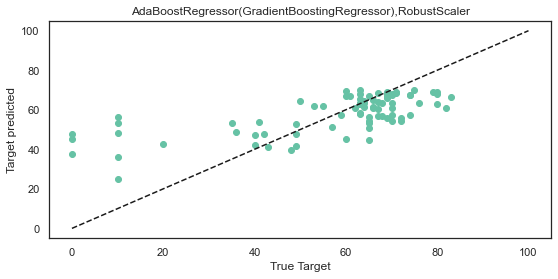

In [412]:
f, (ax0) = plt.subplots(1, 1, sharey=True)
ax0.scatter(y_test_final, prediction_test)
ax0.plot([0, 100], [0, 100], "--k")
ax0.set_ylabel("Target predicted")
ax0.set_xlabel("True Target")
plt.title('AdaBoostRegressor(GradientBoostingRegressor),RobustScaler')
plt.show()

In [164]:
X_train_final,y_train_final=X_std_train,y_std_train.values.ravel()
X_test_final,y_test_final=X_std_test,y_std_test.values.ravel()


model=AdaBoostRegressor(base_estimator=GradientBoostingRegressor(learning_rate=0.01, 
                                  max_depth=4,
                                  min_samples_split=0.01, 
                                  n_estimators=200,
                                  random_state=42),
                  learning_rate=0.001, n_estimators=32, random_state=42)
model.fit(X_train_final,y_train_final)
prediction_train=model.predict(X_train_final)
prediction_test=model.predict(X_test_final)

prediction_train=target_scaler.inverse_transform(prediction_train.reshape(-1, 1))
prediction_test=target_scaler.inverse_transform(prediction_test.reshape(-1, 1))

y_test_final=target_scaler.inverse_transform(y_test_final.reshape(-1,1))
y_train_final=target_scaler.inverse_transform(y_train_final.reshape(-1,1))


print('Test R^2 : %.3f'%r2_score(y_test_final, prediction_test))
print('Train R^2 : %.3f'%r2_score(y_train_final, prediction_train))

mse = mean_squared_error(prediction_train,y_train_final)
print("MSE sur donnees de training: %.2f" % mse)
mse = mean_squared_error(y_test_final, prediction_test)
print("MSE: sur donnees de test %.2f" % mse)

prediction_train
data = pd.DataFrame(data={"Predicted AV_2weeks": ypred.flatten(),"Initial AV_2weeks":y_test_final.flatten()})
print(data.head(98))

Test R^2 : 0.409
Train R^2 : 0.563
MSE sur donnees de training: 134.62
MSE: sur donnees de test 244.50
    Predicted AV_2weeks  Initial AV_2weeks
0             60.358235               70.0
1             44.400622               40.0
2             61.160099               67.0
3             55.276424               10.0
4             61.552533               62.0
..                  ...                ...
77            66.544232               60.0
78            54.635911               41.0
79            64.199468               50.0
80            50.386828               36.0
81            53.452260               60.0

[82 rows x 2 columns]


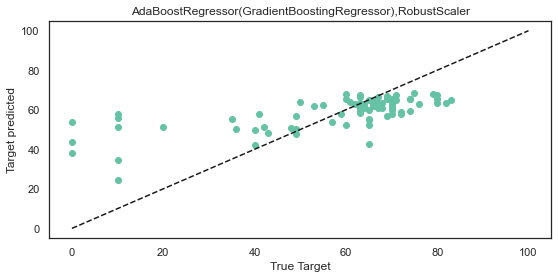

In [165]:
f, (ax0) = plt.subplots(1, 1, sharey=True)
ax0.scatter(y_test_final, prediction_test)
ax0.plot([0, 100], [0, 100], "--k")
ax0.set_ylabel("Target predicted")
ax0.set_xlabel("True Target")
plt.title('AdaBoostRegressor(GradientBoostingRegressor),RobustScaler')
plt.show()

### Robust Regression

#### Huber Regression

Pour les valeurs aberrantes dans un jeu de données et leur attribue moins de poids que les autres exemples de l’ensemble de données.

{'alpha': 1.75, 'epsilon': 2.25, 'max_iter': 5}
HuberRegressor(alpha=1.75, epsilon=2.25, max_iter=5)
MSE: sur donnees de test 263.40
R2 sur donnees de test: 0.36
MSE: sur donnees de training 237.01
R2 sur donnees de training: 0.23
    Predicted AV_2weeks  Initial AV_2weeks
0                  59.0               70.0
1                  -2.0               40.0
2                  63.0               67.0
3                  46.0               10.0
4                  64.0               62.0
..                  ...                ...
77                 70.0               60.0
78                 63.0               41.0
79                 65.0               50.0
80                 43.0               36.0
81                 54.0               60.0

[82 rows x 2 columns]


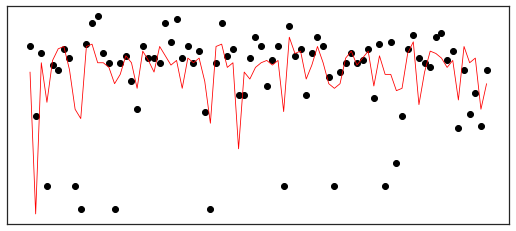

In [159]:
X_train_final,y_train_final=X_std_train,y_std_train.values.ravel()
X_test_final,y_test_final=X_std_test,y_std_test.values.ravel()

# ---------------define the model----------------------------------------------
abreg = HuberRegressor()
params = {
 'epsilon'  : [1,1.35, 1.5, 1.75,1.8,1.85, 1.9,2.00,2.25],#,2.50,2.75,3.00,3.25,3.50,3.75],
 'alpha'    : [0.0001,0.001,0.01,0.1,0.9,0.11,0.25,0.50,0.75,1.00,1.25,1.50,1.75],
 'max_iter' : [5,10,30,50,100,200,300,350]
 }

#---------train the model------------------------------------------------------
score = make_scorer(mean_squared_error)

gridsearch = GridSearchCV(abreg, params, cv=5, return_train_score=True)
gridsearch.fit(X_train_final, y_train_final)
print(gridsearch.best_params_)

model=gridsearch.best_estimator_
print(model)
model.fit(X_train_final,y_train_final)

#------------------prediction-------------------------------------------------

#print('R2 donnees de train:',np.round(model.score(X_train_final,y_train_final),4))

prediction_train=model.predict(X_train_final)
ypred=model.predict(X_test_final)

# ------inverse operation de scaling--------------------------------------------

prediction_train = np.round(target_scaler.inverse_transform(prediction_train.reshape(-1, 1)),0)
y_train_final    = target_scaler.inverse_transform(y_train_final.reshape(-1,1))

ypred        = np.round(target_scaler.inverse_transform(ypred.reshape(-1, 1)),0)
y_test_final = target_scaler.inverse_transform(y_test_final.reshape(-1,1))

#------------------metrics-------------------------------------------------------
mse = mean_squared_error(y_test_final, ypred)
r2 = r2_score(y_test_final, ypred)

mse_t = mean_squared_error(prediction_train,y_train_final)
r2_t = r2_score(y_train_final, prediction_train)

print("MSE: sur donnees de test %.2f" % mse)
print("R2 sur donnees de test: %.2f" % r2)

print("MSE: sur donnees de training %.2f" % mse_t)
print("R2 sur donnees de training: %.2f" % r2_t)
# -----------------difference valeurs predite et reele---------------------------

data = pd.DataFrame(data={"Predicted AV_2weeks": ypred.flatten(),"Initial AV_2weeks":y_test_final.flatten()})
print(data.head(98))


x_ax = range(len(y_test_final))
plt.scatter(x_ax, y_test_final, color="black",label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")

plt.xticks(())
plt.yticks(())

plt.show()

In [938]:
X_train_final,y_train_final=X_std_train,y_std_train.values.ravel()
X_test_final,y_test_final=X_std_test,y_std_test.values.ravel()


model=HuberRegressor(alpha=1.75, epsilon=2.25, max_iter=5)
model.fit(X_train_final,y_train_final)
prediction_train=model.predict(X_train_final)
prediction_test=model.predict(X_test_final)

prediction_train=target_scaler.inverse_transform(prediction_train.reshape(-1, 1))
prediction_test=target_scaler.inverse_transform(prediction_test.reshape(-1, 1))

y_test_final=target_scaler.inverse_transform(y_test_final.reshape(-1,1))
y_train_final=target_scaler.inverse_transform(y_train_final.reshape(-1,1))


print('Test R^2 : %.3f'%r2_score(y_test_final, prediction_test))
print('Test R^2 : %.3f'%r2_score(y_train_final, prediction_train))

mse = mean_squared_error(prediction_train,y_train_final)
print("MSE sur donnees de training: %.2f" % mse)
mse = mean_squared_error(y_test_final, prediction_test)
print("MSE: sur donnees de test %.2f" % mse)

prediction_train
data = pd.DataFrame(data={"Predicted AV_2weeks": ypred.flatten(),"Initial AV_2weeks":y_test_final.flatten()})
print(data.head(98))

Test R^2 : 0.371
Test R^2 : 0.233
MSE sur donnees de training: 236.13
MSE: sur donnees de test 260.24
    Predicted AV_2weeks  Initial AV_2weeks
0             60.358235               70.0
1             44.400622               40.0
2             61.160099               67.0
3             55.276424               10.0
4             61.552533               62.0
..                  ...                ...
77            66.544232               60.0
78            54.323557               41.0
79            64.199468               50.0
80            50.386828               36.0
81            53.452260               60.0

[82 rows x 2 columns]


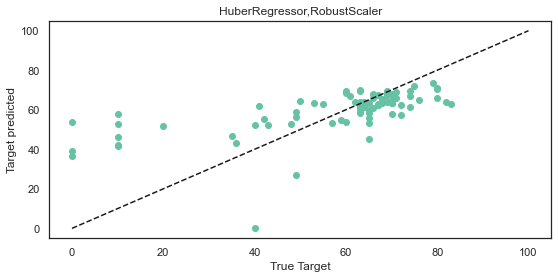

In [939]:
f, (ax0) = plt.subplots(1, 1, sharey=True)
ax0.scatter(y_test_final, prediction_test)
ax0.plot([0, 100], [0, 100], "--k")
ax0.set_ylabel("Target predicted")
ax0.set_xlabel("True Target")
plt.title('HuberRegressor,RobustScaler')
plt.show()

In [940]:
y_std_test['VA_2weeks']

77     0.538462
249   -1.769231
297    0.307692
37    -4.076923
46    -0.076923
         ...   
100   -0.230769
462   -1.692308
417   -1.000000
459   -2.076923
433   -0.230769
Name: VA_2weeks, Length: 82, dtype: float64

#### Support Vector Machime

{'C': 1, 'degree': 1, 'gamma': 'auto', 'kernel': 'rbf'}
SVR(C=1, degree=1, gamma='auto')
MSE: sur donnees de test 270.24
R2 sur donnees de test: 0.35
MSE: sur donnees de training 235.74
R2 sur donnees de training: 0.23
    Predicted AV_2weeks  Initial AV_2weeks
0                  61.0               70.0
1                  49.0               40.0
2                  65.0               67.0
3                  56.0               10.0
4                  66.0               62.0
..                  ...                ...
77                 69.0               60.0
78                 60.0               41.0
79                 65.0               50.0
80                 55.0               36.0
81                 55.0               60.0

[82 rows x 2 columns]


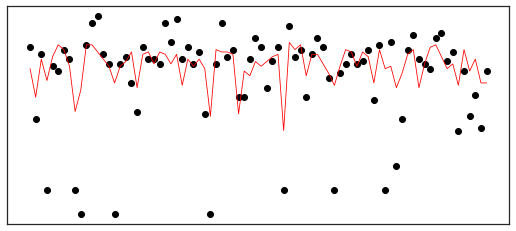

In [163]:
X_train_final, y_train_final                         = X_std_train,y_std_train.values.ravel()
X_test_final,y_test_final   = X_std_test, y_std_test.values.ravel()

param_grid = {'C': [0.1, 1,1.5,2,2.5,5, 10, 100, 1000,1500],
              'degree' : [1,2,3,8],
              #'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'gamma' : ['auto','scale'],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
 
#---------train the model------------------------------------------------------
score = make_scorer(mean_squared_error)
grid = GridSearchCV(SVR(), param_grid, 
                        cv = 10,
                        n_jobs= -1,
                       return_train_score=True)
grid.fit(X_train_final, y_train_final)
print(grid.best_params_)

model=grid.best_estimator_
print(model)
model.fit(X_train_final,y_train_final)

#------------------prediction-------------------------------------------------

#print('R2 donnees de train:',np.round(model.score(X_train_final,y_train_final),4))

prediction_train=model.predict(X_train_final)
ypred=model.predict(X_test_final)

# ------inverse operation de scaling--------------------------------------------

prediction_train = np.round(target_scaler.inverse_transform(prediction_train.reshape(-1, 1)),0)
y_train_final    = target_scaler.inverse_transform(y_train_final.reshape(-1,1))

ypred        = np.round(target_scaler.inverse_transform(ypred.reshape(-1, 1)),0)
y_test_final = target_scaler.inverse_transform(y_test_final.reshape(-1,1))

#------------------metrics-------------------------------------------------------
mse = mean_squared_error(y_test_final, ypred)
r2 = r2_score(y_test_final, ypred)

mse_t = mean_squared_error(prediction_train,y_train_final)
r2_t = r2_score(y_train_final, prediction_train)

print("MSE: sur donnees de test %.2f" % mse)
print("R2 sur donnees de test: %.2f" % r2)

print("MSE: sur donnees de training %.2f" % mse_t)
print("R2 sur donnees de training: %.2f" % r2_t)
# -----------------difference valeurs predite et reele---------------------------

data = pd.DataFrame(data={"Predicted AV_2weeks": ypred.flatten(),"Initial AV_2weeks":y_test_final.flatten()})
print(data.head(98))


x_ax = range(len(y_test_final))
plt.scatter(x_ax, y_test_final, color="black",label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")

plt.xticks(())
plt.yticks(())

plt.show()

In [164]:
X_train_final,y_train_final=X_std_train,y_std_train.values.ravel()
X_test_final,y_test_final=X_std_test,y_std_test.values.ravel()


model=SVR(C=1, degree=1, gamma='auto')
model.fit(X_train_final,y_train_final)
prediction_train=model.predict(X_train_final)
prediction_test=model.predict(X_test_final)

prediction_train=target_scaler.inverse_transform(prediction_train.reshape(-1, 1))
prediction_test=target_scaler.inverse_transform(prediction_test.reshape(-1, 1))

y_test_final=target_scaler.inverse_transform(y_test_final.reshape(-1,1))
y_train_final=target_scaler.inverse_transform(y_train_final.reshape(-1,1))


print('Test R^2 : %.3f'%r2_score(y_test_final, prediction_test))
print('Test R^2 : %.3f'%r2_score(y_train_final, prediction_train))

mse = mean_squared_error(prediction_train,y_train_final)
print("MSE sur donnees de training: %.2f" % mse)
mse = mean_squared_error(y_test_final, prediction_test)
print("MSE: sur donnees de test %.2f" % mse)

prediction_train
data = pd.DataFrame(data={"Predicted AV_2weeks": ypred.flatten(),"Initial AV_2weeks":y_test_final.flatten()})
print(data.head(98))

Test R^2 : 0.346
Test R^2 : 0.234
MSE sur donnees de training: 235.89
MSE: sur donnees de test 270.71
    Predicted AV_2weeks  Initial AV_2weeks
0                  61.0               70.0
1                  49.0               40.0
2                  65.0               67.0
3                  56.0               10.0
4                  66.0               62.0
..                  ...                ...
77                 69.0               60.0
78                 60.0               41.0
79                 65.0               50.0
80                 55.0               36.0
81                 55.0               60.0

[82 rows x 2 columns]


#### Passive Aggressive Regression in Machine

PassiveAggressiveRegressor(C=0.005, max_iter=100, random_state=200,
                           warm_start=1)
MSE: sur donnees de test 297.50
R2 sur donnees de test: 0.28
MSE: sur donnees de training 256.31
R2 sur donnees de training: 0.17
    Predicted AV_2weeks  Initial AV_2weeks
0                  61.0               70.0
1                  -7.0               40.0
2                  66.0               67.0
3                  51.0               10.0
4                  67.0               62.0
..                  ...                ...
77                 69.0               60.0
78                 64.0               41.0
79                 65.0               50.0
80                 48.0               36.0
81                 55.0               60.0

[82 rows x 2 columns]


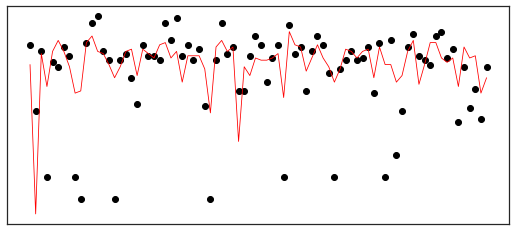

In [165]:
X_train_final,y_train_final = X_std_train,y_std_train.values.ravel()
X_test_final,y_test_final   = X_std_test, y_std_test.values.ravel()

param_grid = {'C': [0.001,0.005,0.0025,0.1, 1,5, 10, 100, 1000,1500],
              'max_iter' : [100,200,500,1000,1500,2000],
              'random_state' : [10,22,42,50,55,60,88,90,100,120,130,200,300,400],
              'warm_start':[1,10,20,30,40],
              
             }
 
grid = GridSearchCV(PassiveAggressiveRegressor(), param_grid, 
                        cv = 5,
                                     return_train_score=True)
 
# fitting the model for grid search
grid.fit(X_train_final,y_train_final)
model=grid.best_estimator_
print(model)
model.fit(X_train_final,y_train_final)

#------------------prediction-------------------------------------------------

#print('R2 donnees de train:',np.round(model.score(X_train_final,y_train_final),4))

prediction_train=model.predict(X_train_final)
ypred=model.predict(X_test_final)

# ------inverse operation de scaling--------------------------------------------

prediction_train = np.round(target_scaler.inverse_transform(prediction_train.reshape(-1, 1)),0)
y_train_final    = target_scaler.inverse_transform(y_train_final.reshape(-1,1))

ypred        = np.round(target_scaler.inverse_transform(ypred.reshape(-1, 1)),0)
y_test_final = target_scaler.inverse_transform(y_test_final.reshape(-1,1))

#------------------metrics-------------------------------------------------------
mse = mean_squared_error(y_test_final, ypred)
r2 = r2_score(y_test_final, ypred)

mse_t = mean_squared_error(prediction_train,y_train_final)
r2_t = r2_score(y_train_final, prediction_train)

print("MSE: sur donnees de test %.2f" % mse)
print("R2 sur donnees de test: %.2f" % r2)

print("MSE: sur donnees de training %.2f" % mse_t)
print("R2 sur donnees de training: %.2f" % r2_t)
# -----------------difference valeurs predite et reele---------------------------

data = pd.DataFrame(data={"Predicted AV_2weeks": ypred.flatten(),"Initial AV_2weeks":y_test_final.flatten()})
print(data.head(98))


x_ax = range(len(y_test_final))
plt.scatter(x_ax, y_test_final, color="black",label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")

plt.xticks(())
plt.yticks(())

plt.show()


Text(0.5, 1.0, 'Passive Aggressive Regression in Machine/RobustScaler')

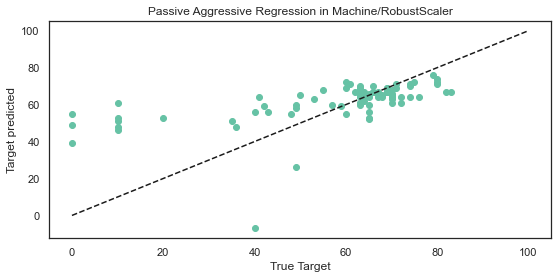

In [166]:
f, (ax0) = plt.subplots(1, 1, sharey=True)
ax0.scatter(y_test_final, ypred)
ax0.plot([0, 100], [0, 100], "--k")
ax0.set_ylabel("Target predicted")
ax0.set_xlabel("True Target")
plt.title('Passive Aggressive Regression in Machine/RobustScaler')

In [168]:
X_train_final,y_train_final = X_std_train,y_std_train.values.ravel()
X_test_final,y_test_final   = X_std_test, y_std_test.values.ravel()

model = PassiveAggressiveRegressor(C=0.005, max_iter=100, random_state=42,
                           warm_start=1)
model.fit(X_train_final,y_train_final)

prediction_train=model.predict(X_train_final)
ypred=model.predict(X_test_final)
# ------inverse operation de scaling--------------------------------------------

prediction_train = np.round(target_scaler.inverse_transform(prediction_train.reshape(-1, 1)),0)
y_train_final    = target_scaler.inverse_transform(y_train_final.reshape(-1,1))

ypred        = np.round(target_scaler.inverse_transform(ypred.reshape(-1, 1)),0)
y_test_final = target_scaler.inverse_transform(y_test_final.reshape(-1,1))

#------------------metrics-------------------------------------------------------
mse = mean_squared_error(y_test_final, ypred)
r2 = r2_score(y_test_final, ypred)

mse_t = mean_squared_error(prediction_train,y_train_final)
r2_t = r2_score(y_train_final, prediction_train)

print("MSE: sur donnees de test %.2f" % mse)
print("R2 sur donnees de test: %.2f" % r2)

print("MSE: sur donnees de training %.2f" % mse_t)
print("R2 sur donnees de training: %.2f" % r2_t)
# -----------------difference valeurs predite et reele---------------------------

data = pd.DataFrame(data={"Predicted AV_2weeks": ypred.flatten(),"Initial AV_2weeks":y_test_final.flatten()})
print(data.head(98))


MSE: sur donnees de test 279.82
R2 sur donnees de test: 0.32
MSE: sur donnees de training 250.61
R2 sur donnees de training: 0.19
    Predicted AV_2weeks  Initial AV_2weeks
0                  61.0               70.0
1                  -4.0               40.0
2                  65.0               67.0
3                  48.0               10.0
4                  67.0               62.0
..                  ...                ...
77                 69.0               60.0
78                 62.0               41.0
79                 64.0               50.0
80                 46.0               36.0
81                 54.0               60.0

[82 rows x 2 columns]


In [ ]:
X_imp,y_train
X_imp_test,y_test


Rencontré « le plateau » : peu importe combien vous nettoyez vos données, peu importe à quel point vous optimisez davantage vos paramètres, peu importe combien vous concevez de fonctionnalités supplémentaires, vos mesures de performance ne s’amélioreront pas.

L’hétéroskédasticité résulte généralement du fait qu’un ou plusieurs des prédicteurs ne sont pas normalement distribués, ou que la variable cible elle-même n’est pas normalement distribuée.

PowerTransformer est un moyen de corriger algorithmiquement ce problème; son objectif est d’obtenir une loi normale pour la variable donnée 

### Quantile Transformer

In [166]:
X_imp.head()

age  pseudophakic  sex_2  ageGroup_50-60  ageGroup_60-70  ageGroup_70-80  \
id                                                                              
17    66             0      1               0               1               0   
124   63             0      1               0               1               0   
141   71             0      1               0               0               1   
268   83             0      1               0               0               0   
253   74             0      0               0               0               1   

     ageGroup_80-plus  mh_duration  elevated_edge  mh_size  VA_baseline  \
id                                                                        
17                  0          7.0            1.0    208.0         52.0   
124                 0          8.4            1.0    384.0         49.0   
141                 0          2.0            1.0    657.0         48.0   
268                 1         11.0            1.0    552.0         57.0   
253                 0         10.0            1.0    451.0         57.0   

     patient_type  
id                 
17              0  
124             0  
141             1  
268             1  
253             1

In [167]:
y_test

VA_2weeks
77        70.0
249       40.0
297       67.0
37        10.0
46        62.0
..         ...
100       60.0
462       41.0
417       50.0
459       36.0
433       60.0

[82 rows x 1 columns]

In [159]:
X_imp.columns

Index(['age', 'pseudophakic', 'sex_2', 'ageGroup_50-60', 'ageGroup_60-70',
       'ageGroup_70-80', 'ageGroup_80-plus', 'mh_duration', 'elevated_edge',
       'mh_size', 'VA_baseline', 'patient_type'],
      dtype='object')

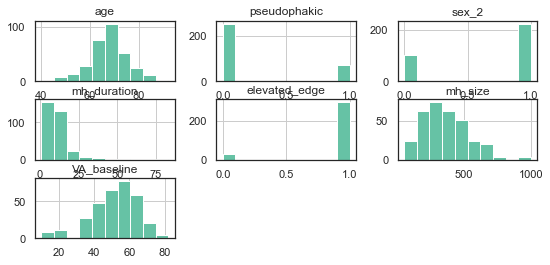

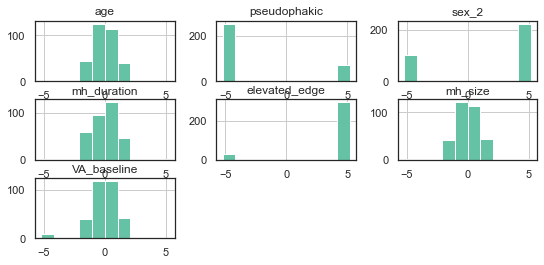

In [168]:

# demonstration of the power transform on data with a skew

from sklearn.preprocessing import QuantileTransformer

X = X_imp[['age', 'pseudophakic', 'sex_2','mh_duration', 'elevated_edge','mh_size', 'VA_baseline']].copy()
y = y_train.copy()

X_data_test = X_imp_test[['age', 'pseudophakic', 'sex_2','mh_duration', 'elevated_edge','mh_size', 'VA_baseline']].copy()
y_data_test = y_test.copy()
X.hist()
plt.show()

trans = QuantileTransformer(n_quantiles=10,  output_distribution='normal',random_state=rs)
trans.fit(X)
X_train_trans  = trans.transform(X)
X_test_trans   = trans.transform(X_data_test)

trans_y=QuantileTransformer(n_quantiles=25,  output_distribution='normal',random_state=rs)
trans_y.fit(y)

y_train_trans  = trans_y.transform(y)
y_test_trans   = trans_y.transform(y_data_test)

y_train_dataset = pd.DataFrame(y_train_trans,columns=y.columns)
y_test_dataset  = pd.DataFrame(y_test_trans,columns=y_data_test.columns)

# convert the array back to a dataframe
X_train_dataset = pd.DataFrame(X_train_trans,columns=X.columns)
X_test_dataset  = pd.DataFrame(X_test_trans,columns=X_data_test.columns)


# histograms of the variables
X_train_dataset.hist()
plt.show()

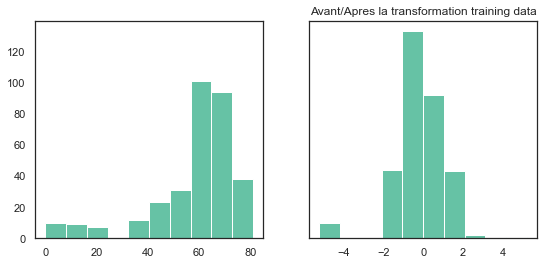

In [169]:
f, (ax0,ax1) = plt.subplots(1, 2, sharey=True)
ax0.hist(y_train)
ax1.hist(y_train_trans)
plt.title("Avant/Apres la transformation training data")
plt.show()

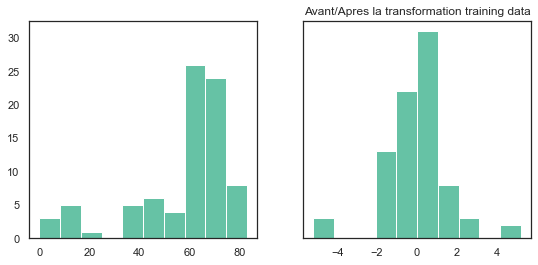

In [170]:
f, (ax0,ax1) = plt.subplots(1, 2, sharey=True)
ax0.hist(y_test)
ax1.hist(y_test_trans)
plt.title("Avant/Apres la transformation training data")
plt.show()

#### GradientBoostingRegressor

R2: training: 0.54
R2: test: 0.437
MSE sur donnees de training: 141.58
MSE: sur donnees de test 231.82


C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names

C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names

C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names

C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names



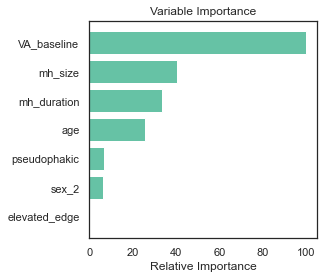

In [171]:
X_train_final,y_train_final=X_train_dataset,y_train_dataset.values.ravel()
X_test_final,y_test_final=X_test_dataset,y_test_dataset.values.ravel()

model = GradientBoostingRegressor(learning_rate=0.01,
                                                           max_depth=5,
                                                           min_samples_leaf=0.1,
                                                           min_samples_split=0.1,
                                                           n_estimators=800,
                                                           random_state=42)
model.fit(X_train_final, y_train_final)
train_pred = model.predict(X_train_final)
ypred = model.predict(X_test_final)

train_pred=np.round(trans_y.inverse_transform(train_pred.reshape(-1, 1)),0)
y_train_final=trans_y.inverse_transform(y_train_final.reshape(-1, 1))

ypred=trans_y.inverse_transform(ypred.reshape(-1, 1))
y_test_final=trans_y.inverse_transform(y_test_final.reshape(-1, 1))


print("R2: training:",np.round(r2_score(y_train_final,train_pred),3))
print("R2: test:",np.round(r2_score(y_test_final, ypred),3))

mse = mean_squared_error(train_pred,y_train_final)
print("MSE sur donnees de training: %.2f" % mse)

mse = mean_squared_error(ypred, y_test_final)
print("MSE: sur donnees de test %.2f" % mse)

# #############################################################################
# Plot feature importance
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_final.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Text(0.5, 1.0, 'GradientBoostingRegressor,Quantile Transformer')

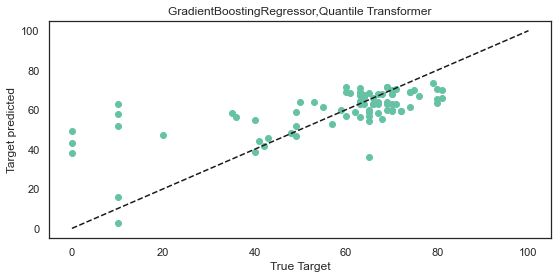

In [172]:
f, (ax0) = plt.subplots(1, 1, sharey=True)
ax0.scatter(y_test_final, ypred)
ax0.plot([0, 100], [0, 100], "--k")
ax0.set_ylabel("Target predicted")
ax0.set_xlabel("True Target")
plt.title("GradientBoostingRegressor,Quantile Transformer")

#### AdaBoostRegressor

C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names

C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names

C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names

C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names



R2: training: 0.531
R2: test: 0.476
MSE sur donnees de training: 144.50
MSE: sur donnees de test 215.98


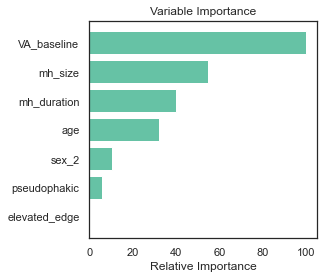

In [173]:
X_train_final,y_train_final=X_train_dataset,y_train_dataset.values.ravel()
X_test_final,y_test_final=X_test_dataset,y_test_dataset.values.ravel()

model=AdaBoostRegressor(base_estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                           max_depth=5,
                                                           min_samples_leaf=0.1,
                                                           min_samples_split=0.1,
                                                           n_estimators=800,
                                                           random_state=42),
                  learning_rate=0.001, n_estimators=32, random_state=42)
model.fit(X_train_final, y_train_final)
train_pred = model.predict(X_train_final)
ypred = model.predict(X_test_final)

train_pred=np.round(trans_y.inverse_transform(train_pred.reshape(-1, 1)),0)
y_train_final=trans_y.inverse_transform(y_train_final.reshape(-1, 1))

ypred=trans_y.inverse_transform(ypred.reshape(-1, 1))
y_test_final=trans_y.inverse_transform(y_test_final.reshape(-1, 1))


print("R2: training:",np.round(r2_score(y_train_final,train_pred),3))
print("R2: test:",np.round(r2_score(y_test_final, ypred),3))

mse = mean_squared_error(train_pred,y_train_final)
print("MSE sur donnees de training: %.2f" % mse)

mse = mean_squared_error(ypred, y_test_final)
print("MSE: sur donnees de test %.2f" % mse)

# #############################################################################
# Plot feature importance
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_final.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

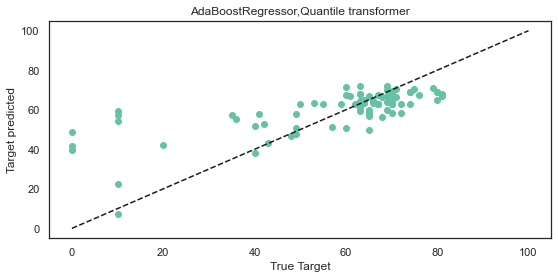

In [174]:
f, (ax0) = plt.subplots(1, 1, sharey=True)
ax0.scatter(y_test_final, ypred)
ax0.plot([0, 100], [0, 100], "--k")
ax0.set_ylabel("Target predicted")
ax0.set_xlabel("True Target")
plt.title("AdaBoostRegressor,Quantile transformer")
plt.show()

#### Huber Regression

In [185]:
X_train_final,y_train_final=X_train_dataset,y_train_dataset.values.ravel()
X_test_final,y_test_final=X_test_dataset,y_test_dataset.values.ravel()

model=HuberRegressor(alpha=2.5, epsilon=1.5, max_iter=10)
model.fit(X_train_final, y_train_final)
train_pred = model.predict(X_train_final)
ypred = model.predict(X_test_final)

train_pred=np.round(trans_y.inverse_transform(train_pred.reshape(-1, 1)),0)
y_train_final=trans_y.inverse_transform(y_train_final.reshape(-1, 1))

ypred=trans_y.inverse_transform(ypred.reshape(-1, 1))
y_test_final=trans_y.inverse_transform(y_test_final.reshape(-1, 1))


print("R2: training:",np.round(r2_score(y_train_final,train_pred),3))
print("R2: test:",np.round(r2_score(y_test_final, ypred),3))

mse = mean_squared_error(train_pred,y_train_final)
print("MSE sur donnees de training: %.2f" % mse)

mse = mean_squared_error(ypred, y_test_final)
print("MSE: sur donnees de test %.2f" % mse)



R2: training: 0.07
R2: test: 0.439
MSE sur donnees de training: 286.32
MSE: sur donnees de test 231.11


C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names

C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names

C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names

C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names



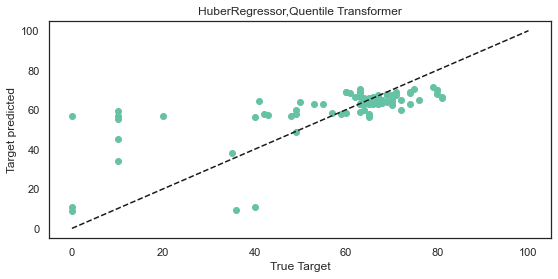

In [213]:
f, (ax0) = plt.subplots(1, 1, sharey=True)
ax0.scatter(y_test_final, ypred)
ax0.plot([0, 100], [0, 100], "--k")
ax0.set_ylabel("Target predicted")
ax0.set_xlabel("True Target")
plt.title('HuberRegressor,Quentile Transformer')
plt.show()

### Suport Vecteur Machine

In [186]:
X_train_final,y_train_final=X_train_dataset,y_train_dataset.values.ravel()
X_test_final,y_test_final=X_test_dataset,y_test_dataset.values.ravel()

model=SVR(C=4, degree=2, gamma='auto', kernel='rbf')

model.fit(X_train_final, y_train_final)
train_pred = model.predict(X_train_final)
ypred = model.predict(X_test_final)

train_pred=np.round(trans_y.inverse_transform(train_pred.reshape(-1, 1)),0)
y_train_final=trans_y.inverse_transform(y_train_final.reshape(-1, 1))

ypred=trans_y.inverse_transform(ypred.reshape(-1, 1))
y_test_final=trans_y.inverse_transform(y_test_final.reshape(-1, 1))


print("R2: training:",np.round(r2_score(y_train_final,train_pred),3))
print("R2: test:",np.round(r2_score(y_test_final, ypred),3))

mse = mean_squared_error(train_pred,y_train_final)
print("MSE sur donnees de training: %.2f" % mse)

mse = mean_squared_error(ypred, y_test_final)
print("MSE: sur donnees de test %.2f" % mse)

R2: training: 0.426
R2: test: 0.25
MSE sur donnees de training: 176.86
MSE: sur donnees de test 309.04


C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names

C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names

C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names

C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names



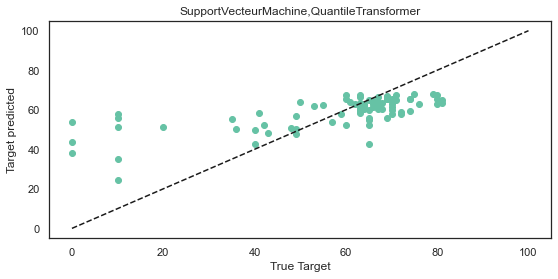

In [187]:
f, (ax0) = plt.subplots(1, 1, sharey=True)
ax0.scatter(y_test_final, prediction_test)
ax0.plot([0, 100], [0, 100], "--k")
ax0.set_ylabel("Target predicted")
ax0.set_xlabel("True Target")
plt.title('SupportVecteurMachine,QuantileTransformer')
plt.show()

#### PassiveAggressiveRegressor

In [213]:
X_train_final,y_train_final=X_train_dataset[['age','mh_duration','mh_size','VA_baseline','sex_2','pseudophakic']],y_train_trans.ravel()
X_test_final,y_test_final=X_test_dataset[['age','mh_duration','mh_size','VA_baseline','sex_2','pseudophakic']],y_test_trans.ravel()

param_grid = {'C': [0.001,0.005,0.0025,0.1, 1,5],
              'max_iter' : [10,25,50,100,200,500,1000,1500,2000],
              #'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'random_state' : [22],
              'warm_start':[1,5,10],
              
             }
 
grid = GridSearchCV(PassiveAggressiveRegressor(), param_grid, 
                        cv = 10,
                        n_jobs= -1,
                        return_train_score=True)
 
# fitting the model for grid search
grid.fit(X_train_final, y_train_final)
myresults = pd.concat([pd.DataFrame(grid.cv_results_["params"]),
                       pd.DataFrame(grid.cv_results_["mean_train_score"],columns=["mean_train_score"]),
                       pd.DataFrame(grid.cv_results_["std_train_score"],columns=["std_train_score"]),
                       pd.DataFrame(grid.cv_results_["mean_test_score"],columns=["mean_validation_score"]),
                       pd.DataFrame(grid.cv_results_["std_test_score"], columns=["std_validation_score"])],axis=1)
ypred = grid.predict(X_test_final)
print('\n\nScore : {}\nParameters :{}\nFinal Test score :{}\n\n'.format(grid.best_score_, grid.best_params_,grid.score(X_test_final,y_test_final)))
myresults.sort_values(by=['mean_validation_score'], ascending=False)





Score : 0.10002897535714421
Parameters :{'C': 0.001, 'max_iter': 25, 'random_state': 22, 'warm_start': 1}
Final Test score :0.35874671807712033




C  max_iter  random_state  warm_start  mean_train_score  \
14   0.001       200            22          10          0.171416   
24   0.001      2000            22           1          0.171416   
22   0.001      1500            22           5          0.171416   
21   0.001      1500            22           1          0.171416   
20   0.001      1000            22          10          0.171416   
..     ...       ...           ...         ...               ...   
129  1.000      1500            22           1         -0.015368   
130  1.000      1500            22           5         -0.015368   
131  1.000      1500            22          10         -0.015368   
132  1.000      2000            22           1         -0.015368   
161  5.000      2000            22          10         -0.015368   

     std_train_score  mean_validation_score  std_validation_score  
14          0.019600               0.100029              0.226618  
24          0.019600               0.100029              0.226618  
22          0.019600               0.100029              0.226618  
21          0.019600               0.100029              0.226618  
20          0.019600               0.100029              0.226618  
..               ...                    ...                   ...  
129         0.194954              -0.183315              0.434282  
130         0.194954              -0.183315              0.434282  
131         0.194954              -0.183315              0.434282  
132         0.194954              -0.183315              0.434282  
161         0.194954              -0.183315              0.434282  

[162 rows x 8 columns]

In [507]:
y_data_test.isna().sum()

VA_2weeks    0
dtype: int64

In [991]:
rs=np.random.seed(42)


In [214]:
X = X_train_dataset[['age','mh_duration','mh_size','VA_baseline']]
#X=X_train_dataset.drop(['id','age'],axis=1)
y = y_train_trans.ravel()
#X_test_final=X_test_dataset.drop(['id','age'],axis=1)
X_test_final=X_test_dataset[['age','mh_duration','mh_size','VA_baseline']]
y_test_final = y_test_trans.ravel()


learner = PassiveAggressiveRegressor(C=0.001, random_state=22,max_iter=25)

learner.fit(X, y)
ypred = learner.predict(X_test_final)

ypred=trans_y.inverse_transform(ypred.reshape(-1, 1))
y_test_final=trans_y.inverse_transform(y_test_final.reshape(-1,1))

print('R2 training:',learner.score(X,y))
print('Test R^2 : %.3f'%  r2_score(y_test_final, ypred))
print("Coeficients:" ,learner.coef_)
print("Intercept", learner.intercept_)
data = pd.DataFrame(data={"Predicted AV_2weeks": ypred.flatten(),"Initial AV_2weeks":y_test_final.flatten()})
print(data.head(98))

R2 training: 0.1813830504744861
Test R^2 : 0.421
Coeficients: [ 0.00599218 -0.20272751 -0.17976679  0.24653014]
Intercept [-0.00850259]
    Predicted AV_2weeks  Initial AV_2weeks
0             63.000000               70.0
1             19.427713               40.0
2             63.697191               67.0
3             37.824240               10.0
4             65.526605               62.0
..                  ...                ...
77            67.599079               60.0
78            65.134513               41.0
79            63.130581               50.0
80            20.556554               36.0
81            58.459841               60.0

[82 rows x 2 columns]


C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names

C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names



In [215]:
print(learner.get_params)

<bound method BaseEstimator.get_params of PassiveAggressiveRegressor(C=0.001, max_iter=25, random_state=22)>


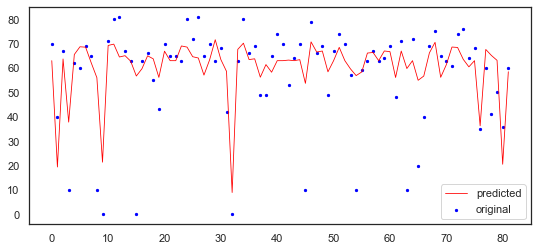

In [216]:
x_ax = range(len(y_test_final))
plt.scatter(x_ax, y_test_final, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

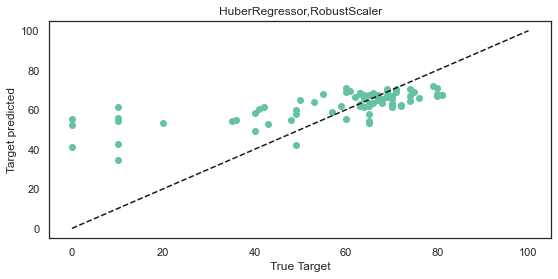

In [217]:
f, (ax0) = plt.subplots(1, 1, sharey=True)
ax0.scatter(y_test_final, prediction_test)
ax0.plot([0, 100], [0, 100], "--k")
ax0.set_ylabel("Target predicted")
ax0.set_xlabel("True Target")
plt.title('PassiveAggressiveRegressor,Quantile Transformer')
plt.show()

#### SVR

In [ ]:
X_train_final,y_train_final=X_train_dataset[['age','mh_duration','mh_size','VA_baseline','sex_2','pseudophakic']],y_train_trans.ravel()
X_test_final,y_test_final=X_test_dataset[['age','mh_duration','mh_size','VA_baseline','sex_2','pseudophakic']],y_test_trans.ravel()

param_grid = {'C': [0.1, 1,5, 10, 100, 1000,1500],
              'degree' : [3,8],
              #'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'gamma' : ['auto','scale'],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
 
grid = GridSearchCV(SVR(), param_grid, 
                        cv = 10,
                        n_jobs= -1,
                       return_train_score=True)
 
# fitting the model for grid search
grid.fit(X_train_final,y_train_final)
myresults = pd.concat([pd.DataFrame(grid.cv_results_["params"]),
                       pd.DataFrame(grid.cv_results_["mean_train_score"],columns=["mean_train_score"]),
                       pd.DataFrame(grid.cv_results_["std_train_score"],columns=["std_train_score"]),
                       pd.DataFrame(grid.cv_results_["mean_test_score"],columns=["mean_validation_score"]),
                       pd.DataFrame(grid.cv_results_["std_test_score"], columns=["std_validation_score"])],axis=1)
y_test_pred = grid.predict(X_test_final)
print('\n\nScore : {}\nParameters :{}\nFinal Test score :{}\n\n'.format(grid.best_score_, grid.best_params_,grid.score(X_test_final,y_test_final)))
myresults.sort_values(by=['mean_validation_score'], ascending=False)

### Quantile Regressor

In [215]:
df.columns

Index(['id', 'age', 'sex', 'pseudophakic', 'mh_duration', 'elevated_edge',
       'mh_size', 'VA_baseline', 'VA_2weeks', 'VA_3months', 'VA_6months',
       'VA_12months', 'VA_2months', 'ageGroup'],
      dtype='object')

In [188]:
X_2w=pd.DataFrame()
y_2w=pd.DataFrame()
X_2w=df[~df['VA_2weeks'].isna()].drop(['VA_2weeks','VA_3months','VA_6months','VA_12months','VA_2months'],axis=1)
y_2w=df[~df['VA_2weeks'].isna()]['VA_2weeks']


#----------------encoding categorical values---------------------------------------------------------
X_2w=encode_df(X_2w)
# Liste des variables utilisées
feature_list = list(X_2w.columns)


#----------------split train et test-------------------------------------------------------------------
X_train_2w, X_test_2w, y_train_2w, y_test_2w = train_test_split(X_2w, y_2w, test_size=0.2,random_state=42)
X_train_2w.shape, X_test_2w.shape,y_train_2w.shape ,y_test_2w.shape

X_train_2w.set_index('id',inplace=True)
X_test_2w.set_index('id',inplace=True)


#---------------------- imputing---------------------------------------------------------------------
# initialize imputer 
imputer = KNNImputer(missing_values=-9)

# fit the imputer on X_train. pass only numeric columns.
imputer.fit(X_train_2w[list_colmn_null])

# transform the data using the fitted imputer
X_train_2w_imp = imputer.transform(X_train_2w[list_colmn_null])
X_test_2w_imp = imputer.transform(X_test_2w[list_colmn_null])

# put the output into DataFrame. remember to pass columns used in fit/transform
X_train_2w_imp = pd.DataFrame(X_train_2w_imp, columns=list_colmn_null).set_index(X_train_2w.index)
X_test_2w_imp = pd.DataFrame(X_test_2w_imp,columns=list_colmn_null).set_index(X_test_2w.index)

#-----------------
X_train_ = X_train_2w.drop(['mh_duration','elevated_edge','mh_size','VA_baseline'],axis=1)
X_test_  = X_test_2w.drop(['mh_duration','elevated_edge','mh_size','VA_baseline'],axis=1)

X_imp_train_2w=pd.merge(X_train_,X_train_2w_imp,how='inner',left_index=True,right_index=True)
X_imp_test_2w=pd.merge(X_test_,X_test_2w_imp,how='inner',left_index=True,right_index=True)

#-------------------scaling------------------------------------------------------------------

X_train_2w_imp_num = X_imp_train_2w[['age','mh_duration','mh_size','VA_baseline']]
X_test_2w_imp_num  = X_imp_test_2w[['age','mh_duration','mh_size','VA_baseline']]

scaler = RobustScaler() #MinMaxScaler()
scaler.fit(X_train_2w_imp_num)
X_train_num_s_2w = scaler.transform(X_train_2w_imp_num)
X_test_num_s_2w  = scaler.transform(X_test_2w_imp_num)

df_train_num_2w = pd.DataFrame(X_train_num_s_2w, columns = X_train_2w_imp_num.columns).set_index(X_train_2w.index)
df_test_num_2w  = pd.DataFrame(X_test_num_s_2w, columns  = X_test_2w_imp_num.columns).set_index(X_test_2w.index)

df_train_num_2w.describe()
X_std_train_2w = pd.DataFrame()
X_std_test_2w  = pd.DataFrame()  
X_std_train_2w = df_train_num_2w.copy()
X_std_test_2w  = df_test_num_2w.copy() 

lst=['pseudophakic', 'sex_2']
for i in lst:
    X_std_train_2w[i] = pd.array(X_imp_train_2w[i])
    X_std_test_2w[i]  = pd.array(X_imp_test_2w[i])
    

#----------------Scaling target-------------------------------------------

target_scaler_2w =RobustScaler() #MinMaxScaler()
y_train_=y_train_2w.values
y_test_=y_test_2w.values

target_scaler_2w.fit(y_train_.reshape(-1,1))

# transform target variables
y_std_train_2w = target_scaler_2w.transform(y_train_.reshape(-1,1))
y_std_test_2w  = target_scaler_2w.transform(y_test_.reshape(-1,1))

y_std_train_2w = pd.DataFrame(y_std_train_2w, columns=['VA_2weeks']).set_index(y_train_2w.index)
y_std_test_2w  = pd.DataFrame(y_std_test_2w, columns=['VA_2weeks']).set_index(y_test_2w.index)

In [189]:
# sns.set_palette(sns.color_palette('Blues', len(QUANTILES)))
sns.set_palette(sns.color_palette('Blues'))
# Set dots to a light gray
dot_color = sns.color_palette('coolwarm', 3)[1]

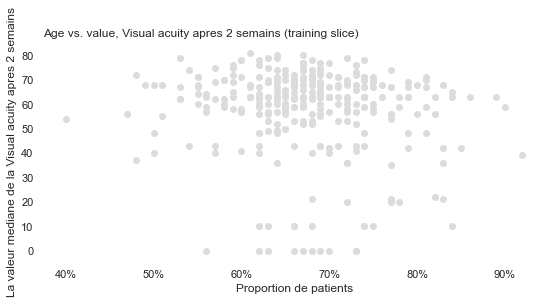

In [190]:
from matplotlib.ticker import FuncFormatter
dot_color = sns.color_palette('coolwarm', 3)[1]
ax = plt.scatter(X_train_2w.age, y_train_2w, color=dot_color)
plt.title('Age vs. value, Visual acuity apres 2 semains (training slice)', loc='left')
sns.despine(left=True, bottom=True)
ax.axes.xaxis.set_major_formatter(FuncFormatter(
    lambda x, _: '{:.0%}'.format(x / 100)))
ax.axes.yaxis.set_major_formatter(FuncFormatter(
    lambda y, _: '{:.0f}'.format(y)))
plt.xlabel('Proportion de patients')
plt.ylabel('La valeur mediane de la Visual acuity apres 2 semains')
plt.show()

In [191]:

X_train_final,y_train_final=X_std_train_2w,y_std_train_2w.values.ravel()
X_test_final,y_test_final=X_std_test_2w,y_std_test_2w.values.ravel()

def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]

QUANTILES = [0.25, 0.5,0.95]
# QUANTILES.reverse()  # Test out to see if we're getting different results.

quantiles_legend = [str(int(q * 100)) + 'th percentile' for q in QUANTILES]

all_models = {}
common_params = dict(
    learning_rate=0.01, 
    max_depth=4,
    min_samples_split=0.01, 
    n_estimators=200,
    random_state=42,
)


for alpha in QUANTILES:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)
    all_models["q %1.2f" % alpha] = gbr.fit(X_train_final, y_train_final)


results = []
y_train_final=target_scaler_2w.inverse_transform(y_train_final.reshape(-1, 1))
for name, gbr in sorted(all_models.items()):
    metrics = {"model": name}
    train_pred = gbr.predict(X_train_final)
    train_pred=np.round(target_scaler_2w.inverse_transform(train_pred.reshape(-1, 1)),0)
    for alpha in QUANTILES:
        metrics["pbl=%1.2f" % alpha] = mean_pinball_loss(y_train_final, train_pred, alpha=alpha)
    metrics["MSE"] = mean_squared_error(y_train_final, train_pred)
    results.append(metrics)
    
pd.DataFrame(results).set_index("model").style.apply(highlight_min)




In [192]:
results_t = []
y_test_final=target_scaler_2w.inverse_transform(y_test_final.reshape(-1, 1))
for name, gbr in sorted(all_models.items()):
    metrics = {"model": name}
    y_pred = gbr.predict(X_test_final)
    y_pred=np.round(target_scaler_2w.inverse_transform(y_pred.reshape(-1, 1)),0)
    for alpha in QUANTILES:
        metrics["pbl=%1.2f" % alpha] = mean_pinball_loss(y_test_final, y_pred, alpha=alpha)
    metrics["MSE"] = mean_squared_error(y_test_final, y_pred)
    results_t.append(metrics)
    
pd.DataFrame(results_t).set_index("model").style.apply(highlight_min)

In [193]:
METHODS = [ 'Gradient boosting']
QUANTILES = [0.25, 0.5,0.95]
quantiles_legend = [str(int(q * 100)) + 'th percentile' for q in QUANTILES]
X_train_final,y_train_final=X_std_train_2w,y_std_train_2w.values.ravel()
X_test_final,y_test_final=X_std_test_2w,y_std_test_2w.values.ravel()
X_test_final_=pd.DataFrame(scaler.inverse_transform(X_test_num_s_2w),columns=[['age','mh_duration','mh_size','VA_baseline']])
y_test_final_=np.round(target_scaler_2w.inverse_transform(y_test_final.reshape(-1, 1)),0).ravel()
x_test=X_test_final_.age

In [194]:
x_test.shape,y_test_final_.shape

((82, 1), (82,))

In [195]:
preds = np.array([(method, q, x) 
                  for method in METHODS 
                  for q in QUANTILES
                  for x in x_test.values.ravel()
                  ])
preds = pd.DataFrame(preds)
preds.columns = ['method', 'q', 'x']
preds = preds.apply(lambda x: pd.to_numeric(x, errors='ignore'))

In [196]:
def gb_quantile(X_train, train_labels, X, q):
    gbf = GradientBoostingRegressor(loss='quantile', alpha=q,
                                             n_estimators=1000,
                                             max_depth=3,
                                             learning_rate=0.1, min_samples_leaf=9,
                                             min_samples_split=9)
    gbf.fit(X_train, train_labels)
    return np.round(target_scaler_2w.inverse_transform(gbf.predict(X).reshape(-1, 1)),0) 

In [197]:
preds.loc[preds.method == 'Gradient boosting', 'pred'] = np.concatenate(
    [gb_quantile(X_train_final, y_train_final, X_test_final, q) for q in QUANTILES]) 

In [198]:
preds.isna().sum()

method    0
q         0
x         0
pred      0
dtype: int64

In [199]:
y_test_final.ravel()

array([ 0.53846154, -1.76923077,  0.30769231, -4.07692308, -0.07692308,
       -0.23076923,  0.46153846,  0.15384615, -4.07692308, -4.84615385,
        0.61538462,  1.30769231,  1.53846154,  0.30769231,  0.        ,
       -4.84615385,  0.        ,  0.23076923, -0.61538462, -1.53846154,
        0.53846154,  0.15384615,  0.15384615,  0.        ,  1.30769231,
        0.69230769,  1.46153846,  0.15384615,  0.53846154,  0.        ,
        0.38461538, -1.61538462, -4.84615385,  0.        ,  1.30769231,
        0.23076923,  0.46153846, -1.07692308, -1.07692308,  0.15384615,
        0.84615385,  0.53846154, -0.76923077,  0.07692308,  0.53846154,
       -4.07692308,  1.23076923,  0.23076923,  0.46153846, -1.07692308,
        0.30769231,  0.84615385,  0.53846154, -0.46153846, -4.07692308,
       -0.30769231,  0.        ,  0.30769231,  0.        ,  0.07692308,
        0.46153846, -1.15384615,  0.61538462, -4.07692308,  0.69230769,
       -3.30769231, -1.76923077,  0.46153846,  0.92307692,  0.15

In [200]:
preds[preds.q ==  0.25]

method     q     x  pred
0   Gradient boosting  0.25  81.0  60.0
1   Gradient boosting  0.25  82.0  26.0
2   Gradient boosting  0.25  64.0  60.0
3   Gradient boosting  0.25  59.0  49.0
4   Gradient boosting  0.25  65.0  62.0
..                ...   ...   ...   ...
77  Gradient boosting  0.25  52.0  68.0
78  Gradient boosting  0.25  64.0  49.0
79  Gradient boosting  0.25  66.0  63.0
80  Gradient boosting  0.25  67.0  50.0
81  Gradient boosting  0.25  67.0  47.0

[82 rows x 4 columns]

In [201]:
quantiles_legend

['25th percentile', '50th percentile', '95th percentile']

In [202]:
preds.isna().sum()

method    0
q         0
x         0
pred      0
dtype: int64

In [203]:
y_test_final_

array([70., 40., 67., 10., 62., 60., 69., 65., 10.,  0., 71., 80., 83.,
       67., 63.,  0., 63., 66., 55., 43., 70., 65., 65., 63., 80., 72.,
       82., 65., 70., 63., 68., 42.,  0., 63., 80., 66., 69., 49., 49.,
       65., 74., 70., 53., 64., 70., 10., 79., 66., 69., 49., 67., 74.,
       70., 57., 10., 59., 63., 67., 63., 64., 69., 48., 71., 10., 72.,
       20., 40., 69., 75., 65., 63., 61., 74., 76., 64., 68., 35., 60.,
       41., 50., 36., 60.])

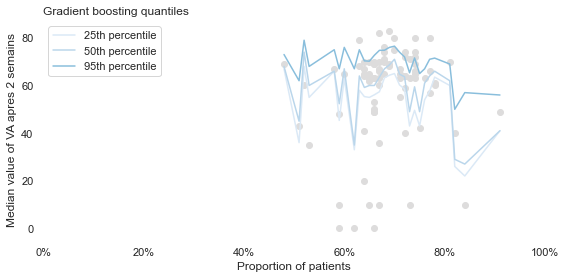

In [204]:
ax = plt.scatter(X_test_final_.age, y_test_final_, color=dot_color)
for i,method in enumerate(METHODS):
    
    plt.plot(preds[preds.method == method].pivot_table(index='x', columns='q', values='pred'))
    plt.legend(quantiles_legend)
    # Reversing legend isn't working, possibly because of multiple plots.
#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles[::-1], labels[::-1])
    plt.xlim((0, 100))
    ax.axes.xaxis.set_major_formatter(FuncFormatter(
        lambda x, _: '{:.0%}'.format(x / 100)))
    ax.axes.yaxis.set_major_formatter(FuncFormatter(
        lambda y, _: '{:.0f}'.format(y)))
    plt.xlabel('Proportion of patients')
    plt.ylabel('Median value of VA apres 2 semains')
    plt.title(method + ' quantiles', loc='left')
    sns.despine(left=True, bottom=True)
    plt.show()

## Partie IV: Imputing VA_2weeks, VA_3month

* réentraîner votre modèle et stocker les paramètres

### 1. VA 2 weeks

#### AdaBoostRegressor

In [176]:
X_train_final,y_train_final=X_std_train,y_std_train.values.ravel()
X_test_final,y_test_final=X_std_test,y_std_test.values.ravel()


model=AdaBoostRegressor(base_estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                           max_depth=5,
                                                           min_samples_leaf=0.1,
                                                           min_samples_split=0.1,
                                                           n_estimators=800,
                                                           random_state=42),
                  learning_rate=0.001, n_estimators=32, random_state=42)
model.fit(X_train_final,y_train_final)
prediction_train=model.predict(X_train_final)
prediction_test=model.predict(X_test_final)

prediction_train=target_scaler.inverse_transform(prediction_train.reshape(-1, 1))
prediction_test=target_scaler.inverse_transform(prediction_test.reshape(-1, 1))

y_test_final=target_scaler.inverse_transform(y_test_final.reshape(-1,1))
y_train_final=target_scaler.inverse_transform(y_train_final.reshape(-1,1))


print('Test R^2 : %.3f'%r2_score(y_test_final, prediction_test))
print('Train R^2 : %.3f'%r2_score(y_train_final, prediction_train))

mse = mean_squared_error(prediction_train,y_train_final)
print("MSE sur donnees de training: %.2f" % mse)
mse = mean_squared_error(y_test_final, prediction_test)
print("MSE: sur donnees de test %.2f" % mse)

prediction_train
data = pd.DataFrame(data={"Predicted AV_2weeks": ypred.flatten(),"Initial AV_2weeks":y_test_final.flatten()})
print(data.head(98))

Test R^2 : 0.442
Train R^2 : 0.485
MSE sur donnees de training: 158.54
MSE: sur donnees de test 231.08
    Predicted AV_2weeks  Initial AV_2weeks
0             63.000000               70.0
1             38.009484               40.0
2             63.122226               67.0
3             57.335033               10.0
4             63.000000               62.0
..                  ...                ...
77            71.554542               60.0
78            57.647021               41.0
79            63.000000               50.0
80            55.245198               36.0
81            50.527097               60.0

[82 rows x 2 columns]


In [177]:
model.get_params()

{'base_estimator__alpha': 0.9,
 'base_estimator__ccp_alpha': 0.0,
 'base_estimator__criterion': 'friedman_mse',
 'base_estimator__init': None,
 'base_estimator__learning_rate': 0.01,
 'base_estimator__loss': 'squared_error',
 'base_estimator__max_depth': 5,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_samples_leaf': 0.1,
 'base_estimator__min_samples_split': 0.1,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__n_estimators': 800,
 'base_estimator__n_iter_no_change': None,
 'base_estimator__random_state': 42,
 'base_estimator__subsample': 1.0,
 'base_estimator__tol': 0.0001,
 'base_estimator__validation_fraction': 0.1,
 'base_estimator__verbose': 0,
 'base_estimator__warm_start': False,
 'base_estimator': GradientBoostingRegressor(learning_rate=0.01, max_depth=5, min_samples_leaf=0.1,
                           min_samples_split=0.1, n_estimators=800,
             

#### Sauver les parameters algorithme

In [178]:
import pickle
filename = 'finalized_model_AV.sav'
pickle.dump(model, open(filename, 'wb'))
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))


#### Preprocessing/prevision pour VA_2weeks -Nan

In [179]:
X_new=df[df['VA_2weeks'].isna()].drop(['VA_2weeks','VA_3months','VA_6months','VA_12months','VA_2months'],axis=1).set_index('id')

#----------------encoding categorical values---------------------------------------------------------
X_new=encode_df(X_new)

#---------------------- imputing---------------------------------------------------------------------
list_colmn_null=['mh_duration', 'elevated_edge','mh_size', 'VA_baseline']
imputer = KNNImputer()
imputer = KNNImputer(missing_values=-9)
# fit the imputer on X_train. pass only numeric columns.
imputer.fit(X_new[list_colmn_null])
X_new_ = imputer.transform(X_new[list_colmn_null])
X_new_ = pd.DataFrame(X_new_, columns=list_colmn_null).set_index(X_new.index)
X_ = X_new.drop(['mh_duration','elevated_edge','mh_size','VA_baseline'],axis=1)
X_new_imp=pd.merge(X_,X_new_,how='inner',left_index=True,right_index=True)

#---------------------scaling-------------------------------------------------------------------------

X_new_imp_num=X_new_imp[['mh_duration','mh_size','VA_baseline']]
scaler = RobustScaler()#MinMaxScaler()
scaler.fit(X_new_imp_num)
X_new_s = scaler.transform(X_new_imp_num)

X_new_s = pd.DataFrame(X_new_s, columns=[['mh_duration','mh_size','VA_baseline']]).set_index(X_new.index)
X_std_new = pd.DataFrame()
X_std_new = X_new_s.copy()

lst=['pseudophakic', 'sex_2', 'ageGroup_50-60', 'ageGroup_60-70','ageGroup_70-80', 'ageGroup_80-plus']
for i in lst:
    X_std_new[i]=pd.array(X_new_imp[i])

#---------------------K_means----------------------------------------------------------------------------

features=['mh_duration', 'mh_size', 'VA_baseline', 'pseudophakic', 
        'sex_2', 'ageGroup_50-60', 'ageGroup_60-70', 'ageGroup_70-80',
        'ageGroup_80-plus']
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_std_new[features])
X_std_new['patient_type'] = kmeans.predict(X_std_new[features])

#-----------------------prediction-------------------------------------------------------------------------

y_new_patient = loaded_model.predict(X_std_new)

#---------------------invers transform---------------------------------------------------------------------

y_new_patient=target_scaler.inverse_transform(y_new_patient.reshape(-1, 1))



C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but AdaBoostRegressor was fitted with feature names



In [180]:
X_new["VA_2weeks"]=np.round(y_new_patient,0)

In [181]:
X_new

age  pseudophakic  mh_duration  elevated_edge  mh_size  VA_baseline  \
id                                                                         
130   77             0           -9              0      225           59   
140   75             0            2              1      422           36   
149   74             0            4              1      222           40   
150   79             0            4              1      512           40   
168   76             0            5              1      420           56   
..   ...           ...          ...            ...      ...          ...   
68    66             0            8              1      122           40   
80    78             1            9              1      368           21   
95    60             0            8              0      248           72   
98    47             0           13              1      224           66   
99    61             1            9              1      617           20   

     sex_2  ageGroup_50-60  ageGroup_60-70  ageGroup_70-80  ageGroup_80-plus  \
id                                                                             
130      1               0               0               1                 0   
140      0               0               0               1                 0   
149      1               0               0               1                 0   
150      0               0               0               1                 0   
168      0               0               0               1                 0   
..     ...             ...             ...             ...               ...   
68       1               0               1               0                 0   
80       0               0               0               1                 0   
95       1               1               0               0                 0   
98       1               0               0               0                 0   
99       1               0               1               0                 0   

     VA_2weeks  
id              
130       63.0  
140       50.0  
149       55.0  
150       56.0  
168       55.0  
..         ...  
68        54.0  
80        39.0  
95        69.0  
98        64.0  
99        42.0  

[87 rows x 12 columns]

In [182]:
df_notnull_=df[~df['VA_2weeks'].isna()].copy()
df_null_=df[df['VA_2weeks'].isna()].copy()
df_null_['VA_2weeks']=np.round(y_new_patient,0)
X_union_all= pd.concat([df_notnull_ ,df_null_])

In [183]:
df_null_['VA_2weeks']=np.round(y_new_patient,0)

In [184]:
X_union_all= pd.concat([df_notnull_ ,df_null_])


In [185]:
X_union_all

id  age  sex  pseudophakic  mh_duration  elevated_edge  mh_size  \
0    121   66    2             0           -9             -9       -9   
1    122   77    2             0           -9             -9       -9   
2    123   70    2             0           -9              1      378   
3    124   63    2             0           -9              1      384   
4    125   55    1             0           -9              1      580   
..   ...  ...  ...           ...          ...            ...      ...   
458   68   66    2             0            8              1      122   
470   80   78    1             1            9              1      368   
485   95   60    2             0            8              0      248   
488   98   47    2             0           13              1      224   
489   99   61    2             1            9              1      617   

     VA_baseline  VA_2weeks  VA_3months  VA_6months  VA_12months  VA_2months  \
0             10        0.0        41.0        41.0          NaN         NaN   
1             10       21.0        42.0         NaN          NaN         NaN   
2             43       63.0        58.0         NaN         67.0         NaN   
3             49       10.0         NaN         NaN         64.0         NaN   
4             50       68.0        69.0         NaN          NaN         NaN   
..           ...        ...         ...         ...          ...         ...   
458           40       54.0        10.0        69.0          NaN         NaN   
470           21       39.0         NaN        50.0          NaN         NaN   
485           72       69.0         NaN        63.0          NaN         NaN   
488           66       64.0        69.0        76.0          NaN         NaN   
489           20       42.0        74.0        67.0          NaN         NaN   

    ageGroup  
0      60-70  
1      70-80  
2      60-70  
3      60-70  
4      50-60  
..       ...  
458    60-70  
470    70-80  
485    50-60  
488     0-50  
489    60-70  

[494 rows x 14 columns]

In [189]:
X_union_all['VA_2weeks'].isna().sum()

0

### VA_3months

#### Preprocessing

In [190]:
X_3m=pd.DataFrame()
y_3m=pd.DataFrame()
X_3m=X_union_all[~X_union_all['VA_3months'].isna()].drop(['VA_3months','VA_6months','VA_12months','VA_2months'],axis=1)
y_3m=X_union_all[~X_union_all['VA_3months'].isna()]['VA_3months']


#----------------encoding categorical values---------------------------------------------------------
X_3m=encode_df(X_3m)
# Liste des variables utilisées
feature_list = list(X_3m.columns)


#----------------split train et test-------------------------------------------------------------------
X_train_3m, X_test_3m, y_train_3m, y_test_3m = train_test_split(X_3m, y_3m, test_size=0.2,random_state=42)
X_train_3m.shape, X_test_3m.shape,y_train_3m.shape ,y_test_3m.shape

X_train_3m.set_index('id',inplace=True)
X_test_3m.set_index('id',inplace=True)


#---------------------- imputing---------------------------------------------------------------------
# initialize imputer 
imputer = KNNImputer(missing_values=-9)

# fit the imputer on X_train. pass only numeric columns.
imputer.fit(X_train_3m[list_colmn_null])

# transform the data using the fitted imputer
X_train_3m_imp = imputer.transform(X_train_3m[list_colmn_null])
X_test_3m_imp = imputer.transform(X_test_3m[list_colmn_null])

# put the output into DataFrame. remember to pass columns used in fit/transform
X_train_3m_imp = pd.DataFrame(X_train_3m_imp, columns=list_colmn_null).set_index(X_train_3m.index)
X_test_3m_imp = pd.DataFrame(X_test_3m_imp,columns=list_colmn_null).set_index(X_test_3m.index)

#-----------------
X_train_ = X_train_3m.drop(['mh_duration','elevated_edge','mh_size','VA_baseline'],axis=1)
X_test_  = X_test_3m.drop(['mh_duration','elevated_edge','mh_size','VA_baseline'],axis=1)

X_imp_train_3m=pd.merge(X_train_,X_train_3m_imp,how='inner',left_index=True,right_index=True)
X_imp_test_3m=pd.merge(X_test_,X_test_3m_imp,how='inner',left_index=True,right_index=True)

#-------------------scaling------------------------------------------------------------------

X_train_3m_imp_num = X_imp_train_3m[['mh_duration','mh_size','VA_baseline','VA_2weeks']]
X_test_3m_imp_num  = X_imp_test_3m[['mh_duration','mh_size','VA_baseline','VA_2weeks']]

scaler = RobustScaler() #MinMaxScaler()
scaler.fit(X_train_3m_imp_num)
X_train_num_s_3m = scaler.transform(X_train_3m_imp_num)
X_test_num_s_3m  = scaler.transform(X_test_3m_imp_num)

df_train_num_3m = pd.DataFrame(X_train_num_s_3m, columns = X_train_3m_imp_num.columns).set_index(X_train_3m.index)
df_test_num_3m  = pd.DataFrame(X_test_num_s_3m, columns  = X_test_3m_imp_num.columns).set_index(X_test_3m.index)

df_train_num_3m.describe()
X_std_train_3m = pd.DataFrame()
X_std_test_3m  = pd.DataFrame()  
X_std_train_3m = df_train_num_3m.copy()
X_std_test_3m  = df_test_num_3m.copy() 

lst=['pseudophakic', 'sex_2', 'ageGroup_50-60', 'ageGroup_60-70','ageGroup_70-80', 'ageGroup_80-plus']
for i in lst:
    X_std_train_3m[i] = pd.array(X_imp_train_3m[i])
    X_std_test_3m[i]  = pd.array(X_imp_test_3m[i])
    
#------KMeans-----------------------------------------------------------------  
features=['mh_duration', 'mh_size', 'VA_baseline', 'pseudophakic', 
        'sex_2', 'ageGroup_50-60', 'ageGroup_60-70', 'ageGroup_70-80',
        'ageGroup_80-plus']
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_std_train_3m[features])
X_std_train_3m['patient_type'] = kmeans.predict(X_std_train_3m[features])
X_std_test_3m['patient_type'] = kmeans.predict(X_std_test_3m[features])

#----------------Scaling target-------------------------------------------

target_scaler_3m =RobustScaler() #MinMaxScaler()
y_train_=y_train_3m.values
y_test_=y_test_3m.values

target_scaler_3m.fit(y_train_.reshape(-1,1))

# transform target variables
y_std_train_3m = target_scaler_3m.transform(y_train_.reshape(-1,1))
y_std_test_3m  = target_scaler_3m.transform(y_test_.reshape(-1,1))

y_std_train_3m = pd.DataFrame(y_std_train_3m, columns=['VA_3months']).set_index(y_train_3m.index)
y_std_test_3m  = pd.DataFrame(y_std_test_3m, columns=['VA_3months']).set_index(y_test_3m.index)

#### Gradient Boosting Regressor

Test R^2 : 0.305
Train R^2 : 0.481
MSE sur donnees de training: 76.67
MSE: sur donnees de test 114.79
    Predicted AV_3months  Initial AV_3months
0                   58.0                75.0
1                   60.0                62.0
2                   60.0                59.0
3                   67.0                65.0
4                   62.0                61.0
..                   ...                 ...
68                  49.0                59.0
69                  54.0                51.0
70                  66.0                69.0
71                  53.0                20.0
72                  64.0                74.0

[73 rows x 2 columns]


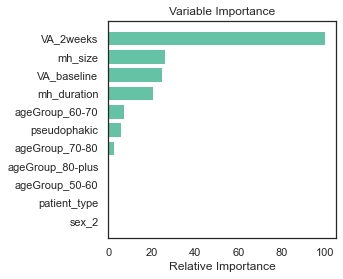

In [193]:
X_train_final_3m,y_train_final_3m = X_std_train_3m,y_std_train_3m.values.ravel()
X_test_final_3m,y_test_final_3m   = X_std_test_3m, y_std_test_3m.values.ravel()


model=GradientBoostingRegressor(learning_rate=0.055, 
                                loss='huber',#'absolute_error',
                                max_depth=3.75, 
                                min_samples_split=0.015,
                                n_estimators=65,
                                random_state=42)
model.fit(X_train_final_3m,y_train_final_3m)
prediction_train=model.predict(X_train_final_3m)
prediction_test=model.predict(X_test_final_3m)

prediction_train=np.round(target_scaler.inverse_transform(prediction_train.reshape(-1, 1)),0)
prediction_test=np.round(target_scaler.inverse_transform(prediction_test.reshape(-1, 1)),0)

y_test_final_3m=target_scaler_3m.inverse_transform(y_test_final_3m.reshape(-1,1))
y_train_final_3m=target_scaler_3m.inverse_transform(y_train_final_3m.reshape(-1,1))


print('Test R^2 : %.3f'%r2_score(y_test_final_3m, prediction_test))
print('Train R^2 : %.3f'%r2_score(y_train_final_3m, prediction_train))

mse = mean_squared_error(prediction_train,y_train_final_3m)
print("MSE sur donnees de training: %.2f" % mse)
mse = mean_squared_error(y_test_final_3m, prediction_test)
print("MSE: sur donnees de test %.2f" % mse)

prediction_train
data = pd.DataFrame(data={"Predicted AV_3months": prediction_test.flatten(),"Initial AV_3months":y_test_final_3m.flatten()})
print(data.head(98))

# #############################################################################
# Plot feature importance
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_final_3m.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### AdaBoostRegressor

In [194]:
X_train_final_3m,y_train_final_3m = X_std_train_3m,y_std_train_3m.values.ravel()
X_test_final_3m,y_test_final_3m   = X_std_test_3m, y_std_test_3m.values.ravel()


model=AdaBoostRegressor(base_estimator=GradientBoostingRegressor(learning_rate=0.055, 
                                loss='huber',#'absolute_error',
                                max_depth=3.75, 
                                min_samples_split=0.015,
                                n_estimators=65,
                                random_state=42),
                  learning_rate=0.0035,loss='square', n_estimators=74, random_state=42)
model.fit(X_train_final_3m,y_train_final_3m)
prediction_train=model.predict(X_train_final_3m)
prediction_test=model.predict(X_test_final_3m)

prediction_train=np.round(target_scaler.inverse_transform(prediction_train.reshape(-1, 1)),0)
prediction_test=np.round(target_scaler.inverse_transform(prediction_test.reshape(-1, 1)),0)

y_test_final_3m=target_scaler_3m.inverse_transform(y_test_final_3m.reshape(-1,1))
y_train_final_3m=target_scaler_3m.inverse_transform(y_train_final_3m.reshape(-1,1))


print('Test R^2 : %.3f'%r2_score(y_test_final_3m, prediction_test))
print('Train R^2 : %.3f'%r2_score(y_train_final_3m, prediction_train))

mse = mean_squared_error(prediction_train,y_train_final_3m)
print("MSE sur donnees de training: %.2f" % mse)
mse = mean_squared_error(y_test_final_3m, prediction_test)
print("MSE: sur donnees de test %.2f" % mse)

prediction_train
data = pd.DataFrame(data={"Predicted AV_3months": prediction_test.flatten(),"Initial AV_3months":y_test_final_3m.flatten()})
print(data.head(98))

Test R^2 : 0.309
Train R^2 : 0.474
MSE sur donnees de training: 77.69
MSE: sur donnees de test 114.23
    Predicted AV_3months  Initial AV_3months
0                   58.0                75.0
1                   60.0                62.0
2                   60.0                59.0
3                   67.0                65.0
4                   60.0                61.0
..                   ...                 ...
68                  50.0                59.0
69                  52.0                51.0
70                  66.0                69.0
71                  53.0                20.0
72                  63.0                74.0

[73 rows x 2 columns]


In [198]:
X_train_final_3m,y_train_final_3m=X_std_train_3m,y_std_train_3m.values.ravel()
X_test_final_3m,y_test_final_3m=X_std_test_3m,y_std_test_3m.values.ravel()


model=AdaBoostRegressor(base_estimator=GradientBoostingRegressor(learning_rate=0.045,
                                                           max_depth=3.75,
                                                           min_samples_split=0.045,
                                                           n_estimators=53,
                                                           random_state=42),
                  learning_rate=0.001, loss='square', n_estimators=25,
                  random_state=42)
model.fit(X_train_final_3m,y_train_final_3m)
prediction_train=model.predict(X_train_final_3m)
prediction_test=model.predict(X_test_final_3m)

prediction_train=np.round(target_scaler.inverse_transform(prediction_train.reshape(-1, 1)),0)
prediction_test=np.round(target_scaler.inverse_transform(prediction_test.reshape(-1, 1)),0)

y_test_final_3m=target_scaler_3m.inverse_transform(y_test_final_3m.reshape(-1,1))
y_train_final_3m=target_scaler_3m.inverse_transform(y_train_final_3m.reshape(-1,1))


print('Test R^2 : %.3f'%r2_score(y_test_final_3m, prediction_test))
print('Train R^2 : %.3f'%r2_score(y_train_final_3m, prediction_train))

mse = mean_squared_error(prediction_train,y_train_final_3m)
print("MSE sur donnees de training: %.2f" % mse)
mse = mean_squared_error(y_test_final_3m, prediction_test)
print("MSE: sur donnees de test %.2f" % mse)

prediction_train
data = pd.DataFrame(data={"Predicted AV_3months": prediction_test.flatten(),"Initial AV_3months":y_test_final_3m.flatten()})
print(data.head(98))

Test R^2 : 0.300
Train R^2 : 0.478
MSE sur donnees de training: 77.11
MSE: sur donnees de test 115.73
    Predicted AV_3months  Initial AV_3months
0                   59.0                75.0
1                   60.0                62.0
2                   61.0                59.0
3                   67.0                65.0
4                   60.0                61.0
..                   ...                 ...
68                  49.0                59.0
69                  51.0                51.0
70                  65.0                69.0
71                  52.0                20.0
72                  63.0                74.0

[73 rows x 2 columns]


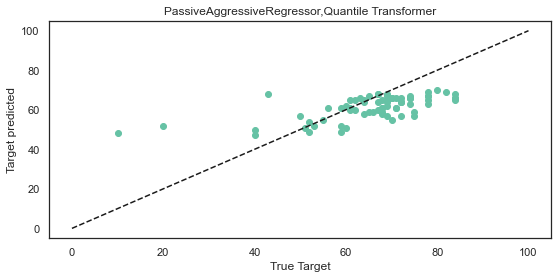

In [199]:
f, (ax0) = plt.subplots(1, 1, sharey=True)
ax0.scatter(y_test_final_3m, prediction_test)
ax0.plot([0, 100], [0, 100], "--k")
ax0.set_ylabel("Target predicted")
ax0.set_xlabel("True Target")
plt.title('PassiveAggressiveRegressor,Quantile Transformer')
plt.show()

#### Imputing Va 3m

In [200]:
filename = 'finalized_model_AV_3months.sav'
pickle.dump(model, open(filename, 'wb'))
# load the model from disk
loaded_model_3m = pickle.load(open(filename, 'rb'))

In [201]:
X_new_3m=X_union_all[X_union_all['VA_3months'].isna()].drop(['VA_6months','VA_12months','VA_2months'],axis=1).set_index('id')

#----------------encoding categorical values---------------------------------------------------------
X_new_3m=encode_df(X_new_3m)

#---------------------- imputing---------------------------------------------------------------------
list_colmn_null=['mh_duration', 'elevated_edge','mh_size', 'VA_baseline']
imputer = KNNImputer()
imputer = KNNImputer(missing_values=-9)
# fit the imputer on X_train. pass only numeric columns.
imputer.fit(X_new_3m[list_colmn_null])
X_new_3m_ = imputer.transform(X_new_3m[list_colmn_null])
X_new_3m_ = pd.DataFrame(X_new_3m_, columns=list_colmn_null).set_index(X_new_3m.index)
X_ = X_new_3m.drop(['mh_duration','elevated_edge','mh_size','VA_baseline'],axis=1)
X_new_3m_imp=pd.merge(X_,X_new_3m_,how='inner',left_index=True,right_index=True)

#---------------------scaling-------------------------------------------------------------------------

X_new_3m_imp_num=X_new_3m_imp[['mh_duration','mh_size','VA_baseline','VA_2weeks']]
scaler = RobustScaler()#MinMaxScaler()
scaler.fit(X_new_3m_imp_num)
X_new_3m_s = scaler.transform(X_new_3m_imp_num)

X_new_3m_s = pd.DataFrame(X_new_3m_s, columns=[['mh_duration','mh_size','VA_baseline','VA_2weeks']]).set_index(X_new_3m.index)
X_std_new_3m = pd.DataFrame()
X_std_new_3m = X_new_3m_s.copy()

lst=['pseudophakic', 'sex_2', 'ageGroup_50-60', 'ageGroup_60-70','ageGroup_70-80', 'ageGroup_80-plus']
for i in lst:
    X_std_new_3m[i]=pd.array(X_new_3m_imp[i])

#---------------------K_means----------------------------------------------------------------------------

features=['mh_duration', 'mh_size', 'VA_baseline', 'VA_2weeks','pseudophakic', 
        'sex_2', 'ageGroup_50-60', 'ageGroup_60-70', 'ageGroup_70-80',
        'ageGroup_80-plus']
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_std_new_3m[features])
X_std_new_3m['patient_type'] = kmeans.predict(X_std_new_3m[features])

#-----------------------prediction-------------------------------------------------------------------------

y_new_patient_3m = loaded_model_3m.predict(X_std_new_3m)

#---------------------invers transform---------------------------------------------------------------------

y_new_patient_3m=np.round(target_scaler_3m.inverse_transform(y_new_patient_3m.reshape(-1, 1)),0)



C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but AdaBoostRegressor was fitted with feature names



In [202]:
X_new_3m["VA_3months"]=y_new_patient_3m

In [203]:
df_notnull_3m_=X_union_all[~X_union_all['VA_3months'].isna()].copy()
df_null_3m_=X_union_all[X_union_all['VA_3months'].isna()].copy()
df_null_3m_['VA_3months']=y_new_patient_3m
X_union_all_3m= pd.concat([df_notnull_3m_ ,df_null_3m_])

In [204]:
X_union_all_3m.shape

(494, 14)

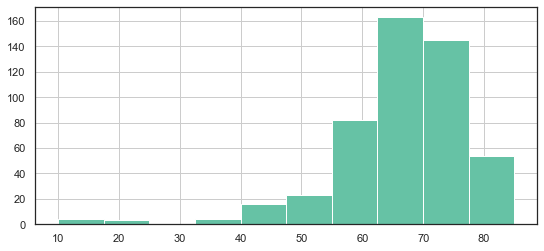

In [205]:
X_union_all_3m.VA_3months.hist()
plt.show()

### Quantile transformer

#### VA_2weeks

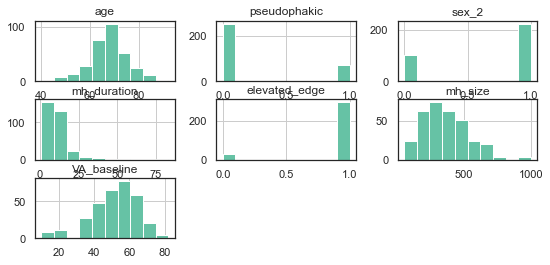

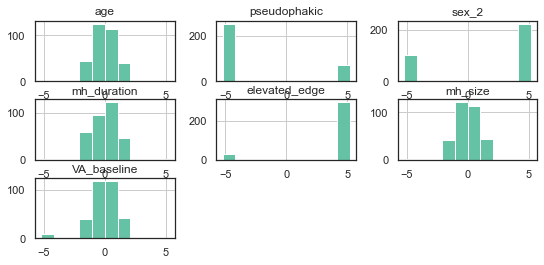

In [208]:

# demonstration of the power transform on data with a skew

from sklearn.preprocessing import QuantileTransformer

X = X_imp[['age', 'pseudophakic', 'sex_2','mh_duration', 'elevated_edge','mh_size', 'VA_baseline']].copy()
y = y_train.copy()

X_data_test = X_imp_test[['age', 'pseudophakic', 'sex_2','mh_duration', 'elevated_edge','mh_size', 'VA_baseline']].copy()
y_data_test = y_test.copy()
X.hist()
plt.show()

trans = QuantileTransformer(n_quantiles=10,  output_distribution='normal',random_state=rs)
trans.fit(X)
X_train_trans  = trans.transform(X)
X_test_trans   = trans.transform(X_data_test)

trans_y=QuantileTransformer(n_quantiles=25,  output_distribution='normal',random_state=rs)
trans_y.fit(y)

y_train_trans  = trans_y.transform(y)
y_test_trans   = trans_y.transform(y_data_test)

y_train_dataset = pd.DataFrame(y_train_trans,columns=y.columns)
y_test_dataset  = pd.DataFrame(y_test_trans,columns=y_data_test.columns)

# convert the array back to a dataframe
X_train_dataset = pd.DataFrame(X_train_trans,columns=X.columns)
X_test_dataset  = pd.DataFrame(X_test_trans,columns=X_data_test.columns)


# histograms of the variables
X_train_dataset.hist()
plt.show()

C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names

C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names

C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names

C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names



R2: training: 0.531
R2: test: 0.476
MSE sur donnees de training: 144.50
MSE: sur donnees de test 215.98


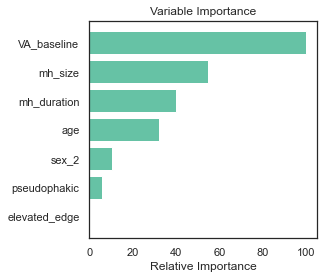

In [209]:
X_train_final,y_train_final=X_train_dataset,y_train_dataset.values.ravel()
X_test_final,y_test_final=X_test_dataset,y_test_dataset.values.ravel()

model=AdaBoostRegressor(base_estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                           max_depth=5,
                                                           min_samples_leaf=0.1,
                                                           min_samples_split=0.1,
                                                           n_estimators=800,
                                                           random_state=42),
                  learning_rate=0.001, n_estimators=32, random_state=42)
model.fit(X_train_final, y_train_final)
train_pred = model.predict(X_train_final)
ypred = model.predict(X_test_final)

train_pred=np.round(trans_y.inverse_transform(train_pred.reshape(-1, 1)),0)
y_train_final=trans_y.inverse_transform(y_train_final.reshape(-1, 1))

ypred=trans_y.inverse_transform(ypred.reshape(-1, 1))
y_test_final=trans_y.inverse_transform(y_test_final.reshape(-1, 1))


print("R2: training:",np.round(r2_score(y_train_final,train_pred),3))
print("R2: test:",np.round(r2_score(y_test_final, ypred),3))

mse = mean_squared_error(train_pred,y_train_final)
print("MSE sur donnees de training: %.2f" % mse)

mse = mean_squared_error(ypred, y_test_final)
print("MSE: sur donnees de test %.2f" % mse)

# #############################################################################
# Plot feature importance
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_final.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [210]:
import pickle
filename = 'finalized_model_Quantile_AV.sav'
pickle.dump(model, open(filename, 'wb'))
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))


In [211]:
X_new.columns

Index(['age', 'pseudophakic', 'mh_duration', 'elevated_edge', 'mh_size',
       'VA_baseline', 'sex_2', 'ageGroup_50-60', 'ageGroup_60-70',
       'ageGroup_70-80', 'ageGroup_80-plus', 'VA_2weeks'],
      dtype='object')

In [212]:
X_new=df[df['VA_2weeks'].isna()][['id','age', 'pseudophakic', 'mh_duration', 'elevated_edge', 'mh_size', 'VA_baseline', 'sex']].set_index('id')

#----------------encoding categorical values---------------------------------------------------------
#X_new=encode_df(X_new)

#---------------------- imputing---------------------------------------------------------------------
list_colmn_null=['mh_duration', 'elevated_edge','mh_size', 'VA_baseline']
imputer = KNNImputer()
imputer = KNNImputer(missing_values=-9)

# fit the imputer on X_train. pass only numeric columns.
imputer.fit(X_new[list_colmn_null])
X_new_ = imputer.transform(X_new[list_colmn_null])
X_new_ = pd.DataFrame(X_new_, columns=list_colmn_null).set_index(X_new.index)
X_ = X_new.drop(['mh_duration','elevated_edge','mh_size','VA_baseline'],axis=1)
X_new_imp=pd.merge(X_,X_new_,how='inner',left_index=True,right_index=True)

#---------------------scaling-------------------------------------------------------------------------
trans = QuantileTransformer(n_quantiles=10,  output_distribution='normal',random_state=rs)
trans.fit(X_new)
X_new_trans  = trans.transform(X_new)

# convert the array back to a dataframe
X_new_dataset = pd.DataFrame(X_new_trans,columns=X_new.columns)

#-----------------------prediction-------------------------------------------------------------------------

y_new_patient = loaded_model.predict(X_new_dataset)

y_new_patient=trans_y.inverse_transform(y_new_patient.reshape(-1, 1))

C:\Users\daian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names



In [213]:
df_notnull_=df[~df['VA_2weeks'].isna()].copy()
df_null_=df[df['VA_2weeks'].isna()].copy()
df_null_['VA_2weeks']=np.round(y_new_patient,0)
X_union_all= pd.concat([df_notnull_ ,df_null_])

In [214]:
X_union_all

id  age  sex  pseudophakic  mh_duration  elevated_edge  mh_size  \
0    121   66    2             0           -9             -9       -9   
1    122   77    2             0           -9             -9       -9   
2    123   70    2             0           -9              1      378   
3    124   63    2             0           -9              1      384   
4    125   55    1             0           -9              1      580   
..   ...  ...  ...           ...          ...            ...      ...   
458   68   66    2             0            8              1      122   
470   80   78    1             1            9              1      368   
485   95   60    2             0            8              0      248   
488   98   47    2             0           13              1      224   
489   99   61    2             1            9              1      617   

     VA_baseline  VA_2weeks  VA_3months  VA_6months  VA_12months  VA_2months  \
0             10        0.0        41.0        41.0          NaN         NaN   
1             10       21.0        42.0         NaN          NaN         NaN   
2             43       63.0        58.0         NaN         67.0         NaN   
3             49       10.0         NaN         NaN         64.0         NaN   
4             50       68.0        69.0         NaN          NaN         NaN   
..           ...        ...         ...         ...          ...         ...   
458           40       65.0        10.0        69.0          NaN         NaN   
470           21       12.0         NaN        50.0          NaN         NaN   
485           72       68.0         NaN        63.0          NaN         NaN   
488           66       62.0        69.0        76.0          NaN         NaN   
489           20       65.0        74.0        67.0          NaN         NaN   

    ageGroup  
0      60-70  
1      70-80  
2      60-70  
3      60-70  
4      50-60  
..       ...  
458    60-70  
470    70-80  
485    50-60  
488     0-50  
489    60-70  

[494 rows x 14 columns]

#### 3 mois

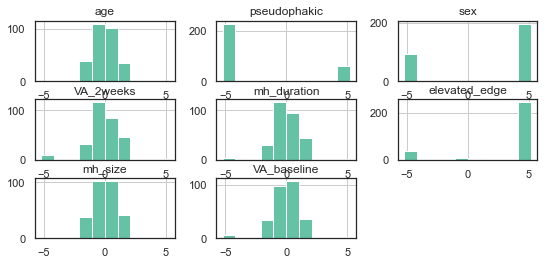

In [215]:
X_3m=pd.DataFrame()
y_3m=pd.DataFrame()
X_3m=X_union_all[~X_union_all['VA_3months'].isna()][['id','age', 'pseudophakic', 
                                                     'sex','mh_duration', 'elevated_edge',
                                                     'mh_size', 'VA_baseline','VA_2weeks']]
y_3m=X_union_all[~X_union_all['VA_3months'].isna()]['VA_3months']


#----------------encoding categorical values---------------------------------------------------------
#X_3m=encode_df(X_3m)
# Liste des variables utilisées
#feature_list = list(X_3m.columns)


#----------------split train et test-------------------------------------------------------------------
X_train_3m, X_test_3m, y_train_3m, y_test_3m = train_test_split(X_3m, y_3m, test_size=0.2,random_state=42)
X_train_3m.shape, X_test_3m.shape,y_train_3m.shape ,y_test_3m.shape

X_train_3m.set_index('id',inplace=True)
X_test_3m.set_index('id',inplace=True)


#---------------------- imputing---------------------------------------------------------------------
# initialize imputer 
imputer = KNNImputer(missing_values=-9)

# fit the imputer on X_train. pass only numeric columns.
imputer.fit(X_train_3m[list_colmn_null])

# transform the data using the fitted imputer
X_train_3m_imp = imputer.transform(X_train_3m[list_colmn_null])
X_test_3m_imp = imputer.transform(X_test_3m[list_colmn_null])

# put the output into DataFrame. remember to pass columns used in fit/transform
X_train_3m_imp = pd.DataFrame(X_train_3m_imp, columns=list_colmn_null).set_index(X_train_3m.index)
X_test_3m_imp = pd.DataFrame(X_test_3m_imp,columns=list_colmn_null).set_index(X_test_3m.index)

#-----------------
X_train_ = X_train_3m.drop(['mh_duration','elevated_edge','mh_size','VA_baseline'],axis=1)
X_test_  = X_test_3m.drop(['mh_duration','elevated_edge','mh_size','VA_baseline'],axis=1)

X_imp_train_3m=pd.merge(X_train_,X_train_3m_imp,how='inner',left_index=True,right_index=True)
X_imp_test_3m=pd.merge(X_test_,X_test_3m_imp,how='inner',left_index=True,right_index=True)

#-------------------scaling------------------------------------------------------------------

trans = QuantileTransformer(n_quantiles=10,  output_distribution='normal',random_state=rs)
trans.fit(X_imp_train_3m)
X_train_trans  = trans.transform(X_imp_train_3m)
X_test_trans   = trans.transform(X_imp_test_3m)

trans_y=QuantileTransformer(n_quantiles=25,  output_distribution='normal',random_state=rs)
trans_y.fit(np.array(y_train_3m).reshape(-1,1))

y_train_trans  = trans_y.transform(np.array(y_train_3m).reshape(-1,1))
y_test_trans   = trans_y.transform(np.array(y_test_3m).reshape(-1,1))

y_train_dataset = pd.DataFrame(y_train_trans,columns=y.columns)
y_test_dataset  = pd.DataFrame(y_test_trans,columns=y_data_test.columns)

# convert the array back to a dataframe
X_train_dataset = pd.DataFrame(X_train_trans,columns=X_imp_train_3m.columns)
X_test_dataset  = pd.DataFrame(X_test_trans,columns=X_imp_test_3m.columns)


# histograms of the variables
X_train_dataset.hist()
plt.show()

R2: training: 0.531
R2: test: 0.435
MSE sur donnees de training: 69.16
MSE: sur donnees de test 93.32


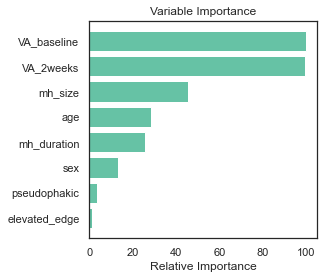

In [217]:
X_train_final,y_train_final=X_train_dataset,y_train_dataset.values.ravel()
X_test_final,y_test_final=X_test_dataset,y_test_dataset.values.ravel()

model=AdaBoostRegressor(base_estimator=GradientBoostingRegressor(learning_rate=0.025,
                                                           max_depth=3,
                                                           min_samples_leaf=0.01,
                                                           min_samples_split=0.01,
                                                           n_estimators=60,
                                                           random_state=42,
                                                           loss='huber'),
                  learning_rate=0.105,loss='square', n_estimators=64, random_state=42)
model.fit(X_train_final, y_train_final)
train_pred = model.predict(X_train_final)
ypred = model.predict(X_test_final)

train_pred=np.round(trans_y.inverse_transform(train_pred.reshape(-1, 1)),0)
y_train_final=trans_y.inverse_transform(y_train_final.reshape(-1, 1))

ypred=trans_y.inverse_transform(ypred.reshape(-1, 1))
y_test_final=trans_y.inverse_transform(y_test_final.reshape(-1, 1))


print("R2: training:",np.round(r2_score(y_train_final,train_pred),3))
print("R2: test:",np.round(r2_score(y_test_final, ypred),3))

mse = mean_squared_error(train_pred,y_train_final)
print("MSE sur donnees de training: %.2f" % mse)

mse = mean_squared_error(ypred, y_test_final)
print("MSE: sur donnees de test %.2f" % mse)

# #############################################################################
# Plot feature importance
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_final.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

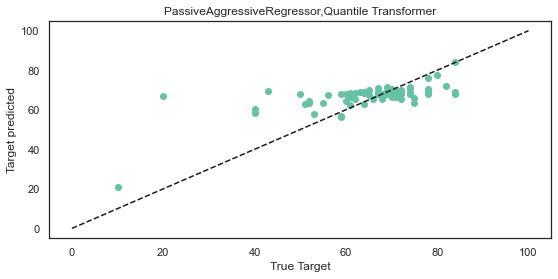

In [219]:
f, (ax0) = plt.subplots(1, 1, sharey=True)
ax0.scatter(y_test_final, ypred)
ax0.plot([0, 100], [0, 100], "--k")
ax0.set_ylabel("Target predicted")
ax0.set_xlabel("True Target")
plt.title('PassiveAggressiveRegressor,Quantile Transformer')
plt.show()

In [220]:
filename = 'finalized_model_Quantile_AV_3months.sav'
pickle.dump(model, open(filename, 'wb'))
# load the model from disk
loaded_model_3m = pickle.load(open(filename, 'rb'))

In [221]:
X_union_all

id  age  sex  pseudophakic  mh_duration  elevated_edge  mh_size  \
0    121   66    2             0           -9             -9       -9   
1    122   77    2             0           -9             -9       -9   
2    123   70    2             0           -9              1      378   
3    124   63    2             0           -9              1      384   
4    125   55    1             0           -9              1      580   
..   ...  ...  ...           ...          ...            ...      ...   
458   68   66    2             0            8              1      122   
470   80   78    1             1            9              1      368   
485   95   60    2             0            8              0      248   
488   98   47    2             0           13              1      224   
489   99   61    2             1            9              1      617   

     VA_baseline  VA_2weeks  VA_3months  VA_6months  VA_12months  VA_2months  \
0             10        0.0        41.0        41.0          NaN         NaN   
1             10       21.0        42.0         NaN          NaN         NaN   
2             43       63.0        58.0         NaN         67.0         NaN   
3             49       10.0         NaN         NaN         64.0         NaN   
4             50       68.0        69.0         NaN          NaN         NaN   
..           ...        ...         ...         ...          ...         ...   
458           40       65.0        10.0        69.0          NaN         NaN   
470           21       12.0         NaN        50.0          NaN         NaN   
485           72       68.0         NaN        63.0          NaN         NaN   
488           66       62.0        69.0        76.0          NaN         NaN   
489           20       65.0        74.0        67.0          NaN         NaN   

    ageGroup  
0      60-70  
1      70-80  
2      60-70  
3      60-70  
4      50-60  
..       ...  
458    60-70  
470    70-80  
485    50-60  
488     0-50  
489    60-70  

[494 rows x 14 columns]

In [222]:
X_union_all.columns

Index(['id', 'age', 'sex', 'pseudophakic', 'mh_duration', 'elevated_edge',
       'mh_size', 'VA_baseline', 'VA_2weeks', 'VA_3months', 'VA_6months',
       'VA_12months', 'VA_2months', 'ageGroup'],
      dtype='object')

In [223]:
X_new_3m=X_union_all[X_union_all['VA_3months'].isna()][['id', 'age', 'sex', 'pseudophakic', 'mh_duration', 'elevated_edge',
       'mh_size', 'VA_baseline', 'VA_2weeks',]].set_index('id')

#----------------encoding categorical values---------------------------------------------------------
#X_new_3m=encode_df(X_new_3m)

#---------------------- imputing---------------------------------------------------------------------
list_colmn_null=['mh_duration', 'elevated_edge','mh_size', 'VA_baseline']
imputer = KNNImputer()
imputer = KNNImputer(missing_values=-9)
# fit the imputer on X_train. pass only numeric columns.
imputer.fit(X_new_3m[list_colmn_null])
X_new_3m_ = imputer.transform(X_new_3m[list_colmn_null])
X_new_3m_ = pd.DataFrame(X_new_3m_, columns=list_colmn_null).set_index(X_new_3m.index)
X_ = X_new_3m.drop(['mh_duration','elevated_edge','mh_size','VA_baseline'],axis=1)
X_new_3m_imp=pd.merge(X_,X_new_3m_,how='inner',left_index=True,right_index=True)

#---------------------scaling-------------------------------------------------------------------------

#-------------------scaling------------------------------------------------------------------

trans = QuantileTransformer(n_quantiles=10,  output_distribution='normal',random_state=rs)
trans.fit(X_new_3m_imp)
X_new_trans  = trans.transform(X_new_3m_imp)

# convert the array back to a dataframe
X_new_trans = pd.DataFrame(X_new_trans,columns=X_new_3m_imp.columns)


#-----------------------prediction-------------------------------------------------------------------------

y_new_patient_3m = loaded_model_3m.predict(X_new_trans)

#---------------------invers transform---------------------------------------------------------------------

y_new_patient_3m=np.round(trans_y.inverse_transform(y_new_patient_3m.reshape(-1, 1)),0)



In [224]:
X_new_3m_imp

age  sex  pseudophakic  VA_2weeks  mh_duration  elevated_edge  mh_size  \
id                                                                            
124   63    2             0       10.0          8.8            1.0    384.0   
129   64    2             0       57.0         13.4            1.0    425.0   
133   68    1             0       72.0          7.4            1.0    149.0   
139   68    2             0       63.0          2.0            1.0    353.6   
141   71    2             0       68.0          2.0            1.0    657.0   
..   ...  ...           ...        ...          ...            ...      ...   
54    82    1             0       15.0          6.0            1.0    229.0   
58    39    2             1       61.0          6.0            1.0    280.0   
64    67    1             1       25.0         12.0            1.0    474.0   
80    78    1             1       12.0          9.0            1.0    368.0   
95    60    2             0       68.0          8.0            0.0    248.0   

     VA_baseline  
id                
124         49.0  
129         57.0  
133         67.0  
139         52.4  
141         48.0  
..           ...  
54          65.0  
58          65.0  
64          70.0  
80          21.0  
95          72.0  

[133 rows x 8 columns]

In [225]:
df_notnull_3m_=X_union_all[~X_union_all['VA_3months'].isna()].copy()
df_null_3m_=X_union_all[X_union_all['VA_3months'].isna()].copy()
df_null_3m_['VA_3months']=y_new_patient_3m
X_union_all_3m= pd.concat([df_notnull_3m_ ,df_null_3m_])

In [226]:
X_union_all_3m

id  age  sex  pseudophakic  mh_duration  elevated_edge  mh_size  \
0    121   66    2             0           -9             -9       -9   
1    122   77    2             0           -9             -9       -9   
2    123   70    2             0           -9              1      378   
4    125   55    1             0           -9              1      580   
5    126   63    2             0           -9              1       -9   
..   ...  ...  ...           ...          ...            ...      ...   
444   54   82    1             0            6              1      229   
448   58   39    2             1            6              1      280   
454   64   67    1             1           12              1      474   
470   80   78    1             1            9              1      368   
485   95   60    2             0            8              0      248   

     VA_baseline  VA_2weeks  VA_3months  VA_6months  VA_12months  VA_2months  \
0             10        0.0        41.0        41.0          NaN         NaN   
1             10       21.0        42.0         NaN          NaN         NaN   
2             43       63.0        58.0         NaN         67.0         NaN   
4             50       68.0        69.0         NaN          NaN         NaN   
5             54       68.0        69.0         NaN         57.0         NaN   
..           ...        ...         ...         ...          ...         ...   
444           65       15.0        70.0        70.0          NaN         NaN   
448           65       61.0        69.0        76.0         83.0         NaN   
454           70       25.0        67.0        71.0         82.0         NaN   
470           21       12.0        61.0        50.0          NaN         NaN   
485           72       68.0        72.0        63.0          NaN         NaN   

    ageGroup  
0      60-70  
1      70-80  
2      60-70  
4      50-60  
5      60-70  
..       ...  
444  80-plus  
448     0-50  
454    60-70  
470    70-80  
485    50-60  

[494 rows x 14 columns]

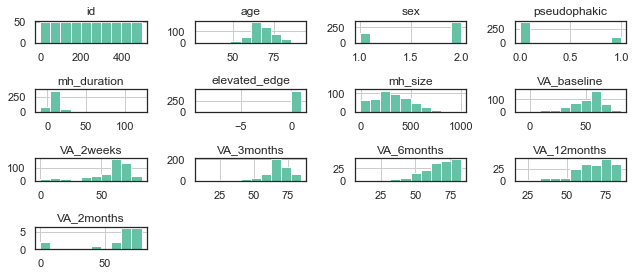

In [227]:
X_union_all_3m.hist()
plt.tight_layout()
plt.show()

In [228]:
X_union_all_3m

id  age  sex  pseudophakic  mh_duration  elevated_edge  mh_size  \
0    121   66    2             0           -9             -9       -9   
1    122   77    2             0           -9             -9       -9   
2    123   70    2             0           -9              1      378   
4    125   55    1             0           -9              1      580   
5    126   63    2             0           -9              1       -9   
..   ...  ...  ...           ...          ...            ...      ...   
444   54   82    1             0            6              1      229   
448   58   39    2             1            6              1      280   
454   64   67    1             1           12              1      474   
470   80   78    1             1            9              1      368   
485   95   60    2             0            8              0      248   

     VA_baseline  VA_2weeks  VA_3months  VA_6months  VA_12months  VA_2months  \
0             10        0.0        41.0        41.0          NaN         NaN   
1             10       21.0        42.0         NaN          NaN         NaN   
2             43       63.0        58.0         NaN         67.0         NaN   
4             50       68.0        69.0         NaN          NaN         NaN   
5             54       68.0        69.0         NaN         57.0         NaN   
..           ...        ...         ...         ...          ...         ...   
444           65       15.0        70.0        70.0          NaN         NaN   
448           65       61.0        69.0        76.0         83.0         NaN   
454           70       25.0        67.0        71.0         82.0         NaN   
470           21       12.0        61.0        50.0          NaN         NaN   
485           72       68.0        72.0        63.0          NaN         NaN   

    ageGroup  
0      60-70  
1      70-80  
2      60-70  
4      50-60  
5      60-70  
..       ...  
444  80-plus  
448     0-50  
454    60-70  
470    70-80  
485    50-60  

[494 rows x 14 columns]

In [230]:
#---------------------- imputing---------------------------------------------------------------------
list_colmn_null=['mh_duration', 'elevated_edge','mh_size', 'VA_baseline']
imputer = KNNImputer()
imputer = KNNImputer(missing_values=-9)
# fit the imputer on X_train. pass only numeric columns.
imputer.fit(X_union_all_3m[list_colmn_null])
X_new_3m_ = imputer.transform(X_union_all_3m[list_colmn_null])
X_new_3m_ = pd.DataFrame(X_new_3m_, columns=list_colmn_null).set_index(X_union_all_3m.index)
X_ = X_union_all_3m.drop(['mh_duration','elevated_edge','mh_size','VA_baseline'],axis=1)
X_new_all_imp=pd.merge(X_,X_new_3m_,how='inner',left_index=True,right_index=True)


In [231]:
X_new_all_imp

id  age  sex  pseudophakic  VA_2weeks  VA_3months  VA_6months  \
0    121   66    2             0        0.0        41.0        41.0   
1    122   77    2             0       21.0        42.0         NaN   
2    123   70    2             0       63.0        58.0         NaN   
4    125   55    1             0       68.0        69.0         NaN   
5    126   63    2             0       68.0        69.0         NaN   
..   ...  ...  ...           ...        ...         ...         ...   
444   54   82    1             0       15.0        70.0        70.0   
448   58   39    2             1       61.0        69.0        76.0   
454   64   67    1             1       25.0        67.0        71.0   
470   80   78    1             1       12.0        61.0        50.0   
485   95   60    2             0       68.0        72.0        63.0   

     VA_12months  VA_2months ageGroup  mh_duration  elevated_edge  mh_size  \
0            NaN         NaN    60-70          6.0            1.0    592.6   
1            NaN         NaN    70-80          6.0            1.0    592.6   
2           67.0         NaN    60-70         18.2            1.0    378.0   
4            NaN         NaN    50-60         10.4            1.0    580.0   
5           57.0         NaN    60-70         10.6            1.0    328.4   
..           ...         ...      ...          ...            ...      ...   
444          NaN         NaN  80-plus          6.0            1.0    229.0   
448         83.0         NaN     0-50          6.0            1.0    280.0   
454         82.0         NaN    60-70         12.0            1.0    474.0   
470          NaN         NaN    70-80          9.0            1.0    368.0   
485          NaN         NaN    50-60          8.0            0.0    248.0   

     VA_baseline  
0           10.0  
1           10.0  
2           43.0  
4           50.0  
5           54.0  
..           ...  
444         65.0  
448         65.0  
454         70.0  
470         21.0  
485         72.0  

[494 rows x 14 columns]

In [232]:
X_new_all_imp.to_csv("df_struct_VA.csv")

#### 6 mois

(168, 8) (168,)
(117, 8) (51, 8) (117,) (51,)


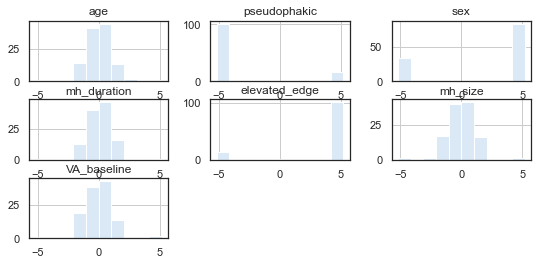

In [633]:
X_6m=pd.DataFrame()
y_6m=pd.DataFrame()
X_6m=X_union_all_3m[~X_union_all_3m['VA_6months'].isna()][['id','age', 'pseudophakic', 
                                                     'sex','mh_duration', 'elevated_edge',
                                                     'mh_size', 'VA_baseline']]
y_6m=X_union_all_3m[~X_union_all_3m['VA_6months'].isna()]['VA_6months']

print(X_6m.shape,y_6m.shape)
#----------------encoding categorical values---------------------------------------------------------
#X_6m=encode_df(X_6m)
# Liste des variables utilisées
#feature_list = list(X_6m.columns)


#----------------split train et test-------------------------------------------------------------------
X_train_6m, X_test_6m, y_train_6m, y_test_6m = train_test_split(X_6m, y_6m, test_size=0.3,random_state=42)

print(X_train_6m.shape, X_test_6m.shape,y_train_6m.shape ,y_test_6m.shape)


X_train_6m.set_index('id',inplace=True)
X_test_6m.set_index('id',inplace=True)


#---------------------- imputing---------------------------------------------------------------------
# initialize imputer 
imputer = KNNImputer(missing_values=-9)

# fit the imputer on X_train. pass only numeric columns.
imputer.fit(X_train_6m[list_colmn_null])

# transform the data using the fitted imputer
X_train_6m_imp = imputer.transform(X_train_6m[list_colmn_null])
X_test_6m_imp = imputer.transform(X_test_6m[list_colmn_null])

# put the output into DataFrame. remember to pass columns used in fit/transform
X_train_6m_imp = pd.DataFrame(X_train_6m_imp, columns=list_colmn_null).set_index(X_train_6m.index)
X_test_6m_imp = pd.DataFrame(X_test_6m_imp,columns=list_colmn_null).set_index(X_test_6m.index)

X_train_ = X_train_6m.drop(['mh_duration','elevated_edge','mh_size','VA_baseline'],axis=1)
X_test_  = X_test_6m.drop(['mh_duration','elevated_edge','mh_size','VA_baseline'],axis=1)

X_imp_train_6m=pd.merge(X_train_,X_train_6m_imp,how='inner',left_index=True,right_index=True)
X_imp_test_6m=pd.merge(X_test_,X_test_6m_imp,how='inner',left_index=True,right_index=True)

#-------------------scaling------------------------------------------------------------------


trans = QuantileTransformer(n_quantiles=10,  output_distribution='normal',random_state=rs)
trans.fit(X_imp_train_6m)
X_train_trans  = trans.transform(X_imp_train_6m)
X_test_trans   = trans.transform(X_imp_test_6m)

trans_y=QuantileTransformer(n_quantiles=25,  output_distribution='normal',random_state=rs)
trans_y.fit(np.array(y_train_6m).reshape(-1,1))

y_train_trans  = trans_y.transform(np.array(y_train_6m).reshape(-1,1))
y_test_trans   = trans_y.transform(np.array(y_test_6m).reshape(-1,1))

y_train_dataset = pd.DataFrame(y_train_trans,columns=y.columns)
y_test_dataset  = pd.DataFrame(y_test_trans,columns=y_data_test.columns)

# convert the array back to a dataframe
X_train_dataset = pd.DataFrame(X_train_trans,columns=X_imp_train_6m.columns)
X_test_dataset  = pd.DataFrame(X_test_trans,columns=X_imp_test_6m.columns)


# histograms of the variables
X_train_dataset.hist()
plt.show()

{'learning_rate': 0.03, 'loss': 'huber', 'max_depth': 1, 'min_samples_split': 0.001, 'n_estimators': 100}
GradientBoostingRegressor(learning_rate=0.03, loss='huber', max_depth=1,
                          min_samples_split=0.001, random_state=42)
MSE sur donnees de training: 112.37
R2: sur donnees de training: 0.22
MSE: sur donnees de test 106.76
R2 sur donnees de test: 0.00


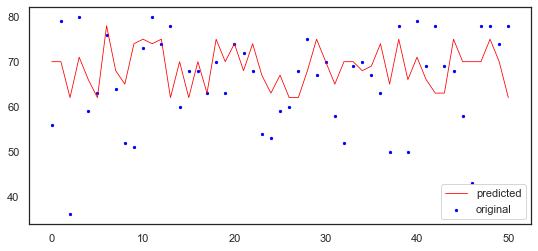

In [635]:
X_train_final_6m, y_train_final_6m  = X_train_dataset, y_train_dataset.values.ravel()
X_test_final_6m,  y_test_final_6m   = X_test_dataset,  y_test_dataset.values.ravel()

model = GradientBoostingRegressor(random_state=42)
params = {
    'learning_rate' : [0.001,0.01,0.02,0.03],#,0.11 ,0.25,0.33, 0.5 ,1],
    'n_estimators' : [ 16, 32, 64, 100],#200,250,300],#,450,500,550,600,700,750,800,850,900],
    'max_depth': [ 1,  2,  3,  4,  5],#,  6,  7,  8,  9, 10],
    'min_samples_split': [0.001,0.005,0.01,0.02,0.1,0.2],#, 0.2, 0.3],#, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
     'loss':['squared_error', 'absolute_error', 'huber']

 }

score = make_scorer(mean_squared_error)

gridsearch = GridSearchCV(model, params, cv=5, return_train_score=True)
gridsearch.fit(X_train_final_6m, y_train_final_6m)
print(gridsearch.best_params_)

best_estim=gridsearch.best_estimator_
print(best_estim)

best_estim.fit(X_train_final_6m, y_train_final_6m )

ytr_pred=best_estim.predict(X_train_final_6m)

# invert transform on predictions
ytr_pred         = trans_y.inverse_transform(ytr_pred.reshape(-1, 1))
y_train_final_6m = trans_y.inverse_transform(y_train_final_6m.reshape(-1, 1))

mse = mean_squared_error(ytr_pred,y_train_final_6m)
r2 = r2_score(y_train_final_6m,ytr_pred)
print("MSE sur donnees de training: %.2f" % mse)
print("R2: sur donnees de training: %.2f" % r2)

ypred=best_estim.predict(X_test_final_6m)

ypred           = np.round(trans_y.inverse_transform(ypred.reshape(-1, 1)),0)
y_test_final_6m = trans_y.inverse_transform(y_test_final_6m.reshape(-1, 1))

mse = mean_squared_error(y_test_final_6m, ypred)
r2 = r2_score(y_test_final_6m, ypred)
print("MSE: sur donnees de test %.2f" % mse)
print("R2 sur donnees de test: %.2f" % r2)

x_ax = range(len(y_test_final_6m))
plt.scatter(x_ax, y_test_final_6m, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

R2: training: 0.324
R2: test: 0.011
MSE sur donnees de training: 97.80
MSE: sur donnees de test 105.85


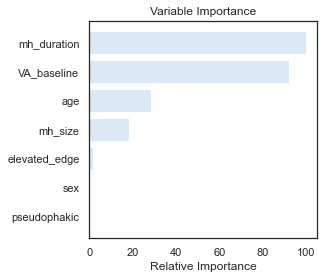

In [650]:
X_train_final,y_train_final=X_train_dataset,y_train_dataset.values.ravel()
X_test_final,y_test_final=X_test_dataset,y_test_dataset.values.ravel()

model=GradientBoostingRegressor(learning_rate=0.03, 
                                loss='huber', 
                                max_depth=2,
                                min_samples_split=0.05,
                                n_estimators=64,
                          random_state=42)
model.fit(X_train_final, y_train_final)
train_pred = model.predict(X_train_final)
ypred = model.predict(X_test_final)

train_pred=np.round(trans_y.inverse_transform(train_pred.reshape(-1, 1)),0)
y_train_final=trans_y.inverse_transform(y_train_final.reshape(-1, 1))

ypred=trans_y.inverse_transform(ypred.reshape(-1, 1))
y_test_final=trans_y.inverse_transform(y_test_final.reshape(-1, 1))


print("R2: training:",np.round(r2_score(y_train_final,train_pred),3))
print("R2: test:",np.round(r2_score(y_test_final, ypred),3))

mse = mean_squared_error(train_pred,y_train_final)
print("MSE sur donnees de training: %.2f" % mse)

mse = mean_squared_error(ypred, y_test_final)
print("MSE: sur donnees de test %.2f" % mse)

# #############################################################################
# Plot feature importance
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_final.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Annexe

### Regression lineaire/estimer le VA_2weeks

In [137]:
df_processing.boxplot("VA_2weeks",by=["sex",'pseudophakic','elevated_edge'])
plt.show()

NameError: name 'df_processing' is not defined

In [ ]:
#filtrer les VA_2weeks a 0
df_processing_filtr=df_processing[df_processing['VA_2weeks']!=0]
#df_processing_filtr['VA_2weeks'].value_counts()

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula='df_processing_filtr.VA_2weeks ~ age+mh_duration+mh_size+VA_baseline+C(df_processing_filtr["sex"])+C(df_processing_filtr["sex"])+C(df_processing_filtr["pseudophakic"])+C(df_processing_filtr["elevated_edge"])' 
model1 = ols(formula
             , data=df_processing_filtr ). fit()
print("Test de normalite des residus Shapiro: ",stats.shapiro(model1.resid),"\n")

print("Test de normalite mod visuel\n")

#################################################################################################


fig = plt.figure(figsize= (6, 8))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model1.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

###############################################################################################

print(model1.summary())


#table = sm.stats.anova_lm(model1, typ=2) # Type 2 Anova DataFrame
#print(table)


Pour accepter la normalité des résidus, il est donc nécessaire d’obtenir une p-value > 0.05, nous avons p_value=0 donc on rejette l'hypothese de normalite.
La distribution est sqweed a gouche.

In [ ]:
plt.figure(figsize=(6, 4))

sns.histplot(df_processing_filtr.VA_2weeks, bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('VA_2weeks')
ax.set_title('La distribution de VA_2weeks')

plt.show()

In [ ]:
from statsmodels.graphics.gofplots import qqplot

qqplot_data = qqplot(df_processing_filtr.VA_2weeks, fmt='r',line='s')
plt.title='Quantile-Quantile Plot'
plt.show()

On valide la question de la normalité avec la fonction qqplot() statsmodels function.
Les points qui représentes chaque observation sont éloignés de la ligne de référence, 
indiquant que la distribution des données est significativement 
différente de la distribution normale

In [ ]:
log_VA_2weeks = np.log1p(df_processing_filtr.VA_2weeks)

plt.figure(figsize=(6, 4))

sns.histplot(log_VA_2weeks, bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Log(VA_2weeks + 1)')
ax.set_title('Distribution du VA_2weeks apres log transformation')

plt.show()

In [ ]:
qqplot_data = qqplot(log_VA_2weeks, fmt='r',line='s')
plt.title='Quantile-Quantile Plot'
plt.show()

### Encoder

In [ ]:
df_dc = pd.get_dummies(df_processing[['sex','pseudophakic','elevated_edge']], columns=['sex','pseudophakic','elevated_edge'])

In [ ]:
df_dc.set_index(df_processing['id'])

In [ ]:
df_scaled=df_dc.join(scaleledX)

In [ ]:
df_scaled

### Scaller

In [ ]:
scaler = StandardScaler()
X_train_num_s = scaler.fit_transform(X_imp_num)
X_test_num_s  = scaler.fit_transform(X_imp_test_num)

df_train_num = pd.DataFrame(X_train_num_s, columns=X_imp_num.columns)
df_test_num = pd.DataFrame(X_test_num_s, columns=X_imp_test_num.columns)

df_train_num.describe()

In [1466]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [ ]:
X_train_final,y_train_final=X_std_train,y_std_train.values.ravel()
X_test_final,y_test_final=X_std_test,y_std_test.values.ravel()


epsilon_values=[]
epsilon_values = [1, 1.5, 1.75, 1.9]
colors = ["r-", "b-", "y-", "m-"]
x = np.linspace(X['VA_baseline'].min(), X['VA_baseline'].max(), 9)
for k, epsilon in enumerate(epsilon_values):
    huber = HuberRegressor(alpha=0.0, epsilon=epsilon)
    huber.fit(X_train_final,y_train_final)
    coef_ = huber.coef_ * x + huber.intercept_
    plt.plot(x, coef_, colors[k], label="huber loss, %s" % epsilon)

plt.scatter(X_test_final['VA_baseline'], y_test_final, color="black")
plt.title(" HuberRegressor ")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()

In [ ]:
#### Parameter tuning pour DecisionTreeRegressor

##https://www.youtube.com/watch?v=u-BXqYjBh-o

#https://www.youtube.com/watch?v=Oo4ZWDBT5ao
    
def getTotalAbsoluteError(X_train,X,y,modelInput):
    predictedValues=modelInput.predict(X_train)
    errors=modelInput.score(X,y)
    return (errors)
#Tree Depth
#######################################################################
X_train_final,y_train_final=X_std_train,y_std_train
X_test_final,y_test_final=X_std_test,y_std_test
err=[]
errIndex=[]
errTest=[]
s=0
for treedepth in range(1,7):
    clf=DecisionTreeRegressor(random_state=rs,max_depth=treedepth)
    model=clf.fit(X_train_final,y_train_final)
    err.append(getTotalAbsoluteError(X_train_final,X_train_final,y_train_final,model))
    errTest.append(getTotalAbsoluteError(X_train_final,X_test_final,y_test_final,model))
    errIndex.append(treedepth)
###################################################################################    
fig,ax=plt.subplots()
ax.plot(errIndex,err,'s-',color='orange')
ax.plot(errIndex,errTest,'s-',color='blue')
ax.set_ylabel("Total Error(r2)")
ax.set_xlabel("Max tree depth")
ax.set_title("Error vs Tree Depth for training")
plt.legend(["Train",'Validate'])
plt.show()

#Leaf depth
##################################################################
err=[]
errIndex=[]
errTest=[]
for leafcount in range(1,15):
    clf=DecisionTreeRegressor(random_state=rs, min_samples_leaf=leafcount)
    model2=clf.fit(X_train_final,y_train_final)
    err.append(getTotalAbsoluteError(X_train_final,X_train_final,y_train_final,model2))
    errTest.append(getTotalAbsoluteError(X_train_final,X_test_final,y_test_final,model2))
    errIndex.append(leafcount)
##############################################    
fig,ax=plt.subplots()
ax.plot(errIndex,err,'s-',color='orange')
ax.plot(errIndex,errTest,'s-',color='blue')
ax.set_ylabel("Total Error(MAE)")
ax.set_xlabel("Min leaf depth")
ax.set_title("Error vs Tree Depth for training")
plt.legend(["Train",'Validate'])
plt.show()    
#############################################################################################
X_train_final,y_train_final=X_std_train,y_std_train
X_test_final,y_test_final=X_std_test,y_std_test
tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=5,random_state=rs)
#tree.fit(data_train, target_train)
cv_results = cross_validate( tree, X_train_final, y_train_final,
                            cv=10, 
                            scoring="r2",
                            return_train_score=True,
                            return_estimator=True)

train_error = -cv_results["train_score"]
print(f" r2(coefficient of determination) of linear regression model on the train set:\n"
      f"{-train_error.mean():.3f} +/- {train_error.std():.3f}")

test_error = -cv_results["test_score"]
print(f"r2(coefficient of determination) of linear regression model on the test set:\n"
      f"{-test_error.mean():.3f} +/- {test_error.std():.3f}")



# invert transform on predictions
#yhat = model.predict(test_X)
#yhat = target_scaler.inverse_transform(yhat)

X_train_final,y_train_final=X_std_train,y_std_train
X_test_final,y_test_final=X_std_test,y_std_test
tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=10,random_state=rs)
tree.fit(X_train_final,y_train_final)

y_pred=tree.predict(X_test_final)

# invert transform on predictions
y_pred=target_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_final=target_scaler.inverse_transform(y_test_final)

MSE_tree=MSE(y_test_final,y_pred)
RMSE_tree=MSE_tree**(1/2)
R2(y_test_final,y_pred)

print(RMSE_tree)
print('r2:',R2(y_test_final,y_pred))
#print(np.round(y_pred[:10],2)),print(np.array(y_test_final[:11]))

print('Test R^2     : %.3f'%R2(y_test_final, y_pred))

x=np.arange(0,len(X_train_final),1)
plt.scatter(x, y_train_final,  s=5,color = 'blue',label="original")
#5 Visualising the Decision Tree Regression results
#plt.scatter(X_std_train, y_train, color = 'red')
plt.plot(x, tree.predict(X_train_final),lw=0.8, color = 'gray',label="predicted")
plt.title('Check It (DecisionTreeRegressor Regression Model)')
plt.xlabel('Position level')
plt.ylabel('AV_2weeks')
plt.legend()
plt.show()

In [ ]:
rs=22
classifiers=['SVR', 'Radial SRV','LinearSVR','AdaBoostRegressor','GradientBoostingRegressor', 
              'MLPRegressor','HuberRegressor', 'PassiveAggressiveRegressor', 'KNeighborsRegressor']

list_regressors=[
                 SVR(kernel='linear'),
                 SVR(kernel='rbf'),
                 LinearSVR(random_state=rs, tol=1e-05), 
                 AdaBoostRegressor(base_estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                           max_depth=5,
                                                           min_samples_leaf=0.1,
                                                           min_samples_split=0.1,
                                                           n_estimators=125,
                                                           random_state=rs),
                  learning_rate=0.01, loss='exponential', n_estimators=16,
                  random_state=42),
                 GradientBoostingRegressor(learning_rate=0.01,
                                      n_estimators=125,
                                      max_depth=5,
                                      min_samples_split=0.1,
                                      min_samples_leaf=0.1,
                                      random_state=rs), 
                 MLPRegressor(random_state=rs), 
                 HuberRegressor(alpha=1.25, epsilon=2.5), 
                 PassiveAggressiveRegressor(random_state=rs), 
                 KNeighborsRegressor()
               
                ]

abc=[]

for model in list_regressors:
    X=pd.DataFrame()
    y=pd.DataFrame()
    
    X,y                         = X_std_train,y_std_train.values.ravel()
    X_test_final,y_test_final   = X_std_test, y_std_test.values.ravel()
    
    model.fit(X,y)
    prediction_train = model.predict(X)
    prediction_test  = model.predict(X_test_final)
    
   # prediction_train = target_scaler.inverse_transform(prediction_train.reshape(-1, 1))
  #  prediction_test  = target_scaler.inverse_transform(prediction_test.reshape(-1, 1))
    
   # y_test_final     = target_scaler.inverse_transform(y_test_final.reshape(-1,1))
   # y                = target_scaler.inverse_transform(y_std_train)
    
    myresults = [r2_score(prediction_train,y), r2_score(prediction_test,y_test_final)]
    abc.append(myresults)
                 
models_dataframe=pd.DataFrame(abc,index=classifiers)   
models_dataframe.columns=['Training R2','Test R2']
#models_dataframe[['Training R2','Test R2']] = models_dataframe[['Training R2','Test R2']].apply(lambda x: pd.Series.abs(x))

models_dataframe

In [ ]:
# Robustly fit linear model with RANSAC algorithm
X_train_final,y_train_final=X_std_train,y_std_train
X_test_final,y_test_final=X_std_test,y_std_test
X,y=X_train_final,y_train_final
ransac = RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_x = np.arange(X['VA_baseline'].min(), X['VA_baseline'].max())[:, np.newaxis]
line_y_ransac = ransac.predict(X)

lw = 2
plt.scatter(
    X[inlier_mask]["VA_baseline"], y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
)
plt.scatter(
    X[outlier_mask]["VA_baseline"], y[outlier_mask], color="gold", marker=".", label="Outliers"
)
print(ransac.score(X,y))
plt.legend()
plt.show()


{'learning_rate': 0.01, 'max_depth': 4, 'min_samples_split': 0.02, 'n_estimators': 150}
GradientBoostingRegressor(learning_rate=0.01, max_depth=4,
                          min_samples_split=0.02, n_estimators=150,
                          random_state=42)
MSE sur donnees de training: 150.64
R2: sur donnees de training: -0.51
MSE: sur donnees de test 257.83
R2 sur donnees de test: 0.38


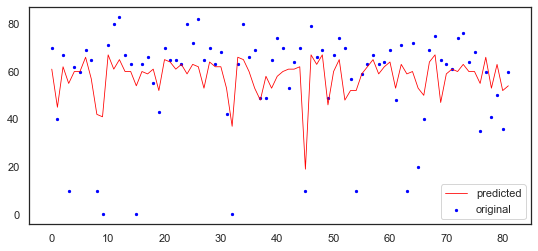

In [174]:
X_train_final,y_train_final=X_std_train,y_std_train.values.ravel()
X_test_final,y_test_final=X_std_test,y_std_test.values.ravel()

model = GradientBoostingRegressor(random_state=42)
params = {
    'learning_rate' : [0.001,0.01,0.02,0.05,0.1],#0.11 ,0.25,0.33, 0.5 ,1],
    'n_estimators' : [ 4, 8, 16, 32, 64, 100, 150,180,200,250,300],#,450,500,550,600,700,750,800,850,900],
    'max_depth': [ 1,  2,  3,  4,  5],#,  6,  7,  8,  9, 10],
    'min_samples_split': [0.001,0.005,0.01,0.02,0.1, 0.2, 0.3]#, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

 }

score = make_scorer(mean_squared_error)

gridsearch = GridSearchCV(model, params, cv=5, return_train_score=True)
gridsearch.fit(X_train_final, y_train_final)
print(gridsearch.best_params_)

best_estim=gridsearch.best_estimator_
print(best_estim)

best_estim.fit(X_train_final,y_train_final)

ytr_pred=best_estim.predict(X_train_final)

# invert transform on predictions
ytr_pred=target_scaler.inverse_transform(ytr_pred.reshape(-1, 1))
y_train_final=target_scaler.inverse_transform(y_train_final.reshape(-1, 1))

mse = mean_squared_error(ytr_pred,y_train_final)
r2 = r2_score(y_train_final,ytr_pred)
print("MSE sur donnees de training: %.2f" % mse)
print("R2: sur donnees de training: %.2f" % -r2)

ypred=best_estim.predict(X_test_final)

ypred=np.round(target_scaler.inverse_transform(ypred.reshape(-1, 1)),0)
y_test_final=target_scaler.inverse_transform(y_test_final.reshape(-1, 1))

mse = mean_squared_error(y_test_final, ypred)
r2 = r2_score(y_test_final, ypred)
print("MSE: sur donnees de test %.2f" % mse)
print("R2 sur donnees de test: %.2f" % r2)

x_ax = range(len(y_test_final))
plt.scatter(x_ax, y_test_final, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

In [ ]:
X,y                         = X_std_train,y_std_train.values.ravel()
X_test_final,y_test_final   = X_std_test, y_std_test.values.ravel()

param_grid = {'C': [0.1, 1,5, 10, 100, 1000,1500],
              'degree' : [3,8],
              #'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'gamma' : ['auto','scale'],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
 
grid = GridSearchCV(SVR(), param_grid, 
                        cv = 10,
                        n_jobs= -1,
                       return_train_score=True)
 
# fitting the model for grid search
grid.fit(X, y)
myresults = pd.concat([pd.DataFrame(grid.cv_results_["params"]),
                       pd.DataFrame(grid.cv_results_["mean_train_score"],columns=["mean_train_score"]),
                       pd.DataFrame(grid.cv_results_["std_train_score"],columns=["std_train_score"]),
                       pd.DataFrame(grid.cv_results_["mean_test_score"],columns=["mean_validation_score"]),
                       pd.DataFrame(grid.cv_results_["std_test_score"], columns=["std_validation_score"])],axis=1)
y_test_pred = grid.predict(X_test_final)
print('\n\nScore : {}\nParameters :{}\nFinal Test score :{}\n\n'.format(grid.best_score_, grid.best_params_,grid.score(X_test_final,y_test_final)))
myresults.sort_values(by=['mean_validation_score'], ascending=False)

In [ ]:
X,y                         = X_std_train,y_std_train.values.ravel()
X_test_final,y_test_final   = X_std_test, y_std_test.values.ravel()

param_grid = {'C': [0.001,0.005,0.0025,0.1, 1,5, 10, 100, 1000,1500],
              'max_iter' : [100,200,500,1000,1500,2000],
              #'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'random_state' : [10,22,42,50,55,60,88,90,100,120,130,200,300,400],
              'warm_start':[1,10,20,30,40],
              
             }
 
grid = GridSearchCV(PassiveAggressiveRegressor(), param_grid, 
                        cv = 10,
                        n_jobs= -1,
                        return_train_score=True)
 
# fitting the model for grid search
grid.fit(X, y)
myresults = pd.concat([pd.DataFrame(grid.cv_results_["params"]),
                       pd.DataFrame(grid.cv_results_["mean_train_score"],columns=["mean_train_score"]),
                       pd.DataFrame(grid.cv_results_["std_train_score"],columns=["std_train_score"]),
                       pd.DataFrame(grid.cv_results_["mean_test_score"],columns=["mean_validation_score"]),
                       pd.DataFrame(grid.cv_results_["std_test_score"], columns=["std_validation_score"])],axis=1)
ypred = grid.predict(X_test_final)
print('\n\nScore : {}\nParameters :{}\nFinal Test score :{}\n\n'.format(grid.best_score_, grid.best_params_,grid.score(X_test_final,y_test_final)))
myresults.sort_values(by=['mean_validation_score'], ascending=False)



In [ ]:
X,y                         = X_std_train,y_std_train.values.ravel()
X_test_final,y_test_final   = X_std_test, y_std_test.values.ravel()

param_grid = {'C': [0.001,0.005,0.0025,0.1, 1,5, 10, 100, 1000,1500],
              'max_iter' : [100,200,500,1000,1500,2000],
              #'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'random_state' : [10,22,42,50,55,60,88,90,100,120,130,200,300,400],
              'warm_start':[1,10,20,30,40],
              
             }
 
grid = GridSearchCV(PassiveAggressiveRegressor(), param_grid, 
                        cv = 10,
                        n_jobs= -1,
                        return_train_score=True)
 
# fitting the model for grid search
grid.fit(X, y)
myresults = pd.concat([pd.DataFrame(grid.cv_results_["params"]),
                       pd.DataFrame(grid.cv_results_["mean_train_score"],columns=["mean_train_score"]),
                       pd.DataFrame(grid.cv_results_["std_train_score"],columns=["std_train_score"]),
                       pd.DataFrame(grid.cv_results_["mean_test_score"],columns=["mean_validation_score"]),
                       pd.DataFrame(grid.cv_results_["std_test_score"], columns=["std_validation_score"])],axis=1)
ypred = grid.predict(X_test_final)
print('\n\nScore : {}\nParameters :{}\nFinal Test score :{}\n\n'.format(grid.best_score_, grid.best_params_,grid.score(X_test_final,y_test_final)))
myresults.sort_values(by=['mean_validation_score'], ascending=False)



In [ ]:
X_train_final,y_train_final=X_train_dataset,y_train_dataset.values.ravel()
X_test_final,y_test_final=X_test_dataset,y_test_dataset.values.ravel()

model = GradientBoostingRegressor(random_state=42)
params = {
    'learning_rate' : [0.001,0.01,0.02,0.05,0.1],#0.11 ,0.25,0.33, 0.5 ,1],
    'n_estimators' : [ 4, 8, 16, 32, 64, 100, 150,180,200,250,300],#,450,500,550,600,700,750,800,850,900],
    'max_depth': [ 1,  2,  3,  4,  5],#,  6,  7,  8,  9, 10],
    'min_samples_split': [0.001,0.005,0.01,0.02,0.1, 0.2, 0.3]#, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

 }

score = make_scorer(mean_squared_error)

gridsearch = GridSearchCV(model, params, cv=5, return_train_score=True)
gridsearch.fit(X_train_final, y_train_final)
print(gridsearch.best_params_)

best_estim=gridsearch.best_estimator_
print(best_estim)

best_estim.fit(X_train_final,y_train_final)

ytr_pred=best_estim.predict(X_train_final)

# invert transform on predictions
ytr_pred=trans_y.inverse_transform(ytr_pred.reshape(-1, 1))
y_train_final=trans_y.inverse_transform(y_train_final.reshape(-1, 1))

mse = mean_squared_error(ytr_pred,y_train_final)
r2 = r2_score(y_train_final,ytr_pred)
print("MSE sur donnees de training: %.2f" % mse)
print("R2: sur donnees de training: %.2f" % -r2)

ypred=best_estim.predict(X_test_final)

ypred=np.round(trans_y.inverse_transform(ypred.reshape(-1, 1)),0)
y_test_final=trans_y.inverse_transform(y_test_final.reshape(-1, 1))

mse = mean_squared_error(y_test_final, ypred)
r2 = r2_score(y_test_final, ypred)
print("MSE: sur donnees de test %.2f" % mse)
print("R2 sur donnees de test: %.2f" % r2)

x_ax = range(len(y_test_final))
plt.scatter(x_ax, y_test_final, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

EDA

https://medium.com/@anusharkannan/exploratory-data-analysis-adcb83fdd0fe

http://www.ophtalmo.net/bv/Doc/2002-6150-XZ-ETDRS.pdf

http://orthoptie.net/documents/Acuitevisuelle.pdf

https://www.sciencedirect.com/science/article/abs/pii/S0181551216301243

https://www.kaggle.com/gaborfodor/resnet50-example

https://medium.com/@kenneth.ca95/a-guide-to-transfer-learning-with-keras-using-resnet50-a81a4a28084b

Traitement des images

https://www.youtube.com/watch?v=WqRgl4iNDd0

Data Imputer

https://mkang32.github.io/python/2020/11/21/Missing-data-imputation-using-sklearn.html#knn

Data Scaling 
https://mkang32.github.io/python/2020/12/27/feature-scaling.html
Text tutorial

https://www.mage.ai/blog/text-mining-nlp-analysis-and-n-gram-model

scan images

https://towardsdatascience.com/medical-image-pre-processing-with-python-d07694852606

https://prince-canuma.medium.com/image-pre-processing-c1aec0be3edf

https://www.analyticsvidhya.com/blog/2019/04/introduction-image-segmentation-techniques-python/

Decision Tree Regression

https://medium.com/pursuitnotes/decision-tree-regression-in-6-steps-with-python-1a1c5aa2ee16

How to Transform Target Variables for Regression in Python

https://machinelearningmastery.com/how-to-transform-target-variables-for-regression-with-scikit-learn/

